<a id='main'></a>
# NEUROEVOLUTION
## 3 problems:
- [**Malicious web detection (Classification)**](#web)
- [**Blood donors (Classification)**](#blood)
- [**House price prediction (Regression)**](#house)


**Autors**: Erlantz Calvo (ecalvo021@ikasle.ehu.eus), Unai Carbajo (ucarbajo001@ikasle.ehu.eus)


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, KFold, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow as tf
from tensorflow.python.framework import ops

/home/unaice/UNI/CUARTO/MLNN/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/unaice/UNI/CUARTO/MLNN/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/unaice/UNI/CUARTO/MLNN/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/unaice/UNI/CUARTO/MLNN/venv/lib/python3.6/s

## Common functions

In [35]:
MALICIOUS_WEB_DATASET_PATH = 'webs.csv'
HOUSE_PRICE_DATASET_PATH = 'house_price.csv'
BLOOD_DONORS_DATASET_PATH = 'blood.csv'

def load_data(path):
    df = pd.read_csv(path)
    return df

def get_categorical_columns(df):
    categorical_df = df.select_dtypes(exclude=["number","datetime64"])
    categorical_columns = categorical_df.columns

    # Remove categorical features with only one value
    one_value_features = [] 
    for cat in categorical_columns:
        if df[cat].value_counts().count() == 1:
            one_value_features += [cat]

    df = df.drop(one_value_features, axis=1)
    categorical_df = df.select_dtypes(exclude=["number","datetime64"])
    categorical_columns = categorical_df.columns

    return categorical_columns, df

def categorical_to_numerical(df):
    categorical_columns, df = get_categorical_columns(df)
    df[categorical_columns] = df[categorical_columns].astype('category')
    df[categorical_columns] = df[categorical_columns].apply(lambda x: x.cat.codes)
    
    return df

def split_train_test(df,y_column, regression = True):
    X = df.drop([y_column], axis=1)
    

    if regression:
        Y = df[y_column]
        train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.33, stratify = Y,random_state=42)
    else:
        Y = df[[y_column]]
        train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.33, random_state=42)

    return train_X, test_X, train_Y, test_Y 

def OH_encode(train_x, train_y, test_x, test_y):
    oh = OneHotEncoder()
    train_X_np = train_x.as_matrix()
    train_Y_np = np.array([train_y.as_matrix()]).T
    test_X_np = test_x.as_matrix()
    test_Y_np = np.array([test_y.as_matrix()]).T
    test_Y_np =oh.fit_transform(test_Y_np).toarray()
    train_Y_np =oh.fit_transform(train_Y_np).toarray()

    return train_X_np, train_Y_np, test_X_np, test_Y_np

## MLP
A multilayer pereptron (MLP) is a class of feedforward artificial neural network (ANN). The term MLP is used ambiguously, sometimes loosely to any feedforward ANN, sometimes strictly to refer to networks composed of multiple layers of perceptrons (with threshold activation).

<img src="https://elogeel.files.wordpress.com/2010/05/051010_0921_multilayerp1.png?w=700" alt="MLP"></img>

For solving this tasks we are using the sigmoid as activation function.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Sigmoid-function-2.svg/1200px-Sigmoid-function-2.svg.png" alt="sigmoid" width='50%'></img>


We are going to use two different Multilayer perceptron, one for classification tasks and other one for regression tasks.


#### Classification

For this particular task (regression) we use the sigmoid activation function but we have to take into account that this activation function make the output values between 0 and 1. Knowing this we have to normalize the actual outputs so the model predicts the continuous values in that range and then we have to convert them to the real value.

#### Defining the neural network

> **Custom hidden layer number sizes**

> **Custom layer sizes**

> **Input size**: number of features of the input data

> **Output size**: number classes to predict

> **Loss function**:  Softmax cross entropy

> **Optimizer**: Adam optimizer (learning rate = 0.001)

In [36]:
def custom_MLP_classifier(data, classes, test_data, test_classes, layer_sizes, training_epochs = 10000):
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, [None, data.shape[1]])
    y = tf.placeholder(tf.float32, [None, classes.shape[1]])
    
    weights = []
    biases = []
    layers = [x]
    
    last_layer = data.shape[1]
    
    for layer, neurons in enumerate(layer_sizes):
        weights += [tf.Variable(tf.random.normal([last_layer, neurons]), name="layer" + str(layer) + "_weights")]
        
        last_layer = neurons
        biases += [tf.Variable(tf.zeros(neurons), name="layer1_biases")]
        layers += [tf.sigmoid(tf.add(tf.matmul(layers[-1], weights[-1]), biases[-1]))]
    
    weights += [tf.Variable(tf.random.normal([last_layer, classes.shape[1]]), name="layer" + str(len(layers)) + "_weights")]
    biases += [tf.Variable(tf.zeros([classes.shape[1]]), name="layer" + str(len(layers)) + "_biases")]                                                 
    prediction = tf.add(tf.matmul(layers[-1], weights[-1]), biases[-1])

    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=prediction)
    class_pred = tf.argmax(prediction, axis=1)

    optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss)

    init = tf.global_variables_initializer()

    training_epochs = training_epochs
    train_n_samples = data.shape[0]
    display_step = 500

    mini_batch_size = 100
    n_batch = train_n_samples // mini_batch_size + (train_n_samples % mini_batch_size != 0)
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(training_epochs):
            i_batch = (epoch % n_batch)*mini_batch_size
            batch = data[i_batch:i_batch+mini_batch_size, :], classes[i_batch:i_batch+mini_batch_size, :]
            sess.run(optimizer, feed_dict={x: batch[0], y: batch[1]})
            if (epoch+1) % display_step == 0:
                cost = sess.run(loss, feed_dict={x: batch[0], y: batch[1]})
                predicted_num = np.sum(np.argmax(test_classes, axis=1) == sess.run(class_pred, feed_dict={x: test_data}))
                acc = balanced_accuracy_score(np.argmax(test_classes, axis=1), sess.run(class_pred, feed_dict={x: test_data}))
                print(f"predicted:{predicted_num} / {test_classes.shape[0]}")
                print("Epoch:", str(epoch+1), "Error:", np.mean(cost), "Balanced Accuracy:", acc)
        parameters = sess.run(weights+biases)
        test_predictions = sess.run(class_pred, feed_dict={x: test_data})
    return parameters, test_predictions, acc

#### Regression

#### Defining the neural network

> **Custom hidden layer number sizes**

> **Custom layer sizes**

> **Input size**: number of features of the input data

> **Output size**: continous value

> **Loss function**:  MSE (mean square error)

> **Optimizer**: Adam optimizer (learning rate = 0.001)

In [108]:
def custom_MLP_regressor(data, classes, test_data, test_classes, min_price,max_prize, layer_sizes, verbose=True, training_epochs = 10000):
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, [None, data.shape[1]])
    y = tf.placeholder(tf.float32, [None, 1])
    
    weights = []
    biases = []
    layers = [x]
    
    last_layer = data.shape[1]
    
    for layer, neurons in enumerate(layer_sizes):
        weights += [tf.Variable(tf.random.normal([last_layer, neurons]), name="layer" + str(layer) + "_weights")]
        
        last_layer = neurons
        biases += [tf.Variable(tf.zeros(neurons), name="layer1_biases")]
        layers += [tf.sigmoid(tf.add(tf.matmul(layers[-1], weights[-1]), biases[-1]))]
    
    weights += [tf.Variable(tf.random.normal([last_layer, 1]), name="layer" + str(len(layers)) + "_weights")]
    biases += [tf.Variable(tf.zeros([1]), name="layer" + str(len(layers)) + "_biases")]                                                 
    prediction = tf.sigmoid(tf.add(tf.matmul(layers[-1], weights[-1]), biases[-1]))


    # Mean Squared Error
    loss = tf.losses.mean_squared_error(labels=y, predictions=prediction)
    optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss)

    init = tf.global_variables_initializer()

    train_n_samples = data.shape[0]
    display_step = 200

    mini_batch_size = 100
    n_batch = train_n_samples // mini_batch_size + (train_n_samples % mini_batch_size != 0)
    epochs = []
    errors = []
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(training_epochs):
            i_batch = (epoch % n_batch)*mini_batch_size
            batch = data[i_batch:i_batch+mini_batch_size, :], classes[i_batch:i_batch+mini_batch_size,:]
            sess.run(optimizer, feed_dict={x: batch[0], y: batch[1]})
            cost = sess.run(loss, feed_dict={x: batch[0], y: batch[1]})
            
            if verbose and (epoch+1) % display_step == 0:
                predicted = sess.run(prediction, feed_dict={x: test_data}) * (max_price - min_price) + min_price
                actual_results = test_classes * (max_price - min_price) + min_price
                acc = mse(actual_results, predicted)
                epochs.append(epoch)
                errors.append(acc)
                print("Epoch:", str(epoch+1), "MSE normalized:", np.mean(cost), "MSE:", acc)

        parameters = sess.run(weights+biases)
        test_predictions = sess.run(prediction, feed_dict={x: test_data})
    
    if verbose:
      plt.plot(epochs, errors)
      plt.xlabel('Epoch')
      plt.ylabel('Error (MSE)')
      plt.show()
    return parameters, test_predictions, acc

# Deap

## Neuroevolution: Optimizing layer's size

#### Defining the complete generational algorithm

> **Individual**: the structure of the layers of the NN is defined as individual based on a predefined layer number
 (by default 5 layers). The number of neurons of each layer will be between 20 and the *n_neurons* parameter of the
 *run_deap_web* function (by default 150 neurons).
 
> **Evaluation**: the fitness of each inidividual is based on the accuracy of the NN that uses the evolved layer structure (individual).

> **Population**: number of individuals for each generation (by default 4 individuals).


#### Defining operators

> **Initialization**: we are using the method *initRepeat* function that returns an expected *n* values. This is used 
for the generation of each individual (list of layer sizes) and for the generation of the population (list of individuals). 

> **Mutation**: the used mutation method is *mutUniformInt*, which mutates the individuals by replacing attributes (size of a certain layer) 
based of a probabilty of 0.1, by a integer uniformly drawn between 10 and 100.

> **Crossover**: the used crossover method is *cxOnePoint*, which consists in a one crossover between 2 individuals.

> <img alt="One point crossover."
src="https://www.tutorialspoint.com/genetic_algorithms/images/one_point_crossover.jpg" width="75%">

> One point crossover. Source: https://www.tutorialspoint.com/genetic_algorithms/genetic_algorithms_crossover.htm

> **Selection**: the chosen selection method is *selTournament*, which consists in selecting the best individual among
a randomly selected bunch of individuals (3 individuals), by default 1 time.




In [38]:
from deap import algorithms,base, creator, tools
import random

In [81]:
# Definition of operators and hyperparameter of the genetic algorithm
#    - n_neurons: maximum number of neurons per layer
#    - n_layers: number of layers
#    - verbose: True if the the genetic algorithm's output should be in a verbose way
#    - maximize: True if the genetic algorithm should maximize fitness
def prepare_deap_params( train_X, train_Y, test_X, test_Y, min_val_reg=None, max_val_reg=None, n_neurons = 150, n_layers = 10, verbose=True, maximize=True, classifier = True):
    if maximize:
        creator.create("Fitness", base.Fitness, weights=(1.0,))  # 1.0 for maximizing, -1.0 for minimizing
    else:
        creator.create("Fitness", base.Fitness, weights=(-1.0,))  

    creator.create("Individual", list, fitness=creator.Fitness)

    toolbox = base.Toolbox()
    
    # Attribute generator 
    toolbox.register("attr_int", random.randint, 20, n_neurons)

    # Structure initializers
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n_layers)
    
    # Population
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evalMLP,train_X= train_X,
    train_Y = train_Y, test_X=test_X,
    test_Y= test_Y, min_val_reg=min_val_reg, max_val_reg=max_val_reg,
    classifier=classifier)

    # The two individuals are modified in place and both keep their original length
    toolbox.register("mate", tools.cxOnePoint)
    # Mutate an individual by replacing attributes, with probability indpb, by a integer uniformly drawn between low and up inclusively
    toolbox.register("mutate", tools.mutUniformInt, low=10, up=100, indpb=0.1)
    # Select the best individual among tournsize randomly chosen individuals, k times. The list returned contains references to the input individuals
    toolbox.register("select", tools.selTournament, tournsize=3)

    return toolbox

# Evaluation function. Returns the fitness of certain individual
def evalMLP(individual, train_X, train_Y, test_X, test_Y,min_val_reg, max_val_reg, classifier = True):
    print(individual)
    if classifier:
        _, _, fitness = custom_MLP_classifier( train_X, train_Y, test_X, test_Y, individual)
    else:
        #regression
        _, _, fitness = custom_MLP_regressor(train_X, train_Y, test_X, test_Y, min_val_reg, max_val_reg, individual)
    return fitness,

# Function that uses the predefined genetic algorithm based on some parameters:
#    - n_neurons: maximum number of neurons per layer
#    - n_layers: number of layers
#    - verbose: True if the the genetic algorithm's output should be in a verbose way
def run_deap(  train_X, train_Y, test_X, test_Y,min_val_reg=None, max_val_reg=None, n_neurons = 150, n_layers = 5,n_population = 4, verbose = True, classifier = True, maximize=True):
    toolbox = prepare_deap_params( train_X, train_Y, test_X, test_Y,min_val_reg, max_val_reg, n_neurons=n_neurons, n_layers=n_layers, verbose=verbose, classifier= classifier, maximize = maximize)
    pop = toolbox.population(n_population)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=6, 
                                stats=stats, halloffame=hof, verbose=verbose)
    return pop, log, hof

# Evoflow from Unai Garciarena

We used the library made by Unai Garciarena that uses the Deap library for solving neuroevolutionary tasks in a very simple way.

[Evoflow](https://github.com/unaigarciarena/EvoFlow)

In [40]:
from EvoFlow.Network import MLPDescriptor
from EvoFlow.evolution import Evolving
from EvoFlow.metrics import ret_evals

In [41]:
def evolve_evoflow(X_train, y_train, X_test, y_test, loss, evaluation, save_params = False):    
    e = Evolving(loss=loss, desc_list=[MLPDescriptor],
    x_trains=[X_train], y_trains=[y_train], x_tests=[X_test],
    y_tests=[y_test],
    evaluation=evaluation,
    n_inputs=[X_train.shape[1]], n_outputs=[y_test.shape[1]],
    batch_size=100, population=10, generations=5, iters=10,
    n_layers=5, max_layer_size=100)
    result, log_book, hof_evoflow  = e.evolve()
    if save_params:
        np.save("simple_res_rand.npy", np.array(ret_evals()))

    return result, log_book, hof_evoflow

<a id='web'></a>
***
[**\***](#main)
# Malicious web detection



# Data explanation

The dataset used contains information about 1781 webs, which collects certain information as the number of characters of the URL, 
the OS of the server got from some packet response, packets received from the web, etc. Unfortunately, this dataset is highly unbalanced,
because the instances of benign webs is much higher than the instances of malicious webs. 

## Features (18)
- URL: it is the anonimous identification of the URL analyzed in the study
- URL_LENGTH: it is the number of characters in the URL
- NUMBERSPECIALCHARACTERS: it is number of special characters identified in the URL, such as, “/”, “%”, “#”, “&”, “. “, “=”
- CHARSET: it is a categorical value and its meaning is the character encoding standard (also called character set).
- SERVER: it is a categorical value and its meaning is the operative system of the server got from the packet response.
- CONTENT_LENGTH: it represents the content size of the HTTP header.
- WHOIS_COUNTRY: it is a categorical variable, its values are the countries we got from the server response (specifically, our script used the API of Whois).
- WHOIS_STATEPRO: it is a categorical variable, its values are the states we got from the server response (specifically, our script used the API of Whois).
- WHOIS_REGDATE: Whois provides the server registration date, so, this variable has date values with format DD/MM/YYY HH:MM
- WHOISUPDATEDDATE: Through the Whois we got the last update date from the server analyzed
- TCPCONVERSATIONEXCHANGE: This variable is the number of TCP packets exchanged between the server and our honeypot client
- DISTREMOTETCP_PORT: it is the number of the ports detected and different to TCP
- REMOTE_IPS: this variable has the total number of IPs connected to the honeypot
- APP_BYTES: this is the number of bytes transfered
- SOURCEAPPPACKETS: packets sent from the honeypot to the server
- REMOTEAPPPACKETS: packets received from the server
- APP_PACKETS: this is the total number of IP packets generated during the communication between the honeypot and the server
- DNSQUERYTIMES: this is the number of DNS packets generated during the communication between the honeypot and the server
- TYPE (class): this is a categorical variable, its values represent the type of web page analyzed, specifically, 1 is for malicious websites and 0 is for benign websites



# Sources and dataset

Urcuqui, C., Navarro, A., Osorio, J., & Garcıa, M. (2017). Machine Learning Classifiers to Detect Malicious Websites. CEUR Workshop Proceedings. Vol 1950, 14-17.

[Dataset](https://www.kaggle.com/xwolf12/malicious-and-benign-websites
)


# Loading data

All the data was defined in the *webs.csv* file. So we structured the data using *Pandas'* dataframe.

In [42]:
# URL is the unique identification value of the data, so it irrelevant for the ML task.

df_web = load_data(MALICIOUS_WEB_DATASET_PATH)
df_web = df_web.drop('URL', axis=1)


# Preprocessing
There had been made few preprocessing steps, just to keep the data clean and able to be fit in a logistic regression classifier 
and in a neural network. More complex preprocessing steps had been avoided in order to let the neural network work and improve with the
raw data.
## Imputation

The data retrieved from the *csv* file had missing data in some of the instances, 
so we decided to fill the data with the mean of the previously defined values of the same feature.

## Correcting typos

Some of de data defined in the features "CHARSET" and "WHOIS_COUNTRY" have had the same meaning but were
written in different ways. So, in order to make this data categorical, we have had to correct that data,
leaving unique values.

In [43]:
df_web = df_web.fillna(df_web.mean())

df_web['CHARSET']=np.where(df_web['CHARSET'] =='iso-8859-1', 'ISO-8859-1', df_web['CHARSET'])
df_web['CHARSET']=np.where(df_web['CHARSET'] =='utf-8', 'UTF-8', df_web['CHARSET'])
df_web['WHOIS_COUNTRY']=np.where(np.logical_or(df_web['WHOIS_COUNTRY'] == "[u'GB'; u'UK']", df_web['WHOIS_COUNTRY'] == 'United Kingdom'), 'UK', df_web['WHOIS_COUNTRY'])
df_web['WHOIS_COUNTRY']=np.where(df_web['WHOIS_COUNTRY'] == 'us', 'US', df_web['WHOIS_COUNTRY'])
df_web['WHOIS_COUNTRY']=np.where(df_web['WHOIS_COUNTRY'] == 'se', 'SE', df_web['WHOIS_COUNTRY'])
df_web['WHOIS_COUNTRY']=np.where(df_web['WHOIS_COUNTRY'] == 'ru', 'RU', df_web['WHOIS_COUNTRY'])

## Encoding categorical attributes

Few features were made of non discrete data (text), thus, this data had to be transformed to a discrete way.

In [44]:
df_web = categorical_to_numerical(df_web)
df_web

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,16,7,1,200,263.000000,29,98,59,593,7,0,2,700,9,10,1153,832,9,2.0,1
1,16,6,3,61,15087.000000,29,98,889,593,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,16,6,4,115,324.000000,29,98,889,593,0,0,0,0,0,0,0,0,0,0.0,0
3,17,6,1,200,162.000000,42,4,806,68,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,17,6,3,124,124140.000000,42,137,93,42,57,2,5,4278,61,62,129889,4586,61,4.0,0
5,18,7,3,200,11726.927761,34,70,644,442,11,6,9,894,11,13,838,894,11,0.0,0
6,18,6,1,17,345.000000,42,24,607,10,12,0,3,1189,14,13,8559,1327,14,2.0,0
7,19,6,4,115,324.000000,42,35,258,202,0,0,0,0,0,0,0,0,0,0.0,0
8,20,5,3,210,11726.927761,29,98,845,593,0,0,0,0,2,3,213,146,2,2.0,1
9,20,5,3,210,11726.927761,29,98,845,593,0,0,0,0,2,1,62,146,2,2.0,1


### Visualizing data (pairwise correlation)


In [45]:
corr = df_web.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1,0.917986,0.0901489,-0.143742,0.0888538,-0.106872,-0.0988423,-0.144464,-0.105561,-0.0384072,-0.0398386,-0.0463669,-0.0264463,-0.0422637,-0.0337787,-0.0148566,-0.0266855,-0.0422637,-0.0685331,0.162104
NUMBER_SPECIAL_CHARACTERS,0.917986,1,0.0888084,-0.114685,0.14313,-0.1248,-0.0917736,-0.121966,-0.0791507,-0.0374591,-0.0426189,-0.0471033,-0.0239136,-0.0400957,-0.0305973,-0.0143757,-0.024098,-0.0400957,-0.0500375,0.280897
CHARSET,0.0901489,0.0888084,1,0.132749,0.0580759,0.00925693,-0.0634587,-0.0332409,-0.0869721,-0.00864155,0.0275346,0.0115576,0.0108245,-0.0101169,-0.00388975,-0.00341423,0.0107339,-0.0101169,-0.0211508,0.0114714
SERVER,-0.143742,-0.114685,0.132749,1,-0.0307747,0.180617,0.0181664,0.0731683,-0.00421166,-0.0126522,0.0227165,0.0393046,-0.0207717,-0.0069328,-0.0176925,-0.0262091,-0.0204853,-0.0069328,0.0764451,-0.0820107
CONTENT_LENGTH,0.0888538,0.14313,0.0580759,-0.0307747,1,-0.038418,0.0135197,-0.026931,0.0344185,0.0644157,-8.85812e-05,0.00349969,0.00264212,0.0604549,0.0723621,0.0838331,0.00251355,0.0604549,-0.0323913,-0.0640733
WHOIS_COUNTRY,-0.106872,-0.1248,0.00925693,0.180617,-0.038418,1,-0.221198,-0.0584165,-0.101477,0.00101137,0.0254939,0.0326609,-0.0503149,0.00571708,-0.00527331,0.00377098,-0.0500602,0.00571708,0.0647975,-0.25567
WHOIS_STATEPRO,-0.0988423,-0.0917736,-0.0634587,0.0181664,0.0135197,-0.221198,1,0.164573,0.168834,-0.0111564,-0.0612919,0.0750519,-0.035522,-0.00873408,-0.00799849,0.00798935,-0.035382,-0.00873408,0.0334614,0.0103447
WHOIS_REGDATE,-0.144464,-0.121966,-0.0332409,0.0731683,-0.026931,-0.0584165,0.164573,1,0.386948,0.0671249,-0.0399478,0.0725707,-0.000538888,0.0707502,0.0666221,0.0630727,-0.000219189,0.0707502,0.0758122,0.0788618
WHOIS_UPDATED_DATE,-0.105561,-0.0791507,-0.0869721,-0.00421166,0.0344185,-0.101477,0.168834,0.386948,1,0.0413311,-0.0387666,0.0793838,-0.000577102,0.0437965,0.0381596,0.0320205,-0.00038468,0.0437965,0.0483421,0.100914
TCP_CONVERSATION_EXCHANGE,-0.0384072,-0.0374591,-0.00864155,-0.0126522,0.0644157,0.00101137,-0.0111564,0.0671249,0.0413311,1,0.555188,0.33108,0.45732,0.997796,0.990848,0.86558,0.458702,0.997796,0.349823,-0.0402018


# Prepare the training and test datasets
We split the final dataset in two new datasets, train and test. Since we have an unbalanced dataset
we have split the dataset with a stratified method for having the most balanced train and test dataset that is possible.

We have chosen to split the data in 66% for training and 33% for testing.

In [46]:
X_train_web, X_test_web, y_train_web, y_test_web = split_train_test(df_web, 'Type')

### Visualizing splited data

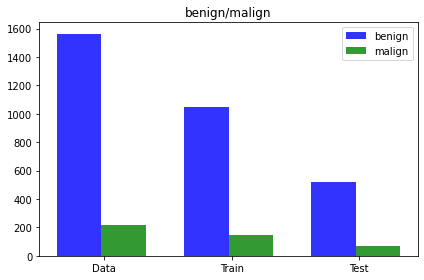

In [47]:
n_benign = len(df_web['Type'].loc[df_web['Type']==0])
n_malign = len(df_web['Type'].loc[df_web['Type']==1])
n_benign_train = len(y_train_web.loc[y_train_web==0])
n_malign_train = len(y_train_web.loc[y_train_web==1])
n_benign_test = len(y_test_web.loc[y_test_web==0])
n_malign_test = len(y_test_web.loc[y_test_web==1])

labels1 = ['benign', 'benign (train)','benign (test)']
labels2 = ['malign','malign (train)','malign (test)']
databars1 = [n_benign, n_benign_train, n_benign_test]
databars2 = [n_malign, n_malign_train, n_malign_test]

fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, databars1, bar_width,alpha=opacity,color='b',label='benign')

rects2 = plt.bar(index + bar_width, databars2, bar_width,alpha=opacity,color='g',label='malign')

plt.title('benign/malign')
plt.xticks(index + 0.2, ('Data', 'Train', 'Test'))
plt.legend()

plt.tight_layout()
plt.show()


## MACHINE LEARNING MODEL

In order to have an starting point about the evaluation of the model, we have defined a logistic regression 
classifier with the previusly splitted data. This evaluation will be useful to compare the results of the raw NN, along with the
optimized one (with DEAP).

In [48]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_web, y_train_web)
prediction = lr.predict(X_test_web)
b_acc_lr = balanced_accuracy_score(y_test_web, prediction)
print(f'Accuracy: {accuracy_score(y_test_web, prediction)}')
print(f'Balanced accuracy: {b_acc_lr}')
print(f'Recall: {recall_score(y_test_web, prediction)}')

confusion_matrix(y_test_web, prediction)

Accuracy: 0.9421768707482994
Balanced accuracy: 0.827389871141744
Recall: 0.676056338028169


array([[506,  11],
       [ 23,  48]])

## NEURAL NETWORK: Multilayer Perceptron

### One-hot encoding


As the MLP uses Softmax function to predict the output with the higher probability, 
the output layer must have at least 2 neurons (1 per class). The predicted class
can only be 0 or 1, and it's defined in 1 column, so, we had to apply the one-hot encoding method to them, splitting them in one different column for each possible prediction value.

In [49]:
train_X_np, train_Y_np, test_X_np, test_Y_np = OH_encode(X_train_web, y_train_web, X_test_web, y_test_web)

/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### Example of use of the neural network

> Used layers: \[10, 10, 15] 

In [50]:
layers = [10, 10, 15]
param, pred, acc_ex_mlp = custom_MLP_classifier(train_X_np, train_Y_np, test_X_np, test_Y_np, layers)
print("Balanced accuracy: ",acc_ex_mlp)


predicted:517 / 588
Epoch: 500 Error: 0.38313797 Balanced Accuracy: 0.5
predicted:517 / 588
Epoch: 1000 Error: 0.31875494 Balanced Accuracy: 0.5
predicted:517 / 588
Epoch: 1500 Error: 0.24322334 Balanced Accuracy: 0.5
predicted:517 / 588
Epoch: 2000 Error: 0.3527794 Balanced Accuracy: 0.5
predicted:517 / 588
Epoch: 2500 Error: 0.291936 Balanced Accuracy: 0.5
predicted:517 / 588
Epoch: 3000 Error: 0.23929612 Balanced Accuracy: 0.5
predicted:517 / 588
Epoch: 3500 Error: 0.3498639 Balanced Accuracy: 0.5
predicted:517 / 588
Epoch: 4000 Error: 0.28847033 Balanced Accuracy: 0.5
predicted:517 / 588
Epoch: 4500 Error: 0.23919529 Balanced Accuracy: 0.5
predicted:517 / 588
Epoch: 5000 Error: 0.34522805 Balanced Accuracy: 0.5
predicted:517 / 588
Epoch: 5500 Error: 0.28893423 Balanced Accuracy: 0.5
predicted:517 / 588
Epoch: 6000 Error: 0.24036054 Balanced Accuracy: 0.5
predicted:517 / 588
Epoch: 6500 Error: 0.34148982 Balanced Accuracy: 0.5
predicted:517 / 588
Epoch: 7000 Error: 0.28930148 Balanc

Deap only apply genetic algorithms with neurons so we are taking the best number of layers also.

**Warning**: this process can last a long time.

In [51]:
best_results_hof = {} #dictionary where best combinations will be added
collection_log = {}
layer_number = 6        # The number of layers of de NN will be 
                        # from 2 to layer_number - 1

for i in range(2,layer_number):
    pop, log, hof = run_deap(train_X_np, train_Y_np, test_X_np, test_Y_np,n_neurons=100, n_layers=i, n_population=5)
    best_results_hof[i] = hof
    collection_log[i] = log

[41, 42]


/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


predicted:525 / 588
Epoch: 500 Error: 0.29241157 Balanced Accuracy: 0.5806385702999428
predicted:525 / 588
Epoch: 1000 Error: 0.22514737 Balanced Accuracy: 0.586713705832675
predicted:528 / 588
Epoch: 1500 Error: 0.18915434 Balanced Accuracy: 0.6078404663960553
predicted:527 / 588
Epoch: 2000 Error: 0.23782443 Balanced Accuracy: 0.619023619473125
predicted:532 / 588
Epoch: 2500 Error: 0.24187914 Balanced Accuracy: 0.6481597515460267
predicted:531 / 588
Epoch: 3000 Error: 0.15428855 Balanced Accuracy: 0.647192633557632
predicted:533 / 588
Epoch: 3500 Error: 0.21188255 Balanced Accuracy: 0.6491268695344212
predicted:531 / 588
Epoch: 4000 Error: 0.21903466 Balanced Accuracy: 0.647192633557632
predicted:527 / 588
Epoch: 4500 Error: 0.16620643 Balanced Accuracy: 0.6433241616040537
predicted:531 / 588
Epoch: 5000 Error: 0.20740229 Balanced Accuracy: 0.647192633557632
predicted:528 / 588
Epoch: 5500 Error: 0.21967839 Balanced Accuracy: 0.6564415506579127
predicted:526 / 588
Epoch: 6000 Error:

predicted:550 / 588
Epoch: 7000 Error: 0.15779 Balanced Accuracy: 0.8721224834500232
predicted:550 / 588
Epoch: 7500 Error: 0.0976701 Balanced Accuracy: 0.8721224834500232
predicted:550 / 588
Epoch: 8000 Error: 0.1358995 Balanced Accuracy: 0.8721224834500232
predicted:547 / 588
Epoch: 8500 Error: 0.15639624 Balanced Accuracy: 0.8692211294848393
predicted:548 / 588
Epoch: 9000 Error: 0.09260875 Balanced Accuracy: 0.870188247473234
predicted:548 / 588
Epoch: 9500 Error: 0.1250098 Balanced Accuracy: 0.870188247473234
predicted:548 / 588
Epoch: 10000 Error: 0.15510407 Balanced Accuracy: 0.870188247473234
gen	nevals	avg     	std    	min     	max     
0  	5     	0.768701	0.10939	0.619024	0.870188
[85, 89]
predicted:535 / 588
Epoch: 500 Error: 0.24946125 Balanced Accuracy: 0.7847140872313183
predicted:542 / 588
Epoch: 1000 Error: 0.19119176 Balanced Accuracy: 0.8218595908137412
predicted:543 / 588
Epoch: 1500 Error: 0.108801626 Balanced Accuracy: 0.8289018443348679
predicted:542 / 588
Epoch: 

predicted:534 / 588
Epoch: 3000 Error: 0.07191595 Balanced Accuracy: 0.722995613915602
predicted:537 / 588
Epoch: 3500 Error: 0.17198637 Balanced Accuracy: 0.7137466968153213
predicted:537 / 588
Epoch: 4000 Error: 0.13960218 Balanced Accuracy: 0.7198218323480535
predicted:536 / 588
Epoch: 4500 Error: 0.06953664 Balanced Accuracy: 0.7310049854251233
predicted:537 / 588
Epoch: 5000 Error: 0.16014428 Balanced Accuracy: 0.7137466968153213
predicted:533 / 588
Epoch: 5500 Error: 0.12638557 Balanced Accuracy: 0.7341787669926717
predicted:527 / 588
Epoch: 6000 Error: 0.13819182 Balanced Accuracy: 0.7283760590623042
predicted:541 / 588
Epoch: 6500 Error: 0.12747678 Balanced Accuracy: 0.7540659819652926
predicted:534 / 588
Epoch: 7000 Error: 0.14369355 Balanced Accuracy: 0.7533712915792629
predicted:550 / 588
Epoch: 7500 Error: 0.054332938 Balanced Accuracy: 0.866047347917291
predicted:557 / 588
Epoch: 8000 Error: 0.1566927 Balanced Accuracy: 0.8667420383033209
predicted:546 / 588
Epoch: 8500 Er

predicted:514 / 588
Epoch: 9000 Error: 0.1624881 Balanced Accuracy: 0.5882256790257989
predicted:514 / 588
Epoch: 9500 Error: 0.17220148 Balanced Accuracy: 0.5882256790257989
predicted:514 / 588
Epoch: 10000 Error: 0.15506536 Balanced Accuracy: 0.5882256790257989
[69, 95]
predicted:509 / 588
Epoch: 500 Error: 0.2599963 Balanced Accuracy: 0.583390089083826
predicted:524 / 588
Epoch: 1000 Error: 0.21305795 Balanced Accuracy: 0.6221974010406734
predicted:523 / 588
Epoch: 1500 Error: 0.15875766 Balanced Accuracy: 0.627305418585011
predicted:528 / 588
Epoch: 2000 Error: 0.18689144 Balanced Accuracy: 0.6382161440597162
predicted:528 / 588
Epoch: 2500 Error: 0.18404949 Balanced Accuracy: 0.6503664151251805
predicted:529 / 588
Epoch: 3000 Error: 0.13001715 Balanced Accuracy: 0.651333533113575
predicted:531 / 588
Epoch: 3500 Error: 0.15643068 Balanced Accuracy: 0.6532677690903642
predicted:531 / 588
Epoch: 4000 Error: 0.1968074 Balanced Accuracy: 0.6532677690903642
predicted:532 / 588
Epoch: 45

predicted:560 / 588
Epoch: 5500 Error: 0.09714073 Balanced Accuracy: 0.8574931212030403
predicted:564 / 588
Epoch: 6000 Error: 0.034317542 Balanced Accuracy: 0.8674367286893507
predicted:564 / 588
Epoch: 6500 Error: 0.110881805 Balanced Accuracy: 0.8674367286893507
predicted:563 / 588
Epoch: 7000 Error: 0.091242865 Balanced Accuracy: 0.8664696107009562
predicted:561 / 588
Epoch: 7500 Error: 0.033801112 Balanced Accuracy: 0.8645353747241671
predicted:561 / 588
Epoch: 8000 Error: 0.103572845 Balanced Accuracy: 0.8645353747241671
predicted:560 / 588
Epoch: 8500 Error: 0.07670531 Balanced Accuracy: 0.8635682567357725
predicted:559 / 588
Epoch: 9000 Error: 0.023383152 Balanced Accuracy: 0.8626011387473779
predicted:554 / 588
Epoch: 9500 Error: 0.1319088 Balanced Accuracy: 0.8759909554036014
predicted:562 / 588
Epoch: 10000 Error: 0.07571434 Balanced Accuracy: 0.877652763778026
[69, 48]
predicted:543 / 588
Epoch: 500 Error: 0.31130722 Balanced Accuracy: 0.7863758956057427
predicted:535 / 588

predicted:527 / 588
Epoch: 1500 Error: 0.14637212 Balanced Accuracy: 0.6372490260713215
predicted:526 / 588
Epoch: 2000 Error: 0.22547291 Balanced Accuracy: 0.636281908082927
predicted:525 / 588
Epoch: 2500 Error: 0.1778091 Balanced Accuracy: 0.6353147900945324
predicted:525 / 588
Epoch: 3000 Error: 0.14622821 Balanced Accuracy: 0.6353147900945324
predicted:525 / 588
Epoch: 3500 Error: 0.22294132 Balanced Accuracy: 0.6353147900945324
predicted:525 / 588
Epoch: 4000 Error: 0.17443596 Balanced Accuracy: 0.6353147900945324
predicted:526 / 588
Epoch: 4500 Error: 0.16417657 Balanced Accuracy: 0.636281908082927
predicted:540 / 588
Epoch: 5000 Error: 0.21980324 Balanced Accuracy: 0.8199253548369521
predicted:540 / 588
Epoch: 5500 Error: 0.18053676 Balanced Accuracy: 0.8199253548369521
predicted:541 / 588
Epoch: 6000 Error: 0.11952221 Balanced Accuracy: 0.8208924728253466
predicted:540 / 588
Epoch: 6500 Error: 0.21695545 Balanced Accuracy: 0.8199253548369521
predicted:540 / 588
Epoch: 7000 Err

predicted:530 / 588
Epoch: 7500 Error: 0.13476928 Balanced Accuracy: 0.6340752445037732
predicted:530 / 588
Epoch: 8000 Error: 0.1654107 Balanced Accuracy: 0.6340752445037732
predicted:551 / 588
Epoch: 8500 Error: 0.11872837 Balanced Accuracy: 0.8366387882420246
predicted:552 / 588
Epoch: 9000 Error: 0.11835679 Balanced Accuracy: 0.8436810417631515
predicted:551 / 588
Epoch: 9500 Error: 0.15751669 Balanced Accuracy: 0.842713923774757
predicted:549 / 588
Epoch: 10000 Error: 0.089264594 Balanced Accuracy: 0.8347045522652354
[81, 96, 66]
predicted:529 / 588
Epoch: 500 Error: 0.22974193 Balanced Accuracy: 0.6391832620481107
predicted:524 / 588
Epoch: 1000 Error: 0.17789486 Balanced Accuracy: 0.6404228076388699
predicted:521 / 588
Epoch: 1500 Error: 0.14616485 Balanced Accuracy: 0.6375214536736862
predicted:523 / 588
Epoch: 2000 Error: 0.18990892 Balanced Accuracy: 0.627305418585011
predicted:520 / 588
Epoch: 2500 Error: 0.15031962 Balanced Accuracy: 0.648704606750756
predicted:523 / 588
Ep

predicted:516 / 588
Epoch: 4000 Error: 0.17501305 Balanced Accuracy: 0.6083853216007846
predicted:518 / 588
Epoch: 4500 Error: 0.14134908 Balanced Accuracy: 0.5920941509793772
predicted:519 / 588
Epoch: 5000 Error: 0.15658559 Balanced Accuracy: 0.5930612689677718
predicted:519 / 588
Epoch: 5500 Error: 0.1519928 Balanced Accuracy: 0.6112866755659683
predicted:522 / 588
Epoch: 6000 Error: 0.12776658 Balanced Accuracy: 0.5959626229329555
predicted:522 / 588
Epoch: 6500 Error: 0.14772351 Balanced Accuracy: 0.5959626229329555
predicted:519 / 588
Epoch: 7000 Error: 0.15227932 Balanced Accuracy: 0.6112866755659683
predicted:524 / 588
Epoch: 7500 Error: 0.12739952 Balanced Accuracy: 0.6161222655079412
predicted:523 / 588
Epoch: 8000 Error: 0.14561103 Balanced Accuracy: 0.5969297409213501
predicted:520 / 588
Epoch: 8500 Error: 0.15165795 Balanced Accuracy: 0.6122537935543629
predicted:520 / 588
Epoch: 9000 Error: 0.12708323 Balanced Accuracy: 0.6122537935543629
predicted:523 / 588
Epoch: 9500 E

predicted:518 / 588
Epoch: 10000 Error: 0.085792676 Balanced Accuracy: 0.6406952352412347
5  	2     	0.820203	0.089754 	0.640695	0.86508 
[81, 96, 66]
predicted:522 / 588
Epoch: 500 Error: 0.16665901 Balanced Accuracy: 0.5838123518674913
predicted:520 / 588
Epoch: 1000 Error: 0.20149109 Balanced Accuracy: 0.6001035224888985
predicted:518 / 588
Epoch: 1500 Error: 0.13472039 Balanced Accuracy: 0.5799438799139129
predicted:520 / 588
Epoch: 2000 Error: 0.12243771 Balanced Accuracy: 0.5879532514234342
predicted:520 / 588
Epoch: 2500 Error: 0.17445004 Balanced Accuracy: 0.6061786580216307
predicted:518 / 588
Epoch: 3000 Error: 0.12622713 Balanced Accuracy: 0.586019015446645
predicted:518 / 588
Epoch: 3500 Error: 0.12109325 Balanced Accuracy: 0.586019015446645
predicted:519 / 588
Epoch: 4000 Error: 0.16792887 Balanced Accuracy: 0.6052115400332362
predicted:518 / 588
Epoch: 4500 Error: 0.12260418 Balanced Accuracy: 0.586019015446645
predicted:518 / 588
Epoch: 5000 Error: 0.11908559 Balanced Ac

predicted:529 / 588
Epoch: 6000 Error: 0.046079624 Balanced Accuracy: 0.718160023973629
predicted:529 / 588
Epoch: 6500 Error: 0.0767229 Balanced Accuracy: 0.718160023973629
predicted:528 / 588
Epoch: 7000 Error: 0.10831209 Balanced Accuracy: 0.7232680415179666
predicted:529 / 588
Epoch: 7500 Error: 0.03716036 Balanced Accuracy: 0.7303102950390934
predicted:529 / 588
Epoch: 8000 Error: 0.05355135 Balanced Accuracy: 0.7303102950390934
predicted:531 / 588
Epoch: 8500 Error: 0.0947793 Balanced Accuracy: 0.7383196665486147
predicted:532 / 588
Epoch: 9000 Error: 0.036152095 Balanced Accuracy: 0.7392867845370092
predicted:532 / 588
Epoch: 9500 Error: 0.046679534 Balanced Accuracy: 0.7392867845370092
predicted:532 / 588
Epoch: 10000 Error: 0.0979257 Balanced Accuracy: 0.7392867845370092
[41, 33, 75, 39]
predicted:523 / 588
Epoch: 500 Error: 0.2891985 Balanced Accuracy: 0.5544037921922249
predicted:527 / 588
Epoch: 1000 Error: 0.21183063 Balanced Accuracy: 0.6068733484076606
predicted:549 / 58

predicted:526 / 588
Epoch: 1500 Error: 0.18693402 Balanced Accuracy: 0.6241316370174625
predicted:527 / 588
Epoch: 2000 Error: 0.23753168 Balanced Accuracy: 0.6311738905385894
predicted:526 / 588
Epoch: 2500 Error: 0.26404965 Balanced Accuracy: 0.6302067725501947
predicted:524 / 588
Epoch: 3000 Error: 0.17044565 Balanced Accuracy: 0.6221974010406734
predicted:526 / 588
Epoch: 3500 Error: 0.21231258 Balanced Accuracy: 0.6180565014847303
predicted:525 / 588
Epoch: 4000 Error: 0.25752413 Balanced Accuracy: 0.623164519029068
predicted:525 / 588
Epoch: 4500 Error: 0.1694126 Balanced Accuracy: 0.623164519029068
predicted:529 / 588
Epoch: 5000 Error: 0.19981118 Balanced Accuracy: 0.6270329909826464
predicted:528 / 588
Epoch: 5500 Error: 0.2381358 Balanced Accuracy: 0.6260658729942518
predicted:525 / 588
Epoch: 6000 Error: 0.18645918 Balanced Accuracy: 0.623164519029068
predicted:529 / 588
Epoch: 6500 Error: 0.18251407 Balanced Accuracy: 0.6270329909826464
predicted:524 / 588
Epoch: 7000 Error

predicted:522 / 588
Epoch: 8000 Error: 0.2011797 Balanced Accuracy: 0.5898874874002233
predicted:522 / 588
Epoch: 8500 Error: 0.22067368 Balanced Accuracy: 0.5898874874002233
predicted:522 / 588
Epoch: 9000 Error: 0.17829557 Balanced Accuracy: 0.5898874874002233
predicted:522 / 588
Epoch: 9500 Error: 0.2003145 Balanced Accuracy: 0.5898874874002233
predicted:522 / 588
Epoch: 10000 Error: 0.22014494 Balanced Accuracy: 0.5898874874002233
[35, 72, 22, 56]
predicted:514 / 588
Epoch: 500 Error: 0.30906552 Balanced Accuracy: 0.5639251368948701
predicted:537 / 588
Epoch: 1000 Error: 0.19638172 Balanced Accuracy: 0.8170240008717683
predicted:535 / 588
Epoch: 1500 Error: 0.108648464 Balanced Accuracy: 0.8029394938295148
predicted:552 / 588
Epoch: 2000 Error: 0.1710755 Balanced Accuracy: 0.8315307706976871
predicted:545 / 588
Epoch: 2500 Error: 0.17783417 Balanced Accuracy: 0.8308360803116572
predicted:545 / 588
Epoch: 3000 Error: 0.107198216 Balanced Accuracy: 0.8308360803116572
predicted:546 / 

predicted:541 / 588
Epoch: 4000 Error: 0.12294138 Balanced Accuracy: 0.8269676083580788
predicted:540 / 588
Epoch: 4500 Error: 0.10985072 Balanced Accuracy: 0.8260004903696843
predicted:540 / 588
Epoch: 5000 Error: 0.17168383 Balanced Accuracy: 0.8260004903696843
predicted:540 / 588
Epoch: 5500 Error: 0.122615024 Balanced Accuracy: 0.8260004903696843
predicted:541 / 588
Epoch: 6000 Error: 0.09528432 Balanced Accuracy: 0.833042743890811
predicted:541 / 588
Epoch: 6500 Error: 0.16763632 Balanced Accuracy: 0.833042743890811
predicted:541 / 588
Epoch: 7000 Error: 0.12093884 Balanced Accuracy: 0.8391178794235432
predicted:541 / 588
Epoch: 7500 Error: 0.094393864 Balanced Accuracy: 0.833042743890811
predicted:541 / 588
Epoch: 8000 Error: 0.1654122 Balanced Accuracy: 0.833042743890811
predicted:540 / 588
Epoch: 8500 Error: 0.12026364 Balanced Accuracy: 0.8381507614351487
predicted:540 / 588
Epoch: 9000 Error: 0.0938974 Balanced Accuracy: 0.8381507614351487
predicted:540 / 588
Epoch: 9500 Erro

predicted:546 / 588
Epoch: 10000 Error: 0.19026946 Balanced Accuracy: 0.837878333832784
[24, 96, 25, 92, 83]
predicted:514 / 588
Epoch: 500 Error: 0.32826886 Balanced Accuracy: 0.5153240526330127
predicted:514 / 588
Epoch: 1000 Error: 0.26517802 Balanced Accuracy: 0.5153240526330127
predicted:513 / 588
Epoch: 1500 Error: 0.23649819 Balanced Accuracy: 0.5325823412428148
predicted:514 / 588
Epoch: 2000 Error: 0.2919316 Balanced Accuracy: 0.5153240526330127
predicted:513 / 588
Epoch: 2500 Error: 0.26379162 Balanced Accuracy: 0.5325823412428148
predicted:513 / 588
Epoch: 3000 Error: 0.23135792 Balanced Accuracy: 0.5325823412428148
predicted:514 / 588
Epoch: 3500 Error: 0.2732514 Balanced Accuracy: 0.5153240526330127
predicted:513 / 588
Epoch: 4000 Error: 0.27656302 Balanced Accuracy: 0.5325823412428148
predicted:513 / 588
Epoch: 4500 Error: 0.22735444 Balanced Accuracy: 0.5325823412428148
predicted:514 / 588
Epoch: 5000 Error: 0.27060887 Balanced Accuracy: 0.5153240526330127
predicted:513 

predicted:515 / 588
Epoch: 5500 Error: 0.25601214 Balanced Accuracy: 0.6195684746778544
predicted:520 / 588
Epoch: 6000 Error: 0.18343456 Balanced Accuracy: 0.6122537935543629
predicted:517 / 588
Epoch: 6500 Error: 0.24705978 Balanced Accuracy: 0.6093524395891792
predicted:512 / 588
Epoch: 7000 Error: 0.24799412 Balanced Accuracy: 0.6105919851799384
predicted:520 / 588
Epoch: 7500 Error: 0.18398695 Balanced Accuracy: 0.6122537935543629
predicted:517 / 588
Epoch: 8000 Error: 0.24626195 Balanced Accuracy: 0.6154275751219114
predicted:512 / 588
Epoch: 8500 Error: 0.24737102 Balanced Accuracy: 0.6045168496472062
predicted:518 / 588
Epoch: 9000 Error: 0.1794365 Balanced Accuracy: 0.6103195575775737
predicted:516 / 588
Epoch: 9500 Error: 0.2460598 Balanced Accuracy: 0.6083853216007846
predicted:510 / 588
Epoch: 10000 Error: 0.24734108 Balanced Accuracy: 0.6086577492031493
2  	1     	0.788776	0.0902799	0.608658	0.837878
[30, 53, 94, 27, 100]
predicted:512 / 588
Epoch: 500 Error: 0.25268385 Ba

predicted:517 / 588
Epoch: 1500 Error: 0.16987391 Balanced Accuracy: 0.6093524395891792
predicted:532 / 588
Epoch: 2000 Error: 0.20219903 Balanced Accuracy: 0.8121884109297954
predicted:543 / 588
Epoch: 2500 Error: 0.15994626 Balanced Accuracy: 0.8167515732694037
predicted:542 / 588
Epoch: 3000 Error: 0.12118075 Balanced Accuracy: 0.8157844552810091
predicted:537 / 588
Epoch: 3500 Error: 0.2079625 Balanced Accuracy: 0.7987985942735718
predicted:539 / 588
Epoch: 4000 Error: 0.18852425 Balanced Accuracy: 0.8068079657830931
predicted:539 / 588
Epoch: 4500 Error: 0.10740699 Balanced Accuracy: 0.8068079657830931
predicted:539 / 588
Epoch: 5000 Error: 0.19489051 Balanced Accuracy: 0.8068079657830931
predicted:542 / 588
Epoch: 5500 Error: 0.1753106 Balanced Accuracy: 0.809709319748277
predicted:542 / 588
Epoch: 6000 Error: 0.107034415 Balanced Accuracy: 0.809709319748277
predicted:541 / 588
Epoch: 6500 Error: 0.1739616 Balanced Accuracy: 0.8026670662271502
predicted:540 / 588
Epoch: 7000 Erro

predicted:516 / 588
Epoch: 7500 Error: 0.19336979 Balanced Accuracy: 0.5719345084043915
predicted:516 / 588
Epoch: 8000 Error: 0.21651381 Balanced Accuracy: 0.5719345084043915
predicted:516 / 588
Epoch: 8500 Error: 0.23186807 Balanced Accuracy: 0.5719345084043915
predicted:516 / 588
Epoch: 9000 Error: 0.19250663 Balanced Accuracy: 0.5719345084043915
predicted:516 / 588
Epoch: 9500 Error: 0.21570231 Balanced Accuracy: 0.5719345084043915
predicted:516 / 588
Epoch: 10000 Error: 0.23156781 Balanced Accuracy: 0.5719345084043915
6  	4     	0.737715	0.108267 	0.571935	0.837878


Layer nº:  2 	 Best structure:  [94, 48] 	 Fitness:  0.837878333832784
Layer nº:  3 	 Best structure:  [81, 96, 66] 	 Fitness:  0.837878333832784
Layer nº:  4 	 Best structure:  [35, 72, 22, 56] 	 Fitness:  0.837878333832784
Layer nº:  5 	 Best structure:  [30, 53, 94, 27, 100] 	 Fitness:  0.837878333832784


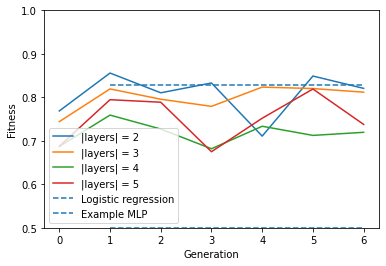

In [52]:
plt.hlines(b_acc_lr,xmin=1,xmax=6,linestyles='dashed', label="Logistic regression")
plt.hlines(acc_ex_mlp,xmin=1,xmax=6,linestyles='dashed', label="Example MLP",color="r")

for i in range(2,layer_number):

    print("Layer nº: ",i,"\t Best structure: ",best_results_hof[i].items[0], "\t Fitness: ",hof.keys[0].values[0])

    gen = collection_log[i].select("gen")
    size_avgs = collection_log[i].select('avg')

    plt.ylim(0.5, 1)
    plt.xlabel("Generation")
    plt.ylabel("Average fitness")

    plt.plot(gen, size_avgs, label="|layers| = "+str(i))

plt.legend()

<a id='blood'></a>
***
[**\***](#main)
# Blood donors


# Data explanation

To demonstrate the RFMTC marketing model (a modified version of RFM), this study adopted the donor database of Blood Transfusion Service Center in Hsin-Chu City in Taiwan. The center passes their blood transfusion service bus to one university in Hsin-Chu City to gather blood donated about every three months. To build an FRMTC model, we selected 748 donors at random from the donor database. 

## Features (4)
    
- V1: Recency - months since last donation
- V2: Frequency - total number of donation
- V3: Monetary - total blood donated in c.c.
- V4: Time - months since first donation), and a binary variable representing whether he/she donated blood in March 2007 (1 stand for donating blood; 0 stands for not donating blood).


The target attribute is a binary variable representing whether he/she donated blood in March 2007 (2 stands for donating blood; 1 stands for not donating blood).


# Sources and dataset

**Author:** Prof. I-Cheng Yeh

Yeh, I-Cheng, Yang, King-Jang, and Ting, Tao-Ming, "Knowledge discovery on RFM model using Bernoulli sequence", Expert Systems with Applications, 2008.

[Dataset](https://www.openml.org/d/1464)

In [53]:
df_blood = load_data(BLOOD_DONORS_DATASET_PATH)
df_blood

,V1,V2,V3,V4,Class
0,2,50,12500,98,2
1,0,13,3250,28,2
2,1,16,4000,35,2
3,2,20,5000,45,2
4,1,24,6000,77,1
5,4,4,1000,4,1
6,2,7,1750,14,2
7,1,12,3000,35,1
8,2,9,2250,22,2
9,5,46,11500,98,2


## Split dataset into training set and test set

In [54]:
X_train_blood, X_test_blood, y_train_blood, y_test_blood = split_train_test(df_blood, 'Class')

In [55]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_blood, y_train_blood)
prediction = lr.predict(X_test_blood)
acc_lr_blood = accuracy_score(y_test_blood, prediction)
bal_acc_lr_blood = balanced_accuracy_score(y_test_blood, prediction)
print(f'Accuracy: {acc_lr_blood}')
print(f'Balanced accuracy: {bal_acc_lr_blood}')
print(f'Recall: {recall_score(y_test_blood, prediction)}')

confusion_matrix(y_test_blood, prediction)

Accuracy: 0.7651821862348178
Balanced accuracy: 0.5317345834835918
Recall: 0.9787234042553191


array([[184,   4],
       [ 54,   5]])

In [56]:
rf = RandomForestClassifier()
rf.fit(X_train_blood, y_train_blood)
prediction = rf.predict(X_test_blood)
acc_rf_blood = accuracy_score(y_test_blood, prediction)
bal_acc_rf_blood = balanced_accuracy_score(y_test_blood, prediction)
print(f'Accuracy: {acc_rf_blood}')
print(f'Balanced accuracy: {bal_acc_rf_blood}')
print(f'Recall: {recall_score(y_test_blood, prediction)}')

confusion_matrix(y_test_blood, prediction)

Accuracy: 0.7408906882591093
Balanced accuracy: 0.6088171655247024
Recall: 0.8617021276595744


array([[162,  26],
       [ 38,  21]])

In [57]:
train_X_np, train_Y_np, test_X_np, test_Y_np = OH_encode(X_train_blood, y_train_blood, X_test_blood, y_test_blood)

/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## NEURAL NETWORK: Multilayer Perceptron

In [58]:
layers = [10,10,15]
param, pred, bal_acc_mlp_blood = custom_MLP_classifier(train_X_np, train_Y_np, test_X_np, test_Y_np, layers)

predicted:188 / 247
Epoch: 500 Error: 0.52695704 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1000 Error: 0.5510956 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1500 Error: 0.27196568 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 2000 Error: 0.5268065 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 2500 Error: 0.5510981 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 3000 Error: 0.27252436 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 3500 Error: 0.52654696 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 4000 Error: 0.55110157 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 4500 Error: 0.3542817 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 5000 Error: 0.4632409 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 5500 Error: 0.5235511 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 6000 Error: 0.41929835 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 6500 Error: 0.46285588 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 7000 Error: 0.52072614 Balanced

## Neuroevolution 

Deap only apply genetic algorithms with neurons so we are taking the best number of layers also.

**Warning**: this process can last a long time.

In [60]:
best_results = {} #dictionary where best combinations will be added
collection_log = {}
layer_number = 6        # The number of layers of de NN will be 
                        # from 2 to layer_number - 1

for i in range(2,layer_number):
    pop, log, hof = run_deap(train_X_np, train_Y_np, test_X_np, test_Y_np, n_neurons=100, n_layers=i, n_population=5)
    best_results[i] = hof
    collection_log[i] = log

/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


[47, 24]
predicted:196 / 247
Epoch: 500 Error: 0.45006463 Balanced Accuracy: 0.6899116480346196
predicted:196 / 247
Epoch: 1000 Error: 0.5046631 Balanced Accuracy: 0.7015416516408222
predicted:197 / 247
Epoch: 1500 Error: 0.22652908 Balanced Accuracy: 0.7042012261089073
predicted:198 / 247
Epoch: 2000 Error: 0.4427928 Balanced Accuracy: 0.6952307969707898
predicted:199 / 247
Epoch: 2500 Error: 0.483008 Balanced Accuracy: 0.6978903714388749
predicted:197 / 247
Epoch: 3000 Error: 0.23343162 Balanced Accuracy: 0.6925712225027046
predicted:199 / 247
Epoch: 3500 Error: 0.44158894 Balanced Accuracy: 0.6978903714388749
predicted:197 / 247
Epoch: 4000 Error: 0.48386705 Balanced Accuracy: 0.6925712225027046
predicted:196 / 247
Epoch: 4500 Error: 0.23085244 Balanced Accuracy: 0.7015416516408222
predicted:199 / 247
Epoch: 5000 Error: 0.44032052 Balanced Accuracy: 0.6978903714388749
predicted:196 / 247
Epoch: 5500 Error: 0.48556465 Balanced Accuracy: 0.7015416516408222
predicted:195 / 247
Epoch: 6

predicted:188 / 247
Epoch: 500 Error: 0.4704826 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1000 Error: 0.5198764 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1500 Error: 0.41483638 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 2000 Error: 0.4636609 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 2500 Error: 0.51566553 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 3000 Error: 0.41715884 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 3500 Error: 0.46306717 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 4000 Error: 0.513562 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 4500 Error: 0.4188928 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 5000 Error: 0.46247575 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 5500 Error: 0.5115535 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 6000 Error: 0.42011836 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 6500 Error: 0.46178013 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 7000 Error: 0.5090284 Balanced A

predicted:196 / 247
Epoch: 10000 Error: 0.50069135 Balanced Accuracy: 0.7015416516408222
[47, 24]
predicted:188 / 247
Epoch: 500 Error: 0.47524503 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1000 Error: 0.55504996 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1500 Error: 0.26720387 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 2000 Error: 0.4732941 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 2500 Error: 0.5539506 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 3000 Error: 0.26083884 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 3500 Error: 0.4716227 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 4000 Error: 0.5530841 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 4500 Error: 0.25155175 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 5000 Error: 0.47009724 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 5500 Error: 0.55233556 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 6000 Error: 0.24480242 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 6500

predicted:195 / 247
Epoch: 5000 Error: 0.44065988 Balanced Accuracy: 0.6523620627479264
predicted:195 / 247
Epoch: 5500 Error: 0.4848958 Balanced Accuracy: 0.5942120447169131
predicted:197 / 247
Epoch: 6000 Error: 0.21375956 Balanced Accuracy: 0.6751262170934006
predicted:195 / 247
Epoch: 6500 Error: 0.44158095 Balanced Accuracy: 0.6523620627479264
predicted:196 / 247
Epoch: 7000 Error: 0.4813897 Balanced Accuracy: 0.6433916336098089
predicted:196 / 247
Epoch: 7500 Error: 0.20116614 Balanced Accuracy: 0.6608366390191129
predicted:196 / 247
Epoch: 8000 Error: 0.44280076 Balanced Accuracy: 0.6433916336098089
predicted:198 / 247
Epoch: 8500 Error: 0.4884769 Balanced Accuracy: 0.6661557879552831
predicted:196 / 247
Epoch: 9000 Error: 0.19095944 Balanced Accuracy: 0.6259466282005048
predicted:195 / 247
Epoch: 9500 Error: 0.44283497 Balanced Accuracy: 0.6407320591417237
predicted:196 / 247
Epoch: 10000 Error: 0.4948398 Balanced Accuracy: 0.6724666426253155
[47, 24]
predicted:188 / 247
Epoch:

predicted:192 / 247
Epoch: 4500 Error: 0.16853723 Balanced Accuracy: 0.6560133429498738
predicted:192 / 247
Epoch: 5000 Error: 0.4460906 Balanced Accuracy: 0.6327533357374684
predicted:193 / 247
Epoch: 5500 Error: 0.50955224 Balanced Accuracy: 0.6528579156148575
predicted:193 / 247
Epoch: 6000 Error: 0.15842313 Balanced Accuracy: 0.6528579156148575
predicted:194 / 247
Epoch: 6500 Error: 0.44432092 Balanced Accuracy: 0.6555174900829427
predicted:191 / 247
Epoch: 7000 Error: 0.5134185 Balanced Accuracy: 0.6300937612693833
predicted:192 / 247
Epoch: 7500 Error: 0.15504737 Balanced Accuracy: 0.6501983411467724
predicted:191 / 247
Epoch: 8000 Error: 0.44126275 Balanced Accuracy: 0.6300937612693833
predicted:192 / 247
Epoch: 8500 Error: 0.51710653 Balanced Accuracy: 0.626938333934367
predicted:192 / 247
Epoch: 9000 Error: 0.14856744 Balanced Accuracy: 0.6327533357374684
predicted:190 / 247
Epoch: 9500 Error: 0.4390757 Balanced Accuracy: 0.6099891813919942
predicted:192 / 247
Epoch: 10000 Err

predicted:188 / 247
Epoch: 5000 Error: 0.46457794 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 5500 Error: 0.53598386 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 6000 Error: 0.46567774 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 6500 Error: 0.46171942 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 7000 Error: 0.53407377 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 7500 Error: 0.47045907 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 8000 Error: 0.45893788 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 8500 Error: 0.5297153 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 9000 Error: 0.47938472 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 9500 Error: 0.45691586 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 10000 Error: 0.52425164 Balanced Accuracy: 0.5
[100, 87, 35]
predicted:188 / 247
Epoch: 500 Error: 0.51060927 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1000 Error: 0.50662875 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1500 Error:

predicted:194 / 247
Epoch: 6500 Error: 0.42144376 Balanced Accuracy: 0.64388748647674
predicted:194 / 247
Epoch: 7000 Error: 0.470718 Balanced Accuracy: 0.6380724846736386
predicted:195 / 247
Epoch: 7500 Error: 0.28846598 Balanced Accuracy: 0.6465470609448252
predicted:194 / 247
Epoch: 8000 Error: 0.42083785 Balanced Accuracy: 0.64388748647674
predicted:194 / 247
Epoch: 8500 Error: 0.47063008 Balanced Accuracy: 0.6380724846736386
predicted:195 / 247
Epoch: 9000 Error: 0.2859634 Balanced Accuracy: 0.6465470609448252
predicted:195 / 247
Epoch: 9500 Error: 0.418788 Balanced Accuracy: 0.6465470609448252
predicted:196 / 247
Epoch: 10000 Error: 0.47114888 Balanced Accuracy: 0.6433916336098089
[100, 25, 66]
predicted:188 / 247
Epoch: 500 Error: 0.45585355 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1000 Error: 0.5077858 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1500 Error: 0.46731672 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 2000 Error: 0.44946238 Balanced Accuracy: 0.5


predicted:186 / 247
Epoch: 8000 Error: 0.44862425 Balanced Accuracy: 0.4946808510638298
predicted:186 / 247
Epoch: 8500 Error: 0.49891537 Balanced Accuracy: 0.4946808510638298
predicted:186 / 247
Epoch: 9000 Error: 0.48438627 Balanced Accuracy: 0.4946808510638298
predicted:186 / 247
Epoch: 9500 Error: 0.43854716 Balanced Accuracy: 0.4946808510638298
predicted:186 / 247
Epoch: 10000 Error: 0.499846 Balanced Accuracy: 0.4946808510638298
5  	4     	0.583141	0.0701065	0.494681	0.643392
[100, 25, 66]
predicted:188 / 247
Epoch: 500 Error: 0.468414 Balanced Accuracy: 0.5
predicted:193 / 247
Epoch: 1000 Error: 0.48787344 Balanced Accuracy: 0.6121529029931483
predicted:191 / 247
Epoch: 1500 Error: 0.2195891 Balanced Accuracy: 0.6184637576631806
predicted:193 / 247
Epoch: 2000 Error: 0.44404906 Balanced Accuracy: 0.6470429138117563
predicted:191 / 247
Epoch: 2500 Error: 0.4541281 Balanced Accuracy: 0.6068337540569779
predicted:195 / 247
Epoch: 3000 Error: 0.21042743 Balanced Accuracy: 0.66399206

predicted:186 / 247
Epoch: 6000 Error: 0.41502327 Balanced Accuracy: 0.4946808510638298
predicted:186 / 247
Epoch: 6500 Error: 0.43388957 Balanced Accuracy: 0.4946808510638298
predicted:187 / 247
Epoch: 7000 Error: 0.49429104 Balanced Accuracy: 0.4973404255319149
predicted:186 / 247
Epoch: 7500 Error: 0.42013338 Balanced Accuracy: 0.4946808510638298
predicted:186 / 247
Epoch: 8000 Error: 0.43760628 Balanced Accuracy: 0.4946808510638298
predicted:187 / 247
Epoch: 8500 Error: 0.48596367 Balanced Accuracy: 0.4973404255319149
predicted:184 / 247
Epoch: 9000 Error: 0.4107733 Balanced Accuracy: 0.48936170212765956
predicted:187 / 247
Epoch: 9500 Error: 0.43059087 Balanced Accuracy: 0.4973404255319149
predicted:184 / 247
Epoch: 10000 Error: 0.4835467 Balanced Accuracy: 0.48936170212765956
[24, 59, 77, 23]
predicted:188 / 247
Epoch: 500 Error: 0.47433257 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1000 Error: 0.52918583 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1500 Error: 0.5335

predicted:188 / 247
Epoch: 6500 Error: 0.5251692 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 7000 Error: 0.55109924 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 7500 Error: 0.2769883 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 8000 Error: 0.5251801 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 8500 Error: 0.5510949 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 9000 Error: 0.2765047 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 9500 Error: 0.5251884 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 10000 Error: 0.5510918 Balanced Accuracy: 0.5
[24, 59, 77, 23]
predicted:188 / 247
Epoch: 500 Error: 0.50425047 Balanced Accuracy: 0.5
predicted:193 / 247
Epoch: 1000 Error: 0.50006974 Balanced Accuracy: 0.5888928957807429
predicted:192 / 247
Epoch: 1500 Error: 0.22338443 Balanced Accuracy: 0.6094933285250631
predicted:190 / 247
Epoch: 2000 Error: 0.4429091 Balanced Accuracy: 0.6448791922106023
predicted:191 / 247
Epoch: 2500 Error: 0.48289207 Balanced Accuracy: 0

predicted:188 / 247
Epoch: 8000 Error: 0.50056005 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 8500 Error: 0.49662563 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 9000 Error: 0.33450204 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 9500 Error: 0.4993661 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 10000 Error: 0.49775004 Balanced Accuracy: 0.5
[51, 76, 44, 44]
predicted:195 / 247
Epoch: 500 Error: 0.45564568 Balanced Accuracy: 0.6872520735665344
predicted:197 / 247
Epoch: 1000 Error: 0.48064005 Balanced Accuracy: 0.6693112152902994
predicted:197 / 247
Epoch: 1500 Error: 0.29601806 Balanced Accuracy: 0.6693112152902994
predicted:194 / 247
Epoch: 2000 Error: 0.45620131 Balanced Accuracy: 0.696222502704652
predicted:195 / 247
Epoch: 2500 Error: 0.47403714 Balanced Accuracy: 0.6698070681572305
predicted:194 / 247
Epoch: 3000 Error: 0.31235322 Balanced Accuracy: 0.678777497295348
predicted:194 / 247
Epoch: 3500 Error: 0.45166516 Balanced Accuracy: 0.696222502704652
predic

predicted:188 / 247
Epoch: 5500 Error: 0.49025166 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 6000 Error: 0.45201164 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 6500 Error: 0.48192 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 7000 Error: 0.49013627 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 7500 Error: 0.45299786 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 8000 Error: 0.47937 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 8500 Error: 0.48896945 Balanced Accuracy: 0.5
predicted:184 / 247
Epoch: 9000 Error: 0.4651985 Balanced Accuracy: 0.5009917057338622
predicted:188 / 247
Epoch: 9500 Error: 0.4771008 Balanced Accuracy: 0.5
predicted:181 / 247
Epoch: 10000 Error: 0.47078496 Balanced Accuracy: 0.49882798413270824
4  	4     	0.611152	0.0573573	0.498828	0.655517
[51, 76, 44, 44]
predicted:188 / 247
Epoch: 500 Error: 0.47751048 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1000 Error: 0.55030745 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1500 Erro

predicted:187 / 247
Epoch: 8500 Error: 0.450422 Balanced Accuracy: 0.4973404255319149
predicted:188 / 247
Epoch: 9000 Error: 0.1450988 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 9500 Error: 0.47652203 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 10000 Error: 0.45523316 Balanced Accuracy: 0.5
[51, 59, 44, 44]
predicted:188 / 247
Epoch: 500 Error: 0.46837762 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1000 Error: 0.538591 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1500 Error: 0.12070886 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 2000 Error: 0.4690159 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 2500 Error: 0.5410959 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 3000 Error: 0.109737456 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 3500 Error: 0.4695665 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 4000 Error: 0.5415669 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 4500 Error: 0.10372017 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 

predicted:193 / 247
Epoch: 3500 Error: 0.4295867 Balanced Accuracy: 0.6354129102055536
predicted:191 / 247
Epoch: 4000 Error: 0.41016725 Balanced Accuracy: 0.624278759466282
predicted:198 / 247
Epoch: 4500 Error: 0.35681966 Balanced Accuracy: 0.6719707897583844
predicted:195 / 247
Epoch: 5000 Error: 0.40257588 Balanced Accuracy: 0.6465470609448252
predicted:190 / 247
Epoch: 5500 Error: 0.40285638 Balanced Accuracy: 0.6855842048323115
predicted:190 / 247
Epoch: 6000 Error: 0.44838694 Balanced Accuracy: 0.6274341868012983
predicted:194 / 247
Epoch: 6500 Error: 0.41790769 Balanced Accuracy: 0.6322574828705373
predicted:195 / 247
Epoch: 7000 Error: 0.39779797 Balanced Accuracy: 0.6872520735665344
predicted:191 / 247
Epoch: 7500 Error: 0.4907245 Balanced Accuracy: 0.65916877028489
predicted:192 / 247
Epoch: 8000 Error: 0.4374704 Balanced Accuracy: 0.6734583483591778
predicted:196 / 247
Epoch: 8500 Error: 0.39255878 Balanced Accuracy: 0.6724666426253155
predicted:195 / 247
Epoch: 9000 Error:

predicted:188 / 247
Epoch: 1000 Error: 0.4768833 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 1500 Error: 0.43763182 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 2000 Error: 0.45180827 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 2500 Error: 0.4709005 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 3000 Error: 0.5241698 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 3500 Error: 0.4515129 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 4000 Error: 0.46885967 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 4500 Error: 0.45498103 Balanced Accuracy: 0.5
predicted:186 / 247
Epoch: 5000 Error: 0.4462287 Balanced Accuracy: 0.4946808510638298
predicted:183 / 247
Epoch: 5500 Error: 0.46307227 Balanced Accuracy: 0.5041471330688785
predicted:183 / 247
Epoch: 6000 Error: 0.47782773 Balanced Accuracy: 0.4925171294626758
predicted:182 / 247
Epoch: 6500 Error: 0.4514268 Balanced Accuracy: 0.5014875586007934
predicted:182 / 247
Epoch: 7000 Error: 0.45762104 Balanced Accuracy: 0

predicted:188 / 247
Epoch: 4000 Error: 0.5102889 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 4500 Error: 0.4244195 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 5000 Error: 0.46229863 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 5500 Error: 0.50945944 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 6000 Error: 0.42338008 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 6500 Error: 0.46011627 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 7000 Error: 0.50879395 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 7500 Error: 0.423265 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 8000 Error: 0.4594553 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 8500 Error: 0.5076718 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 9000 Error: 0.42341062 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 9500 Error: 0.4586929 Balanced Accuracy: 0.5
predicted:188 / 247
Epoch: 10000 Error: 0.5058575 Balanced Accuracy: 0.5
[62, 58, 32, 21, 27]
predicted:191 / 247
Epoch: 500 Error:

predicted:189 / 247
Epoch: 2500 Error: 0.4815769 Balanced Accuracy: 0.6073296069239091
predicted:192 / 247
Epoch: 3000 Error: 0.31498283 Balanced Accuracy: 0.6385683375405697
predicted:191 / 247
Epoch: 3500 Error: 0.41712925 Balanced Accuracy: 0.624278759466282
predicted:193 / 247
Epoch: 4000 Error: 0.47635967 Balanced Accuracy: 0.6412279120086548
predicted:191 / 247
Epoch: 4500 Error: 0.3036378 Balanced Accuracy: 0.6359087630724847
predicted:193 / 247
Epoch: 5000 Error: 0.41563416 Balanced Accuracy: 0.6412279120086548
predicted:193 / 247
Epoch: 5500 Error: 0.47422275 Balanced Accuracy: 0.6412279120086548
predicted:192 / 247
Epoch: 6000 Error: 0.2853542 Balanced Accuracy: 0.6501983411467724
predicted:191 / 247
Epoch: 6500 Error: 0.41484454 Balanced Accuracy: 0.6475387666786874
predicted:191 / 247
Epoch: 7000 Error: 0.4728932 Balanced Accuracy: 0.6475387666786874
predicted:192 / 247
Epoch: 7500 Error: 0.276332 Balanced Accuracy: 0.6501983411467724
predicted:191 / 247
Epoch: 8000 Error: 

In [61]:
for key in best_results:
    print(f'Accuracy: {best_results[key].keys} Layers: {best_results[key].items}')

Accuracy: [deap.creator.Fitness((0.6988820771727371,))] Layers: [[47, 24]]
Accuracy: [deap.creator.Fitness((0.6724666426253155,))] Layers: [[100, 25, 66]]
Accuracy: [deap.creator.Fitness((0.6555174900829427,))] Layers: [[51, 76, 44, 44]]
Accuracy: [deap.creator.Fitness((0.6623241976199062,))] Layers: [[62, 66, 77, 80, 55]]


Layer nº:  2 	 Best structure:  [94, 48] 	 Fitness:  0.6623241976199062
Layer nº:  3 	 Best structure:  [81, 96, 66] 	 Fitness:  0.6623241976199062
Layer nº:  4 	 Best structure:  [35, 72, 22, 56] 	 Fitness:  0.6623241976199062
Layer nº:  5 	 Best structure:  [30, 53, 94, 27, 100] 	 Fitness:  0.6623241976199062


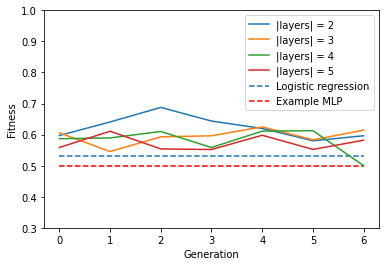

In [62]:
plt.hlines(bal_acc_lr_blood,xmin=0,xmax=6,linestyles='dashed', label="Logistic regression")
plt.hlines(bal_acc_mlp_blood,xmin=0,xmax=6,color = "r",linestyles='dashed', label="Example MLP")

for i in range(2,layer_number):

    print("Layer nº: ",i,"\t Best structure: ",best_results_hof[i].items[0], "\t Fitness: ",hof.keys[0].values[0])

    gen = collection_log[i].select("gen")
    size_avgs = collection_log[i].select('avg')

    plt.ylim(0.3, 1)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")

    plt.plot(gen, size_avgs, label="|layers| = "+str(i))

plt.legend()

**Warning**: this process can last a long time.

In [65]:
result, log_book, hof_evoflow  = evolve_evoflow(train_X_np, train_Y_np, test_X_np, test_Y_np, "XEntropy", "Accuracy_error")

Instructions for updating:
Use keras.layers.flatten instead.
batch
Instructions for updating:
Use keras.layers.batch_normalization instead.
batch
Instructions for updating:
Use keras.layers.dropout instead.
batch
batch
batch
Instructions for updating:
Use tf.cast instead.
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
gen	nevals	avg        	std         	min        	max        
0  	10    	[0.4465587]	[0.25439184]	[0.2388664]	[0.7611336]
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
1  	10    	[0.2388664]	[2.77555756e-17]	[0.2388664]	[0.2388664]
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
2  	10    	[0.2388664]	[2.77555756e-17]	[0.2388664]	[0.2388664]
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
3  	10    	[0.2388664]	[2.77555756e-17]	[0.2388664]	[0.2388664]
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
b

<a id='house'></a>
***
[**\***](#main)
# House price prediction


## Data explanation

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.


[Dataset](https://www.kaggle.com/harlfoxem/housesalesprediction)

In [66]:
df_house = load_data(HOUSE_PRICE_DATASET_PATH)
df_house

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
5,2014-05-02 00:00:00,4.900000e+05,2.0,1.00,880,6380,1.0,0,0,3,880,0,1938,1994,522 NE 88th St,Seattle,WA 98115,USA
6,2014-05-02 00:00:00,3.350000e+05,2.0,2.00,1350,2560,1.0,0,0,3,1350,0,1976,0,2616 174th Ave NE,Redmond,WA 98052,USA
7,2014-05-02 00:00:00,4.820000e+05,4.0,2.50,2710,35868,2.0,0,0,3,2710,0,1989,0,23762 SE 253rd Pl,Maple Valley,WA 98038,USA
8,2014-05-02 00:00:00,4.525000e+05,3.0,2.50,2430,88426,1.0,0,0,4,1570,860,1985,0,46611-46625 SE 129th St,North Bend,WA 98045,USA
9,2014-05-02 00:00:00,6.400000e+05,4.0,2.00,1520,6200,1.5,0,0,3,1520,0,1945,2010,6811 55th Ave NE,Seattle,WA 98115,USA


We have to extract data from the date, in this particular case, we extract that day, month and year.

In [67]:
df_house['date'] = pd.to_datetime(df_house['date'],infer_datetime_format=True)
df_house['year'] = pd.DatetimeIndex(df_house['date']).year
df_house['month'] = pd.DatetimeIndex(df_house['date']).month
df_house['day'] = pd.DatetimeIndex(df_house['date']).day
df_house = df_house.drop(['date'],axis=1)

#### Look for missing data

In [68]:
#missing data
def get_missing_data(dataframe):
  total = dataframe.isnull().sum().sort_values(ascending=False)
  percent = (dataframe.isnull().sum()/dataframe.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  return missing_data.head(20)
  
missing_data = get_missing_data(df_house)
missing_data

,Total,Percent
day,0,0.0
month,0,0.0
bedrooms,0,0.0
bathrooms,0,0.0
sqft_living,0,0.0
sqft_lot,0,0.0
floors,0,0.0
waterfront,0,0.0
view,0,0.0
condition,0,0.0


Luckily it seems that there's no missing values for our data so we can go on.


In [69]:
df_house = categorical_to_numerical(df_house)
df_house

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,year,month,day
0,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,1522,36,62,2014,5,2
1,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,3899,35,58,2014,5,2
2,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,2291,18,26,2014,5,2
3,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,4263,3,7,2014,5,2
4,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,4352,31,31,2014,5,2
5,4.900000e+05,2.0,1.00,880,6380,1.0,0,0,3,880,0,1938,1994,3521,35,54,2014,5,2
6,3.350000e+05,2.0,2.00,1350,2560,1.0,0,0,3,1350,0,1976,0,2286,31,31,2014,5,2
7,4.820000e+05,4.0,2.50,2710,35868,2.0,0,0,3,2710,0,1989,0,2038,21,23,2014,5,2
8,4.525000e+05,3.0,2.50,2430,88426,1.0,0,0,4,1570,860,1985,0,3369,27,27,2014,5,2
9,6.400000e+05,4.0,2.00,1520,6200,1.5,0,0,3,1520,0,1945,2010,3846,35,54,2014,5,2


### Deal with some outliers

In [70]:
df_house = df_house[(df_house['price']>0) & (df_house['bedrooms']>0) & (df_house['price'] <2.5*10**7)]
df_house['bedrooms'] = df_house['bedrooms'].replace([7,8,9],6)
df_house['bathrooms'] = df_house['bathrooms'].apply(lambda x: x if x < 4.5 else 4.5)

/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
X_train_house, X_test_house, y_train_house, y_test_house = split_train_test(df_house, 'price', regression=False)


In [72]:
lr = LinearRegression()
lr.fit(X_train_house, y_train_house)
pred = lr.predict(X_test_house)
mse_house = mse(y_test_house, pred)
print(f'Score: {lr.score(X_test_house, y_test_house)}')
print(f'MSE:{mse_house}')
print(f'Mean error in Dolars:{np.mean(abs(pred[:] - y_test_house.as_matrix()[:]))} $')

Score: 0.5750894605105623
MSE:55006149262.74021
Mean error in Dolars:160310.21245563473 $


/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


## Normalize the prices so we can predict them with linear functions

In [73]:
max_price, min_price = np.max(df_house['price']), np.min(df_house['price'])
y_train_normalized = ((y_train_house - min_price)/(max_price - min_price)).as_matrix()
y_test_normalized = ((y_test_house - min_price)/(max_price - min_price)).as_matrix()

/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 200 MSE normalized: 0.0029270807 MSE: 434731772067.8898
Epoch: 400 MSE normalized: 0.0006282732 MSE: 154987667984.1489
Epoch: 600 MSE normalized: 0.0006109521 MSE: 131690827837.53793
Epoch: 800 MSE normalized: 0.0006872682 MSE: 129540846055.09108
Epoch: 1000 MSE normalized: 0.00040227178 MSE: 129025040165.51436
Epoch: 1200 MSE normalized: 0.0006466405 MSE: 128671700804.9248
Epoch: 1400 MSE normalized: 0.00078094675 MSE: 128228875772.83965
Epoch: 1600 MSE normalized: 0.0007655884 MSE: 127942307700.21144
Epoch: 1800 MSE normalized: 0.0006576564 MSE: 127678265404.86511
Epoch: 2000 MSE normalized: 0.0004060531 MSE: 127448545689.75392
Epoch: 2200 MSE normalized: 0.0006995481 MSE: 127249083001.07243
Epoch: 2400 MSE normalized: 0.010157499 MSE: 127060712170.71211
Epoch: 2600 MSE normalized: 0.00076470495 MSE: 126916078112.28696
Epoch: 2800 MSE normalized: 0.0010583347 MSE: 126756685086.80923
Epoch: 3000 MSE normalized: 0.00076196657 MSE: 126661101182.24571
Epoch: 3200 MSE normalized: 0

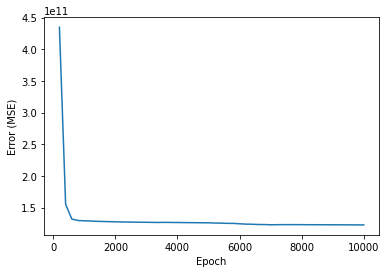

In [109]:
#layers = np.arange(500, 49, -450).astype("int")
layers = [10,10,15]
params, predictions_normalized,best_acc = custom_MLP_regressor(X_train_house.as_matrix(), y_train_normalized, X_test_house.as_matrix(), y_test_normalized, min_price, max_price,layers, training_epochs=10000)

In [75]:
predictions =  predictions_normalized* (max_price - min_price) + min_price
mse_mlp_house = np.mean(abs(predictions[:] - y_test_house.as_matrix()[:]))
print(f'Mean error in Dolars:{mse_mlp_house} $')


Mean error in Dolars:231256.48799575618 $


/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


## Neuroevolution

#### Unai Garciarena's Evoflow in regression task

**Warning**: this process can last a long time.

In [76]:
result, log_book, hof_evoflow  = evolve_evoflow(X_train_house.as_matrix(),
 y_train_normalized,X_test_house.as_matrix(),y_test_normalized, "MSE", "MSE")


/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
gen	nevals	avg             	std            	min               	max             
0  	10    	[1.62826649e+12]	[3.5653528e+12]	[7532009.66267854]	[1.16269672e+13]
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
1  	10    	[7.07871809e+09]	[1.41577537e+10]	[7532009.66267854]	[4.0876988e+10] 
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
2  	10    	[56336286.87792803]	[66461416.11383918]	[6396603.5708909] 	[1.93591648e+08]
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
3  	10    	[28381946.00285135]	[25739307.51048601]	[6396603.5708909] 	[93146589.47123727]
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
4  	10    	[18862023.4975968] 	[11951856.15482277]	[6396603.5708909] 	[41574760.70126241]
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch


##### Getting the best network dimensions found

In [77]:
fitnesses = []
for i in range(len(hof_evoflow.keys)):
    fitnesses.append(hof_evoflow.keys[i].values[0])
lowest_error =fitnesses.index(min(fitnesses)) #lowest MSE

In [78]:
hof_evoflow.items[lowest_error].descriptor_list['n0'].dims

[8, 99, 18]

### DEAP

Deap only apply genetic algorithms with neurons so we are taking the best number of layers also.

**Warning**: this process can last a long time.

/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


[393, 396]
Epoch: 200 MSE normalized: 0.003123849 MSE: 423560378295.8811
Epoch: 400 MSE normalized: 0.0021687592 MSE: 423560350601.2903
Epoch: 600 MSE normalized: 0.0024239232 MSE: 423560327632.8787
Epoch: 800 MSE normalized: 0.0025016014 MSE: 423560136191.8465
Epoch: 1000 MSE normalized: 0.001973179 MSE: 423560022498.7991
Epoch: 1200 MSE normalized: 0.0023565067 MSE: 423559634637.55615
Epoch: 1400 MSE normalized: 0.0026991807 MSE: 423559379628.11066
Epoch: 1600 MSE normalized: 0.002773983 MSE: 423559112140.5771
Epoch: 1800 MSE normalized: 0.0024199362 MSE: 423558687575.3508
Epoch: 2000 MSE normalized: 0.0018151785 MSE: 423554106811.7688
Epoch: 2200 MSE normalized: 0.0022614177 MSE: 423562084440.9833
Epoch: 2400 MSE normalized: 0.012730125 MSE: 423562084440.9833
Epoch: 2600 MSE normalized: 0.00236321 MSE: 423562084440.9833
Epoch: 2800 MSE normalized: 0.0027163017 MSE: 423562084440.9833
Epoch: 3000 MSE normalized: 0.0025299988 MSE: 423562084440.9833
Epoch: 3200 MSE normalized: 0.0018560

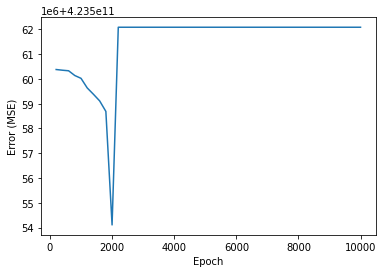

[174, 179]
Epoch: 200 MSE normalized: 0.003043282 MSE: 418028107742.41797
Epoch: 400 MSE normalized: 0.0021424962 MSE: 415848205393.8392
Epoch: 600 MSE normalized: 0.0018322782 MSE: 369999840734.39307
Epoch: 800 MSE normalized: 0.0019819553 MSE: 383682115065.0949
Epoch: 1000 MSE normalized: 0.0011434027 MSE: 281350966228.8937
Epoch: 1200 MSE normalized: 0.0013516116 MSE: 273153631205.95712
Epoch: 1400 MSE normalized: 0.0013931171 MSE: 224486774891.26666
Epoch: 1600 MSE normalized: 0.0013959232 MSE: 200934250816.08878
Epoch: 1800 MSE normalized: 0.0009353836 MSE: 188687836224.13495
Epoch: 2000 MSE normalized: 0.0006484161 MSE: 188677056794.00723
Epoch: 2200 MSE normalized: 0.0007094158 MSE: 175393170234.93167
Epoch: 2400 MSE normalized: 0.008719919 MSE: 170155881712.81564
Epoch: 2600 MSE normalized: 0.00057921634 MSE: 168375213645.87228
Epoch: 2800 MSE normalized: 0.00045935242 MSE: 186810347403.90228
Epoch: 3000 MSE normalized: 0.0005371269 MSE: 164031037275.05463
Epoch: 3200 MSE norma

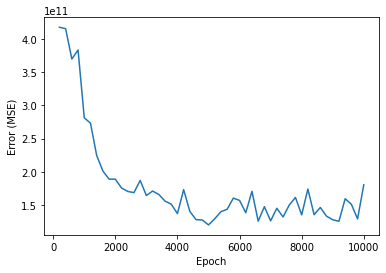

[284, 460]
Epoch: 200 MSE normalized: 0.0031238515 MSE: 423562084367.50714
Epoch: 400 MSE normalized: 0.0021687602 MSE: 423562083724.1134
Epoch: 600 MSE normalized: 0.0024239584 MSE: 423562083909.55927
Epoch: 800 MSE normalized: 0.0025016048 MSE: 423562084182.0608
Epoch: 1000 MSE normalized: 0.00197318 MSE: 423562083678.0255
Epoch: 1200 MSE normalized: 0.0023565071 MSE: 423562084367.50714
Epoch: 1400 MSE normalized: 0.0026991875 MSE: 423562082865.98895
Epoch: 1600 MSE normalized: 0.002774031 MSE: 423562082449.59076
Epoch: 1800 MSE normalized: 0.002419937 MSE: 423562083822.8511
Epoch: 2000 MSE normalized: 0.0018152524 MSE: 423562083451.61194
Epoch: 2200 MSE normalized: 0.0022614177 MSE: 423562083909.55927
Epoch: 2400 MSE normalized: 0.012730125 MSE: 423562082089.4539
Epoch: 2600 MSE normalized: 0.00236321 MSE: 423562083822.8511
Epoch: 2800 MSE normalized: 0.0027163017 MSE: 423562083133.3695
Epoch: 3000 MSE normalized: 0.0025299988 MSE: 423562083993.522
Epoch: 3200 MSE normalized: 0.0018

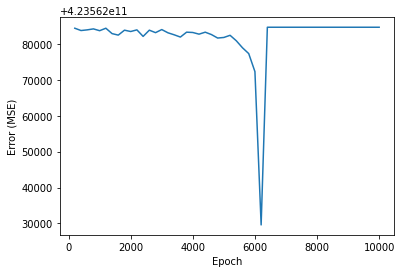

[216, 150]
Epoch: 200 MSE normalized: 0.0031194526 MSE: 423108059344.8231
Epoch: 400 MSE normalized: 0.0021648942 MSE: 423091892050.1687
Epoch: 600 MSE normalized: 0.0024210762 MSE: 423068207790.1414
Epoch: 800 MSE normalized: 0.0024998202 MSE: 423034278985.88385
Epoch: 1000 MSE normalized: 0.0019689957 MSE: 422987604625.30347
Epoch: 1200 MSE normalized: 0.0023522254 MSE: 422922212722.55835
Epoch: 1400 MSE normalized: 0.0026956329 MSE: 422824824013.8643
Epoch: 1600 MSE normalized: 0.0027692486 MSE: 422673626986.7608
Epoch: 1800 MSE normalized: 0.002416301 MSE: 422398793073.8729
Epoch: 2000 MSE normalized: 0.0018110031 MSE: 421804211342.5973
Epoch: 2200 MSE normalized: 0.0022421489 MSE: 419641773068.4826
Epoch: 2400 MSE normalized: 0.012737648 MSE: 394427771431.8959
Epoch: 2600 MSE normalized: 0.0019078815 MSE: 369275032005.9563
Epoch: 2800 MSE normalized: 0.001798516 MSE: 384782356975.8067
Epoch: 3000 MSE normalized: 0.0022062194 MSE: 390632109517.8443
Epoch: 3200 MSE normalized: 0.001

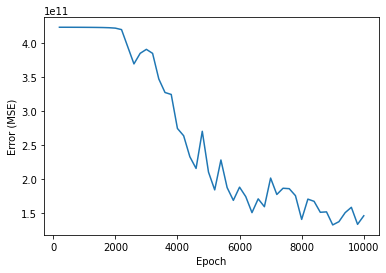

[266, 196]
Epoch: 200 MSE normalized: 0.0030858829 MSE: 414993851379.1757
Epoch: 400 MSE normalized: 0.00209223 MSE: 402862011402.1661
Epoch: 600 MSE normalized: 0.0021805607 MSE: 374014417691.49445
Epoch: 800 MSE normalized: 0.0020313445 MSE: 365789444742.9358
Epoch: 1000 MSE normalized: 0.0016573699 MSE: 336401390467.51984
Epoch: 1200 MSE normalized: 0.0015877553 MSE: 336310317310.88525
Epoch: 1400 MSE normalized: 0.0014824291 MSE: 318693196647.863
Epoch: 1600 MSE normalized: 0.0014133479 MSE: 275826818412.1556
Epoch: 1800 MSE normalized: 0.0010415487 MSE: 263107746694.15793
Epoch: 2000 MSE normalized: 0.00081718696 MSE: 314125743686.4599
Epoch: 2200 MSE normalized: 0.00076059403 MSE: 299412435782.1577
Epoch: 2400 MSE normalized: 0.010707993 MSE: 317908169154.03754
Epoch: 2600 MSE normalized: 0.0009874676 MSE: 285991396969.34595
Epoch: 2800 MSE normalized: 0.00092152477 MSE: 294311914873.2641
Epoch: 3000 MSE normalized: 0.00088383624 MSE: 309701788301.9044
Epoch: 3200 MSE normalized:

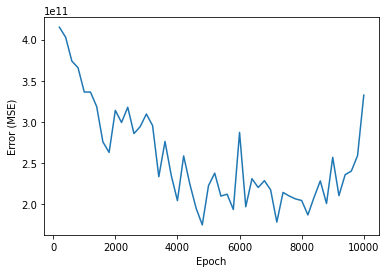

gen	nevals	avg        	std        	min        	max        
0  	5     	3.01226e+11	1.17983e+11	1.46224e+11	4.23562e+11
[174, 196]
Epoch: 200 MSE normalized: 0.0023767566 MSE: 527146656754.703
Epoch: 400 MSE normalized: 0.0013479755 MSE: 338520001066.1232
Epoch: 600 MSE normalized: 0.0011654288 MSE: 227422722665.87433
Epoch: 800 MSE normalized: 0.000957794 MSE: 215149435597.17825
Epoch: 1000 MSE normalized: 0.00058931427 MSE: 191394196899.70593
Epoch: 1200 MSE normalized: 0.00094965356 MSE: 169573616930.0367
Epoch: 1400 MSE normalized: 0.00067772204 MSE: 159317432456.62582
Epoch: 1600 MSE normalized: 0.0008148192 MSE: 175666436787.30692
Epoch: 1800 MSE normalized: 0.00047341167 MSE: 173361062126.1016
Epoch: 2000 MSE normalized: 0.00057379925 MSE: 208416961939.95203
Epoch: 2200 MSE normalized: 0.00085094123 MSE: 187208375175.36356
Epoch: 2400 MSE normalized: 0.00546646 MSE: 212090104846.66748
Epoch: 2600 MSE normalized: 0.0006467828 MSE: 171248323351.72516
Epoch: 2800 MSE normalized: 0.00

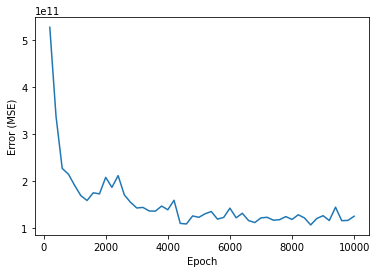

[266, 179]
Epoch: 200 MSE normalized: 0.003036831 MSE: 408572947251.94653
Epoch: 400 MSE normalized: 0.0020135404 MSE: 402487708604.4515
Epoch: 600 MSE normalized: 0.0018413872 MSE: 389528447631.8449
Epoch: 800 MSE normalized: 0.0018581538 MSE: 336076406712.0709
Epoch: 1000 MSE normalized: 0.0011607029 MSE: 310273311659.2635
Epoch: 1200 MSE normalized: 0.0015779719 MSE: 286057050672.23804
Epoch: 1400 MSE normalized: 0.0010600331 MSE: 256688571559.60858
Epoch: 1600 MSE normalized: 0.0014907538 MSE: 304659548314.1054
Epoch: 1800 MSE normalized: 0.0010632904 MSE: 258593039086.54807
Epoch: 2000 MSE normalized: 0.00073809904 MSE: 257332194344.57452
Epoch: 2200 MSE normalized: 0.00089718343 MSE: 233893962626.7276
Epoch: 2400 MSE normalized: 0.005762167 MSE: 260503621411.04688
Epoch: 2600 MSE normalized: 0.0014298969 MSE: 260706473263.39075
Epoch: 2800 MSE normalized: 0.0007702966 MSE: 245475810207.6648
Epoch: 3000 MSE normalized: 0.00080518716 MSE: 229120984072.59164
Epoch: 3200 MSE normaliz

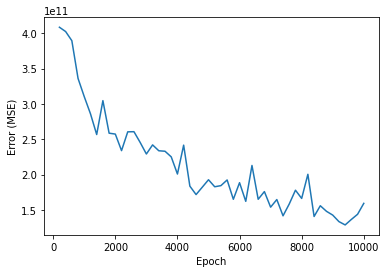

[216, 150]
Epoch: 200 MSE normalized: 0.003108044 MSE: 422889441251.5098
Epoch: 400 MSE normalized: 0.002153243 MSE: 422791632973.1979
Epoch: 600 MSE normalized: 0.002375155 MSE: 420658924501.62244
Epoch: 800 MSE normalized: 0.002310793 MSE: 421566458462.8393
Epoch: 1000 MSE normalized: 0.0020743809 MSE: 417155478578.931
Epoch: 1200 MSE normalized: 0.002213874 MSE: 403454711877.0366
Epoch: 1400 MSE normalized: 0.0023855756 MSE: 393958476451.19904
Epoch: 1600 MSE normalized: 0.002348358 MSE: 382098333732.15704
Epoch: 1800 MSE normalized: 0.0019908515 MSE: 372710737557.9103
Epoch: 2000 MSE normalized: 0.0014874131 MSE: 343731727808.8785
Epoch: 2200 MSE normalized: 0.0014062326 MSE: 396830858201.6586
Epoch: 2400 MSE normalized: 0.01151253 MSE: 428422804807.39825
Epoch: 2600 MSE normalized: 0.0016494399 MSE: 367672701335.42
Epoch: 2800 MSE normalized: 0.0014245677 MSE: 400694956171.6477
Epoch: 3000 MSE normalized: 0.0012011983 MSE: 448708936864.607
Epoch: 3200 MSE normalized: 0.001013743 M

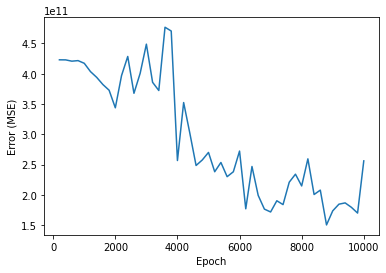

[216, 150]
Epoch: 200 MSE normalized: 0.0029421344 MSE: 404484897383.7565
Epoch: 400 MSE normalized: 0.001704613 MSE: 326807949151.7169
Epoch: 600 MSE normalized: 0.0014820466 MSE: 368353175895.80225
Epoch: 800 MSE normalized: 0.0015983328 MSE: 368177008174.641
Epoch: 1000 MSE normalized: 0.001116117 MSE: 259474766536.25662
Epoch: 1200 MSE normalized: 0.0009437565 MSE: 311631575173.05646
Epoch: 1400 MSE normalized: 0.0012686386 MSE: 265731911651.4341
Epoch: 1600 MSE normalized: 0.0013222847 MSE: 277653783202.3117
Epoch: 1800 MSE normalized: 0.0007909272 MSE: 252737215940.50024
Epoch: 2000 MSE normalized: 0.0005291069 MSE: 261135097117.72055
Epoch: 2200 MSE normalized: 0.0006335953 MSE: 206161533632.4716
Epoch: 2400 MSE normalized: 0.007737726 MSE: 240051713905.60443
Epoch: 2600 MSE normalized: 0.0009979192 MSE: 205858623510.66455
Epoch: 2800 MSE normalized: 0.0011194677 MSE: 186843102301.2619
Epoch: 3000 MSE normalized: 0.00050543284 MSE: 211498164233.10342
Epoch: 3200 MSE normalized: 

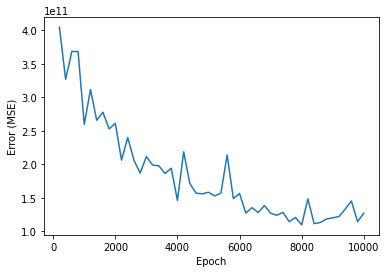

1  	4     	1.62932e+11	4.82568e+10	1.25943e+11	2.56185e+11
2  	0     	1.56272e+11	5.05497e+10	1.25943e+11	2.56185e+11
[174, 196]
Epoch: 200 MSE normalized: 0.003093911 MSE: 421481013358.57043
Epoch: 400 MSE normalized: 0.0021560297 MSE: 419419862460.15106
Epoch: 600 MSE normalized: 0.0020812368 MSE: 418332078675.0525
Epoch: 800 MSE normalized: 0.0016391914 MSE: 340696003237.0322
Epoch: 1000 MSE normalized: 0.0011462385 MSE: 254500844266.81995
Epoch: 1200 MSE normalized: 0.0008045736 MSE: 239550185762.0157
Epoch: 1400 MSE normalized: 0.0011952322 MSE: 227847478920.8445
Epoch: 1600 MSE normalized: 0.000878423 MSE: 209168545499.4969
Epoch: 1800 MSE normalized: 0.0005264507 MSE: 179197766095.968
Epoch: 2000 MSE normalized: 0.00056356075 MSE: 165093505083.41376
Epoch: 2200 MSE normalized: 0.00060931046 MSE: 164798510815.70062
Epoch: 2400 MSE normalized: 0.010349669 MSE: 179125636233.6881
Epoch: 2600 MSE normalized: 0.00067755557 MSE: 169569006118.47855
Epoch: 2800 MSE normalized: 0.00055324

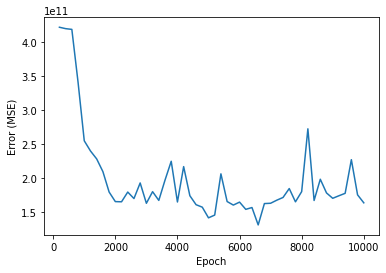

[174, 196]
Epoch: 200 MSE normalized: 0.0031019393 MSE: 448316319225.6956
Epoch: 400 MSE normalized: 0.002116153 MSE: 436883587017.2587
Epoch: 600 MSE normalized: 0.002379195 MSE: 434038223014.4554
Epoch: 800 MSE normalized: 0.0024452182 MSE: 478800098277.77466
Epoch: 1000 MSE normalized: 0.0018288649 MSE: 474358303414.77515
Epoch: 1200 MSE normalized: 0.002118516 MSE: 425652298542.5439
Epoch: 1400 MSE normalized: 0.0033965928 MSE: 366806819294.8443
Epoch: 1600 MSE normalized: 0.0017265778 MSE: 325480667893.79236
Epoch: 1800 MSE normalized: 0.0013558648 MSE: 287184068654.3674
Epoch: 2000 MSE normalized: 0.00080463535 MSE: 272833258922.30396
Epoch: 2200 MSE normalized: 0.0010364777 MSE: 242794226282.55545
Epoch: 2400 MSE normalized: 0.009289177 MSE: 255526695666.113
Epoch: 2600 MSE normalized: 0.0011059548 MSE: 269125778000.83752
Epoch: 2800 MSE normalized: 0.0012598771 MSE: 260046704974.2603
Epoch: 3000 MSE normalized: 0.0010247023 MSE: 249219826258.0001
Epoch: 3200 MSE normalized: 0.0

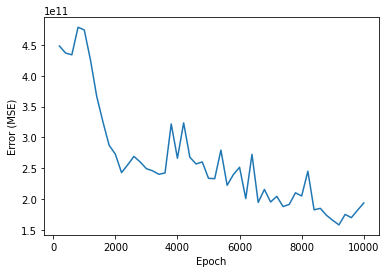

[216, 196]
Epoch: 200 MSE normalized: 0.0031174782 MSE: 425829307476.4454
Epoch: 400 MSE normalized: 0.0021598572 MSE: 426374794504.9306
Epoch: 600 MSE normalized: 0.0023771122 MSE: 426533257976.782
Epoch: 800 MSE normalized: 0.00248924 MSE: 427806042019.2888
Epoch: 1000 MSE normalized: 0.0018674976 MSE: 431065319379.5814
Epoch: 1200 MSE normalized: 0.0021775982 MSE: 437439170929.70844
Epoch: 1400 MSE normalized: 0.0025731167 MSE: 405189009757.4747
Epoch: 1600 MSE normalized: 0.002479131 MSE: 365958298153.17865
Epoch: 1800 MSE normalized: 0.0020658653 MSE: 352456230044.3684
Epoch: 2000 MSE normalized: 0.001686266 MSE: 331429454572.9957
Epoch: 2200 MSE normalized: 0.0015734113 MSE: 315135775086.82306
Epoch: 2400 MSE normalized: 0.010606962 MSE: 302020316103.83405
Epoch: 2600 MSE normalized: 0.0012264769 MSE: 292700701665.7043
Epoch: 2800 MSE normalized: 0.0011129287 MSE: 252711023637.62808
Epoch: 3000 MSE normalized: 0.0013016067 MSE: 249991793698.86365
Epoch: 3200 MSE normalized: 0.000

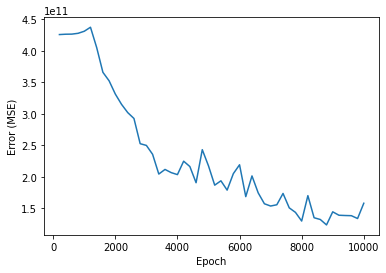

[174, 150]
Epoch: 200 MSE normalized: 0.0030902717 MSE: 416897965953.29114
Epoch: 400 MSE normalized: 0.002112061 MSE: 413971892235.1924
Epoch: 600 MSE normalized: 0.002380753 MSE: 410782797765.8664
Epoch: 800 MSE normalized: 0.0023880557 MSE: 405210080768.9902
Epoch: 1000 MSE normalized: 0.0018009283 MSE: 399498440139.5323
Epoch: 1200 MSE normalized: 0.0021487954 MSE: 395024522964.6664
Epoch: 1400 MSE normalized: 0.0018088531 MSE: 440483537907.4487
Epoch: 1600 MSE normalized: 0.0020756044 MSE: 376830318230.3481
Epoch: 1800 MSE normalized: 0.0018074703 MSE: 320869439362.7342
Epoch: 2000 MSE normalized: 0.0010326597 MSE: 306121582123.3318
Epoch: 2200 MSE normalized: 0.001433928 MSE: 305991552699.56573
Epoch: 2400 MSE normalized: 0.009651813 MSE: 287019547052.5166
Epoch: 2600 MSE normalized: 0.0011145321 MSE: 298548679717.2008
Epoch: 2800 MSE normalized: 0.0014161451 MSE: 252800197455.76608
Epoch: 3000 MSE normalized: 0.0009102678 MSE: 229170084664.02158
Epoch: 3200 MSE normalized: 0.000

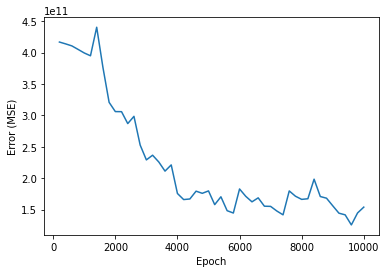

3  	4     	1.58971e+11	2.15565e+10	1.25943e+11	1.93438e+11
[174, 196]
Epoch: 200 MSE normalized: 0.0029728308 MSE: 403167358706.71643
Epoch: 400 MSE normalized: 0.0014155554 MSE: 326149326827.25854
Epoch: 600 MSE normalized: 0.001379509 MSE: 271885055581.63416
Epoch: 800 MSE normalized: 0.001170857 MSE: 232357835278.12134
Epoch: 1000 MSE normalized: 0.0009400816 MSE: 213748886579.8681
Epoch: 1200 MSE normalized: 0.0010186483 MSE: 217227411703.25232
Epoch: 1400 MSE normalized: 0.0009820986 MSE: 199719115617.88965
Epoch: 1600 MSE normalized: 0.00061445404 MSE: 197283911370.57977
Epoch: 1800 MSE normalized: 0.00066364853 MSE: 209810447730.2132
Epoch: 2000 MSE normalized: 0.00048525177 MSE: 217670055533.80545
Epoch: 2200 MSE normalized: 0.0005937518 MSE: 184088772311.21722
Epoch: 2400 MSE normalized: 0.009107312 MSE: 189027748957.84744
Epoch: 2600 MSE normalized: 0.00065405696 MSE: 185637617632.22403
Epoch: 2800 MSE normalized: 0.00059147616 MSE: 183413216036.63962
Epoch: 3000 MSE normaliz

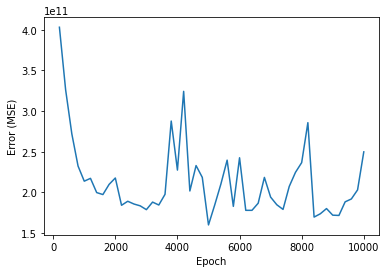

[216, 196]
Epoch: 200 MSE normalized: 0.0031176254 MSE: 421151901420.6625
Epoch: 400 MSE normalized: 0.0020746656 MSE: 410546198397.57465
Epoch: 600 MSE normalized: 0.0015250465 MSE: 294809111038.04333
Epoch: 800 MSE normalized: 0.0013698024 MSE: 346788413076.06744
Epoch: 1000 MSE normalized: 0.001091428 MSE: 300412940304.15796
Epoch: 1200 MSE normalized: 0.0011338829 MSE: 294701897806.6175
Epoch: 1400 MSE normalized: 0.00095572916 MSE: 280666033033.7521
Epoch: 1600 MSE normalized: 0.00091837725 MSE: 262875442423.7266
Epoch: 1800 MSE normalized: 0.0008108902 MSE: 227329689845.46527
Epoch: 2000 MSE normalized: 0.0006803495 MSE: 248740645382.56363
Epoch: 2200 MSE normalized: 0.0006456056 MSE: 203438261841.9661
Epoch: 2400 MSE normalized: 0.0051161856 MSE: 178032038620.32703
Epoch: 2600 MSE normalized: 0.0004304114 MSE: 187625802945.17496
Epoch: 2800 MSE normalized: 0.000703184 MSE: 209167309281.18225
Epoch: 3000 MSE normalized: 0.0005979525 MSE: 182123977332.05664
Epoch: 3200 MSE normali

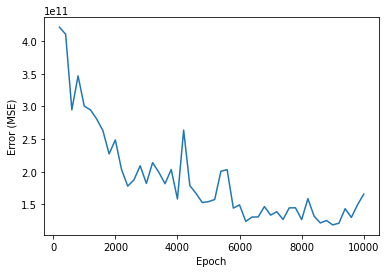

[174, 150]
Epoch: 200 MSE normalized: 0.002380373 MSE: 388221365408.76965
Epoch: 400 MSE normalized: 0.0014304671 MSE: 387016698096.4993
Epoch: 600 MSE normalized: 0.0012437608 MSE: 308976315529.1586
Epoch: 800 MSE normalized: 0.001276896 MSE: 283989984434.36584
Epoch: 1000 MSE normalized: 0.0006554768 MSE: 232838461306.32578
Epoch: 1200 MSE normalized: 0.00090450473 MSE: 212195234960.8518
Epoch: 1400 MSE normalized: 0.000846621 MSE: 225638412021.0932
Epoch: 1600 MSE normalized: 0.0007651041 MSE: 250964814362.09045
Epoch: 1800 MSE normalized: 0.0009867258 MSE: 174179654697.5137
Epoch: 2000 MSE normalized: 0.00057813805 MSE: 174184551394.27356
Epoch: 2200 MSE normalized: 0.00057156186 MSE: 168485785062.16382
Epoch: 2400 MSE normalized: 0.0033926072 MSE: 172606920058.27676
Epoch: 2600 MSE normalized: 0.000518971 MSE: 162605370005.1709
Epoch: 2800 MSE normalized: 0.0006199211 MSE: 161646300443.96506
Epoch: 3000 MSE normalized: 0.00063890236 MSE: 145361741927.6614
Epoch: 3200 MSE normalize

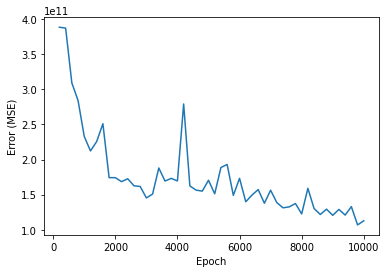

4  	3     	1.56065e+11	5.01448e+10	1.12787e+11	2.49817e+11
[216, 150]
Epoch: 200 MSE normalized: 0.0030779745 MSE: 439089876310.1987
Epoch: 400 MSE normalized: 0.002125419 MSE: 425526186499.1371
Epoch: 600 MSE normalized: 0.0023873183 MSE: 426140044113.7435
Epoch: 800 MSE normalized: 0.002449331 MSE: 426296874632.36395
Epoch: 1000 MSE normalized: 0.0018925718 MSE: 425249687330.1944
Epoch: 1200 MSE normalized: 0.0022622587 MSE: 417126027561.4024
Epoch: 1400 MSE normalized: 0.0026182893 MSE: 420423113696.5916
Epoch: 1600 MSE normalized: 0.0027372546 MSE: 419111532787.1321
Epoch: 1800 MSE normalized: 0.002257268 MSE: 420554080492.7816
Epoch: 2000 MSE normalized: 0.0012391887 MSE: 357065507091.8832
Epoch: 2200 MSE normalized: 0.0011864025 MSE: 278474015745.70984
Epoch: 2400 MSE normalized: 0.008839939 MSE: 219579750532.83194
Epoch: 2600 MSE normalized: 0.0011451368 MSE: 209305580908.96127
Epoch: 2800 MSE normalized: 0.0014891811 MSE: 184913300559.54858
Epoch: 3000 MSE normalized: 0.0009036

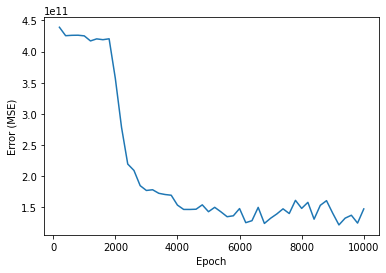

[174, 196]
Epoch: 200 MSE normalized: 0.0028036 MSE: 337846819071.43
Epoch: 400 MSE normalized: 0.0011238739 MSE: 315863201765.56586
Epoch: 600 MSE normalized: 0.0010878122 MSE: 293848693621.79315
Epoch: 800 MSE normalized: 0.0012261058 MSE: 230076563367.12225
Epoch: 1000 MSE normalized: 0.0008677946 MSE: 253780977323.3326
Epoch: 1200 MSE normalized: 0.0008623949 MSE: 230398899126.09244
Epoch: 1400 MSE normalized: 0.0007965185 MSE: 204158475654.56213
Epoch: 1600 MSE normalized: 0.0009952139 MSE: 218385557133.78436
Epoch: 1800 MSE normalized: 0.0008478268 MSE: 204955272549.98355
Epoch: 2000 MSE normalized: 0.0006590706 MSE: 239479524328.84793
Epoch: 2200 MSE normalized: 0.0005490513 MSE: 192622897496.77756
Epoch: 2400 MSE normalized: 0.0017425367 MSE: 245939669814.1488
Epoch: 2600 MSE normalized: 0.0010274377 MSE: 181769358838.64102
Epoch: 2800 MSE normalized: 0.00071477547 MSE: 152711004892.17978
Epoch: 3000 MSE normalized: 0.0007751911 MSE: 178106665379.06906
Epoch: 3200 MSE normalize

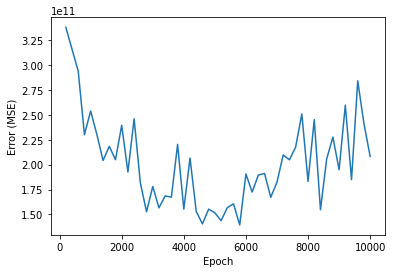

[174, 196]
Epoch: 200 MSE normalized: 0.0031166864 MSE: 422853847047.0864
Epoch: 400 MSE normalized: 0.0021614602 MSE: 422780711941.0822
Epoch: 600 MSE normalized: 0.0024157984 MSE: 422639282286.1709
Epoch: 800 MSE normalized: 0.0024966786 MSE: 422431447172.3629
Epoch: 1000 MSE normalized: 0.0019626238 MSE: 422014236149.7233
Epoch: 1200 MSE normalized: 0.0023167855 MSE: 421083665229.91016
Epoch: 1400 MSE normalized: 0.0026414227 MSE: 418560920637.8739
Epoch: 1600 MSE normalized: 0.0027044702 MSE: 418437272443.20337
Epoch: 1800 MSE normalized: 0.0023986285 MSE: 417842735698.56195
Epoch: 2000 MSE normalized: 0.0016835114 MSE: 419358631608.8042
Epoch: 2200 MSE normalized: 0.002219302 MSE: 425551104958.26074
Epoch: 2400 MSE normalized: 0.012471047 MSE: 431472747450.6857
Epoch: 2600 MSE normalized: 0.0021600823 MSE: 424254792251.3063
Epoch: 2800 MSE normalized: 0.002386677 MSE: 368995559823.95197
Epoch: 3000 MSE normalized: 0.0017852 MSE: 349202716119.4043
Epoch: 3200 MSE normalized: 0.0010

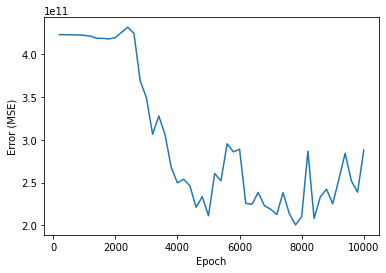

[174, 196]
Epoch: 200 MSE normalized: 0.003114949 MSE: 422902256238.33685
Epoch: 400 MSE normalized: 0.0019579672 MSE: 384679148967.1657
Epoch: 600 MSE normalized: 0.001719149 MSE: 314340025324.0218
Epoch: 800 MSE normalized: 0.0012569285 MSE: 230011260156.4943
Epoch: 1000 MSE normalized: 0.0011003526 MSE: 195061507406.16605
Epoch: 1200 MSE normalized: 0.000604777 MSE: 175774619592.06137
Epoch: 1400 MSE normalized: 0.0009839877 MSE: 168152839405.07208
Epoch: 1600 MSE normalized: 0.00084746553 MSE: 182263424168.75662
Epoch: 1800 MSE normalized: 0.0005945129 MSE: 288127564979.0934
Epoch: 2000 MSE normalized: 0.0006203736 MSE: 233790444935.58093
Epoch: 2200 MSE normalized: 0.0004226881 MSE: 206451437789.7734
Epoch: 2400 MSE normalized: 0.008311948 MSE: 177957963117.02118
Epoch: 2600 MSE normalized: 0.0008360012 MSE: 217051181612.16888
Epoch: 2800 MSE normalized: 0.0007282333 MSE: 222255180891.8936
Epoch: 3000 MSE normalized: 0.0005304829 MSE: 214815730648.74176
Epoch: 3200 MSE normalized:

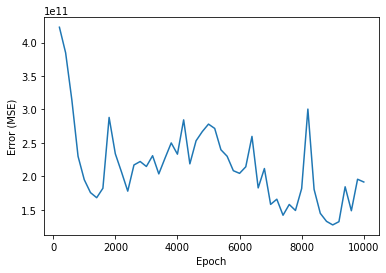

5  	4     	1.92251e+11	5.62059e+10	1.25943e+11	2.87905e+11
[83, 150]
Epoch: 200 MSE normalized: 0.0030749696 MSE: 418733156174.0784
Epoch: 400 MSE normalized: 0.0020424088 MSE: 422411928258.1055
Epoch: 600 MSE normalized: 0.002263396 MSE: 425642575493.0108
Epoch: 800 MSE normalized: 0.0022418452 MSE: 436021075736.4094
Epoch: 1000 MSE normalized: 0.0017589516 MSE: 447120030765.10443
Epoch: 1200 MSE normalized: 0.002037525 MSE: 452363315711.76
Epoch: 1400 MSE normalized: 0.0023674117 MSE: 456258215895.1968
Epoch: 1600 MSE normalized: 0.0022888903 MSE: 457325913069.43823
Epoch: 1800 MSE normalized: 0.0021976246 MSE: 441290775594.1211
Epoch: 2000 MSE normalized: 0.0012346611 MSE: 384706692072.80914
Epoch: 2200 MSE normalized: 0.0014174967 MSE: 319363128749.5226
Epoch: 2400 MSE normalized: 0.0112977065 MSE: 243709885115.89194
Epoch: 2600 MSE normalized: 0.0012484328 MSE: 217545292913.89224
Epoch: 2800 MSE normalized: 0.0013714364 MSE: 181660550148.64227
Epoch: 3000 MSE normalized: 0.0007859

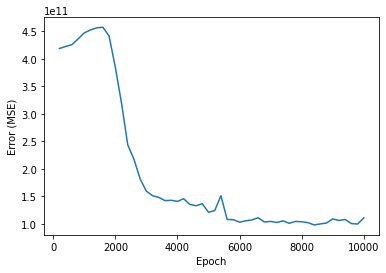

6  	1     	1.56901e+11	3.73489e+10	1.11152e+11	2.08196e+11
[97, 200, 31]


/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Epoch: 200 MSE normalized: 0.0013438655 MSE: 162822344908.66608
Epoch: 400 MSE normalized: 0.00056346686 MSE: 126843985279.22972
Epoch: 600 MSE normalized: 0.00054642407 MSE: 109357174297.58821
Epoch: 800 MSE normalized: 0.00051984884 MSE: 105329404038.33923
Epoch: 1000 MSE normalized: 0.00032075905 MSE: 99911182955.39516
Epoch: 1200 MSE normalized: 0.00039478653 MSE: 95745976022.71664
Epoch: 1400 MSE normalized: 0.00036886183 MSE: 97765820399.49138
Epoch: 1600 MSE normalized: 0.00047664187 MSE: 96119726230.41364
Epoch: 1800 MSE normalized: 0.0002857525 MSE: 98599969505.7319
Epoch: 2000 MSE normalized: 0.00028160712 MSE: 92314007074.40057
Epoch: 2200 MSE normalized: 0.00031974402 MSE: 93485166246.4708
Epoch: 2400 MSE normalized: 0.009172272 MSE: 91442388442.03798
Epoch: 2600 MSE normalized: 0.00043538763 MSE: 84094606718.67323
Epoch: 2800 MSE normalized: 0.00043548993 MSE: 88163271875.81903
Epoch: 3000 MSE normalized: 0.0003694621 MSE: 87815604845.41243
Epoch: 3200 MSE normalized: 0.00

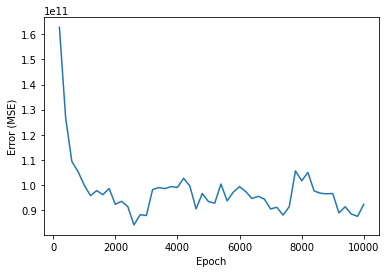

[271, 341, 51]
Epoch: 200 MSE normalized: 0.0025587762 MSE: 212998564610.0776
Epoch: 400 MSE normalized: 0.0007144296 MSE: 165023132163.79373
Epoch: 600 MSE normalized: 0.0005754792 MSE: 131143434322.23264
Epoch: 800 MSE normalized: 0.0006871108 MSE: 116568171638.23898
Epoch: 1000 MSE normalized: 0.00041057754 MSE: 108231732114.62233
Epoch: 1200 MSE normalized: 0.0003856898 MSE: 106442399264.48497
Epoch: 1400 MSE normalized: 0.00044160674 MSE: 103076151254.24284
Epoch: 1600 MSE normalized: 0.00035474286 MSE: 101588347401.2443
Epoch: 1800 MSE normalized: 0.0004222416 MSE: 100594868770.45876
Epoch: 2000 MSE normalized: 0.00026202225 MSE: 98511378784.66992
Epoch: 2200 MSE normalized: 0.00033560916 MSE: 95344581437.41197
Epoch: 2400 MSE normalized: 0.0063379174 MSE: 97643708669.6584
Epoch: 2600 MSE normalized: 0.00078718417 MSE: 102469302064.53172
Epoch: 2800 MSE normalized: 0.0004749476 MSE: 98604522928.76715
Epoch: 3000 MSE normalized: 0.00038127627 MSE: 111765645241.492
Epoch: 3200 MSE 

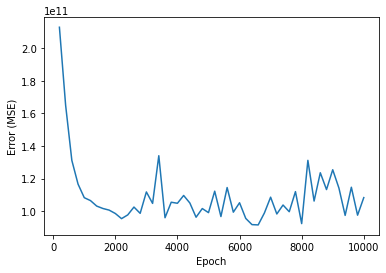

[32, 143, 43]
Epoch: 200 MSE normalized: 0.0019799038 MSE: 152882489268.1492
Epoch: 400 MSE normalized: 0.0008719833 MSE: 134381780758.98213
Epoch: 600 MSE normalized: 0.000545336 MSE: 124304261844.3927
Epoch: 800 MSE normalized: 0.0006739854 MSE: 117685268961.37762
Epoch: 1000 MSE normalized: 0.00044192316 MSE: 112712585492.30415
Epoch: 1200 MSE normalized: 0.00056528306 MSE: 108772869699.85872
Epoch: 1400 MSE normalized: 0.0005563814 MSE: 105794010053.8041
Epoch: 1600 MSE normalized: 0.00065498793 MSE: 102462951223.61363
Epoch: 1800 MSE normalized: 0.00047720704 MSE: 100104232717.86647
Epoch: 2000 MSE normalized: 0.00039779794 MSE: 98938081006.80925
Epoch: 2200 MSE normalized: 0.00062624103 MSE: 98423726380.06415
Epoch: 2400 MSE normalized: 0.009799929 MSE: 98984935607.44357
Epoch: 2600 MSE normalized: 0.00061129784 MSE: 99137202680.89151
Epoch: 2800 MSE normalized: 0.00088473735 MSE: 97406864692.8878
Epoch: 3000 MSE normalized: 0.0006118835 MSE: 96762771853.79184
Epoch: 3200 MSE nor

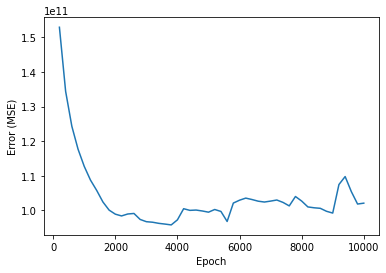

[26, 135, 354]
Epoch: 200 MSE normalized: 0.0031238412 MSE: 423522549220.23883
Epoch: 400 MSE normalized: 0.0021687595 MSE: 423513264968.70435
Epoch: 600 MSE normalized: 0.0024239584 MSE: 423490072631.07513
Epoch: 800 MSE normalized: 0.002501603 MSE: 423432374540.89923
Epoch: 1000 MSE normalized: 0.0025494152 MSE: 515252601532.1234
Epoch: 1200 MSE normalized: 0.0023565071 MSE: 423562084640.00867
Epoch: 1400 MSE normalized: 0.0026991875 MSE: 423562084640.00867
Epoch: 1600 MSE normalized: 0.002774031 MSE: 423562083642.4862
Epoch: 1800 MSE normalized: 0.002419937 MSE: 423562083642.4862
Epoch: 2000 MSE normalized: 0.0018152524 MSE: 423562083891.9457
Epoch: 2200 MSE normalized: 0.0022614177 MSE: 423562083642.4862
Epoch: 2400 MSE normalized: 0.012730125 MSE: 423562084390.54846
Epoch: 2600 MSE normalized: 0.00236321 MSE: 423562084640.00867
Epoch: 2800 MSE normalized: 0.0027163017 MSE: 423562083642.4862
Epoch: 3000 MSE normalized: 0.0025299988 MSE: 423562084640.00867
Epoch: 3200 MSE normalized

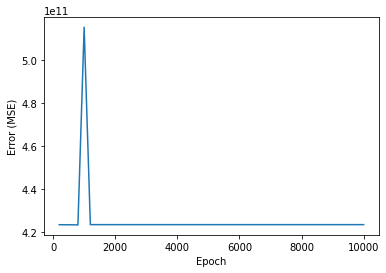

[187, 54, 440]
Epoch: 200 MSE normalized: 0.0031236582 MSE: 423499160530.688
Epoch: 400 MSE normalized: 0.0021686524 MSE: 423502058773.6176
Epoch: 600 MSE normalized: 0.0024239165 MSE: 423505567110.8499
Epoch: 800 MSE normalized: 0.002501407 MSE: 423494436383.7818
Epoch: 1000 MSE normalized: 0.0019719289 MSE: 423494649473.19336
Epoch: 1200 MSE normalized: 0.0023563353 MSE: 423493889345.76215
Epoch: 1400 MSE normalized: 0.0026989246 MSE: 423492469050.99194
Epoch: 1600 MSE normalized: 0.0027736747 MSE: 423490851638.81396
Epoch: 1800 MSE normalized: 0.0024181625 MSE: 423488021219.8723
Epoch: 2000 MSE normalized: 0.0018145309 MSE: 423484380014.4635
Epoch: 2200 MSE normalized: 0.002257666 MSE: 423479576822.6563
Epoch: 2400 MSE normalized: 0.012730023 MSE: 423473690999.3363
Epoch: 2600 MSE normalized: 0.0023628343 MSE: 423424270136.5405
Epoch: 2800 MSE normalized: 0.0027140786 MSE: 423408824945.19165
Epoch: 3000 MSE normalized: 0.0025292581 MSE: 423385912462.3773
Epoch: 3200 MSE normalized: 

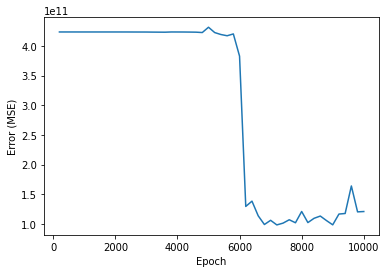

gen	nevals	avg        	std        	min       	max        
0  	5     	1.69403e+11	1.27415e+11	9.2288e+10	4.23562e+11
[97, 200, 51]
Epoch: 200 MSE normalized: 0.000686563 MSE: 103332806531.37541
Epoch: 400 MSE normalized: 0.0003782657 MSE: 96233018180.38261
Epoch: 600 MSE normalized: 0.00027067418 MSE: 93367989074.8871
Epoch: 800 MSE normalized: 0.00039462696 MSE: 87686210225.2231
Epoch: 1000 MSE normalized: 0.0002619657 MSE: 91580894721.87854
Epoch: 1200 MSE normalized: 0.00026940028 MSE: 92161156529.83714
Epoch: 1400 MSE normalized: 0.00036388062 MSE: 88908554006.64964
Epoch: 1600 MSE normalized: 0.0002736067 MSE: 92591662315.76707
Epoch: 1800 MSE normalized: 0.00033413543 MSE: 92805743168.65732
Epoch: 2000 MSE normalized: 0.0002949742 MSE: 96852643049.31657
Epoch: 2200 MSE normalized: 0.00027174858 MSE: 92552721690.39478
Epoch: 2400 MSE normalized: 0.009013643 MSE: 90773213589.79216
Epoch: 2600 MSE normalized: 0.00042784546 MSE: 101851348411.77435
Epoch: 2800 MSE normalized: 0.0002647

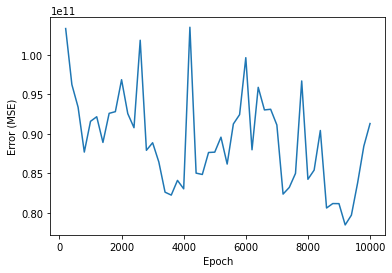

[271, 341, 31]
Epoch: 200 MSE normalized: 0.0012702909 MSE: 139062364230.41785
Epoch: 400 MSE normalized: 0.00048927293 MSE: 104813453136.61699
Epoch: 600 MSE normalized: 0.000375429 MSE: 102089044777.41121
Epoch: 800 MSE normalized: 0.0004724923 MSE: 98356509331.25676
Epoch: 1000 MSE normalized: 0.00024883766 MSE: 99864997681.85468
Epoch: 1200 MSE normalized: 0.0002891645 MSE: 102961237979.32314
Epoch: 1400 MSE normalized: 0.00041492248 MSE: 97103540452.11386
Epoch: 1600 MSE normalized: 0.00027432386 MSE: 96409255222.77028
Epoch: 1800 MSE normalized: 0.00045171604 MSE: 88686430709.33975
Epoch: 2000 MSE normalized: 0.00021297284 MSE: 94444480196.67343
Epoch: 2200 MSE normalized: 0.00029789153 MSE: 91561607481.01932
Epoch: 2400 MSE normalized: 0.00564885 MSE: 82020813414.07579
Epoch: 2600 MSE normalized: 0.0007966982 MSE: 87164532045.26166
Epoch: 2800 MSE normalized: 0.00027620044 MSE: 89574764119.93709
Epoch: 3000 MSE normalized: 0.00021224341 MSE: 87553696579.84006
Epoch: 3200 MSE nor

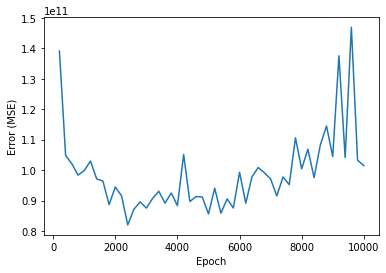

1  	2     	9.78528e+10	4.96301e+09	9.12991e+10	1.0211e+11 
2  	0     	9.35284e+10	3.98264e+09	9.12991e+10	1.01457e+11
[97, 200, 51]
Epoch: 200 MSE normalized: 0.0010509142 MSE: 134643756025.17963
Epoch: 400 MSE normalized: 0.00052704784 MSE: 115460049878.72064
Epoch: 600 MSE normalized: 0.00037885967 MSE: 109798046781.83063
Epoch: 800 MSE normalized: 0.0005074367 MSE: 115909026106.92867
Epoch: 1000 MSE normalized: 0.00026658174 MSE: 116827982269.38153
Epoch: 1200 MSE normalized: 0.00025234706 MSE: 114905122794.69063
Epoch: 1400 MSE normalized: 0.00035447252 MSE: 115496500624.42001
Epoch: 1600 MSE normalized: 0.0003414356 MSE: 111621664464.58788
Epoch: 1800 MSE normalized: 0.0002899918 MSE: 120957596012.56146
Epoch: 2000 MSE normalized: 0.00028715644 MSE: 105477968430.60657
Epoch: 2200 MSE normalized: 0.00045765095 MSE: 113603652684.14151
Epoch: 2400 MSE normalized: 0.007938974 MSE: 107604230258.41144
Epoch: 2600 MSE normalized: 0.0002963358 MSE: 105194586024.39873
Epoch: 2800 MSE norma

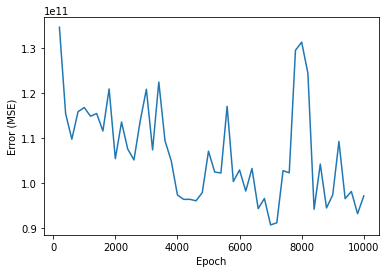

[97, 200, 51]
Epoch: 200 MSE normalized: 0.001588003 MSE: 258010948312.8464
Epoch: 400 MSE normalized: 0.0006922777 MSE: 171872282448.495
Epoch: 600 MSE normalized: 0.0006944595 MSE: 131289937960.62604
Epoch: 800 MSE normalized: 0.00048259553 MSE: 113614613569.90227
Epoch: 1000 MSE normalized: 0.00023457433 MSE: 108305045248.85864
Epoch: 1200 MSE normalized: 0.0003418135 MSE: 105262827318.2094
Epoch: 1400 MSE normalized: 0.00061557774 MSE: 109473831626.7881
Epoch: 1600 MSE normalized: 0.0005374204 MSE: 144302577247.8981
Epoch: 1800 MSE normalized: 0.00037699807 MSE: 109425033506.6213
Epoch: 2000 MSE normalized: 0.0002983171 MSE: 123478874970.97102
Epoch: 2200 MSE normalized: 0.0005070142 MSE: 109883172276.70422
Epoch: 2400 MSE normalized: 0.0054146377 MSE: 115468189453.12009
Epoch: 2600 MSE normalized: 0.0014166529 MSE: 104036839983.79988
Epoch: 2800 MSE normalized: 0.00026981262 MSE: 105266888852.44212
Epoch: 3000 MSE normalized: 0.00028413278 MSE: 151990029333.8852
Epoch: 3200 MSE no

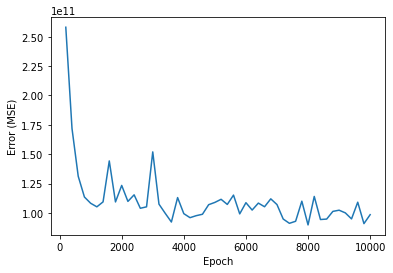

[97, 200, 51]
Epoch: 200 MSE normalized: 0.001968215 MSE: 257072150212.2983
Epoch: 400 MSE normalized: 0.0007805218 MSE: 164182010081.21643
Epoch: 600 MSE normalized: 0.0004460064 MSE: 121403903390.65994
Epoch: 800 MSE normalized: 0.00059476297 MSE: 106686464096.41505
Epoch: 1000 MSE normalized: 0.0003509374 MSE: 102194256639.28589
Epoch: 1200 MSE normalized: 0.00042879087 MSE: 98681897864.17111
Epoch: 1400 MSE normalized: 0.0005150951 MSE: 97425849831.16547
Epoch: 1600 MSE normalized: 0.000544239 MSE: 94639229821.6529
Epoch: 1800 MSE normalized: 0.00044458263 MSE: 95936102109.21236
Epoch: 2000 MSE normalized: 0.00035735045 MSE: 97212214267.43423
Epoch: 2200 MSE normalized: 0.00041186242 MSE: 93967826155.67552
Epoch: 2400 MSE normalized: 0.0094917035 MSE: 95693534609.1995
Epoch: 2600 MSE normalized: 0.000596398 MSE: 97304222726.36313
Epoch: 2800 MSE normalized: 0.00062824925 MSE: 97225121249.72699
Epoch: 3000 MSE normalized: 0.00041638993 MSE: 101019663340.18762
Epoch: 3200 MSE normali

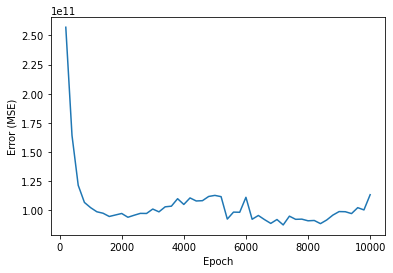

[97, 200, 51]
Epoch: 200 MSE normalized: 0.0011085566 MSE: 105353509303.96744
Epoch: 400 MSE normalized: 0.0003878124 MSE: 99479234815.32056
Epoch: 600 MSE normalized: 0.00034467838 MSE: 92358368254.22597
Epoch: 800 MSE normalized: 0.00047085583 MSE: 105180831184.61244
Epoch: 1000 MSE normalized: 0.0001915384 MSE: 91201321066.88345
Epoch: 1200 MSE normalized: 0.00031321752 MSE: 87026199270.09785
Epoch: 1400 MSE normalized: 0.00037064572 MSE: 87369374559.99486
Epoch: 1600 MSE normalized: 0.0003928329 MSE: 102514055911.4941
Epoch: 1800 MSE normalized: 0.00030728758 MSE: 88205034583.94606
Epoch: 2000 MSE normalized: 0.00019435195 MSE: 84228135025.33218
Epoch: 2200 MSE normalized: 0.0002795564 MSE: 91242151067.10999
Epoch: 2400 MSE normalized: 0.009705618 MSE: 88284591289.12277
Epoch: 2600 MSE normalized: 0.00020799637 MSE: 83803467805.64392
Epoch: 2800 MSE normalized: 0.00036869003 MSE: 84602673876.51598
Epoch: 3000 MSE normalized: 0.0003650196 MSE: 90595788231.19434
Epoch: 3200 MSE norma

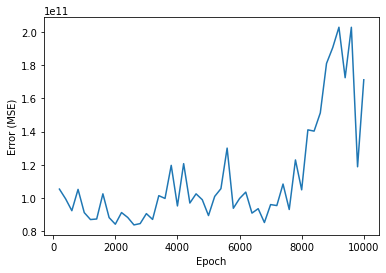

3  	4     	1.14312e+11	2.93247e+10	9.12991e+10	1.7114e+11 
[97, 200, 51]
Epoch: 200 MSE normalized: 0.00181135 MSE: 292234798904.6972
Epoch: 400 MSE normalized: 0.0009336205 MSE: 221768322879.32727
Epoch: 600 MSE normalized: 0.0009899782 MSE: 189083453108.5239
Epoch: 800 MSE normalized: 0.001172995 MSE: 169657246150.51346
Epoch: 1000 MSE normalized: 0.0005088513 MSE: 163840968602.9661
Epoch: 1200 MSE normalized: 0.00069201546 MSE: 150559581835.18683
Epoch: 1400 MSE normalized: 0.00060330256 MSE: 140229263653.34213
Epoch: 1600 MSE normalized: 0.0005505024 MSE: 135118238362.26741
Epoch: 1800 MSE normalized: 0.00062786095 MSE: 129033114962.36076
Epoch: 2000 MSE normalized: 0.00037187312 MSE: 125430041261.30766
Epoch: 2200 MSE normalized: 0.0005183081 MSE: 122185364099.6798
Epoch: 2400 MSE normalized: 0.007442881 MSE: 124271131640.89886
Epoch: 2600 MSE normalized: 0.0005604223 MSE: 121880118731.57274
Epoch: 2800 MSE normalized: 0.00073432224 MSE: 121205646243.29118
Epoch: 3000 MSE normaliz

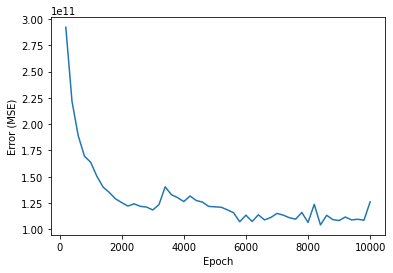

[97, 200, 51]
Epoch: 200 MSE normalized: 0.0023477033 MSE: 298856254290.5057
Epoch: 400 MSE normalized: 0.00092993176 MSE: 219629285058.5138
Epoch: 600 MSE normalized: 0.00066128845 MSE: 185240858904.15555
Epoch: 800 MSE normalized: 0.0010534556 MSE: 161375799908.37842
Epoch: 1000 MSE normalized: 0.00058811123 MSE: 151329230695.50705
Epoch: 1200 MSE normalized: 0.00046622715 MSE: 141059808313.79227
Epoch: 1400 MSE normalized: 0.000686274 MSE: 135424428818.14426
Epoch: 1600 MSE normalized: 0.00066823617 MSE: 135273766263.75175
Epoch: 1800 MSE normalized: 0.00026045265 MSE: 127709320962.40715
Epoch: 2000 MSE normalized: 0.00031836037 MSE: 123567186325.79024
Epoch: 2200 MSE normalized: 0.0004901338 MSE: 125569779516.82866
Epoch: 2400 MSE normalized: 0.00905377 MSE: 123665471919.86041
Epoch: 2600 MSE normalized: 0.00058569753 MSE: 121957231475.27553
Epoch: 2800 MSE normalized: 0.00059512194 MSE: 120101983164.54878
Epoch: 3000 MSE normalized: 0.00037308197 MSE: 122746447325.38347
Epoch: 320

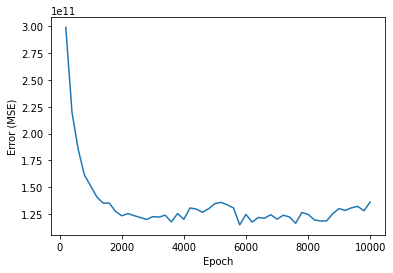

4  	2     	1.10821e+11	1.69854e+10	9.72048e+10	1.36344e+11
5  	0     	9.72048e+10	0          	9.72048e+10	9.72048e+10
[97, 200, 51]
Epoch: 200 MSE normalized: 0.0013330142 MSE: 153541638065.4587
Epoch: 400 MSE normalized: 0.00059092336 MSE: 127652206685.30067
Epoch: 600 MSE normalized: 0.0005508706 MSE: 117920321611.92421
Epoch: 800 MSE normalized: 0.00040252204 MSE: 118810486102.68712
Epoch: 1000 MSE normalized: 0.00038607352 MSE: 108333573290.3362
Epoch: 1200 MSE normalized: 0.00030327932 MSE: 104588578549.4303
Epoch: 1400 MSE normalized: 0.00038087886 MSE: 104210197777.08034
Epoch: 1600 MSE normalized: 0.0003744454 MSE: 101176813961.25972
Epoch: 1800 MSE normalized: 0.00037030928 MSE: 95374165524.16489
Epoch: 2000 MSE normalized: 0.00029885955 MSE: 91973093531.3934
Epoch: 2200 MSE normalized: 0.00037467256 MSE: 89574702242.81462
Epoch: 2400 MSE normalized: 0.008933161 MSE: 97248911088.4196
Epoch: 2600 MSE normalized: 0.0002824367 MSE: 93227490301.43335
Epoch: 2800 MSE normalized: 0.

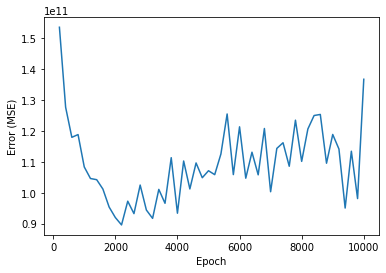

[97, 200, 51]
Epoch: 200 MSE normalized: 0.0020021948 MSE: 264794913277.83102
Epoch: 400 MSE normalized: 0.00082531775 MSE: 192461753193.30954
Epoch: 600 MSE normalized: 0.000732803 MSE: 160568268156.0126
Epoch: 800 MSE normalized: 0.0006795828 MSE: 152346706119.78036
Epoch: 1000 MSE normalized: 0.00032825395 MSE: 140591298112.71655
Epoch: 1200 MSE normalized: 0.0003829435 MSE: 142228324899.6861
Epoch: 1400 MSE normalized: 0.0005859422 MSE: 129170116953.98401
Epoch: 1600 MSE normalized: 0.0005646323 MSE: 134552252168.86107
Epoch: 1800 MSE normalized: 0.00053584354 MSE: 124396598569.78256
Epoch: 2000 MSE normalized: 0.00027522928 MSE: 134155243746.86893
Epoch: 2200 MSE normalized: 0.00037505833 MSE: 124244592586.0784
Epoch: 2400 MSE normalized: 0.00958839 MSE: 120148865088.14323
Epoch: 2600 MSE normalized: 0.0005279334 MSE: 121406260950.26959
Epoch: 2800 MSE normalized: 0.00036265142 MSE: 118388330307.27809
Epoch: 3000 MSE normalized: 0.00044464844 MSE: 121121746695.48639
Epoch: 3200 MS

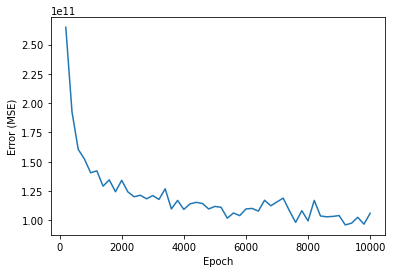

[97, 200, 51]
Epoch: 200 MSE normalized: 0.0013573176 MSE: 148991475439.67328
Epoch: 400 MSE normalized: 0.00042021702 MSE: 121940784403.51773
Epoch: 600 MSE normalized: 0.0004264747 MSE: 114568623627.28069
Epoch: 800 MSE normalized: 0.0005546356 MSE: 110712653023.57457
Epoch: 1000 MSE normalized: 0.0002957141 MSE: 112327280444.7223
Epoch: 1200 MSE normalized: 0.00036795746 MSE: 109060731811.432
Epoch: 1400 MSE normalized: 0.0003691702 MSE: 105443684258.91716
Epoch: 1600 MSE normalized: 0.00042026545 MSE: 110071856891.09328
Epoch: 1800 MSE normalized: 0.00031643742 MSE: 104694931176.19899
Epoch: 2000 MSE normalized: 0.00033000432 MSE: 125794639480.5215
Epoch: 2200 MSE normalized: 0.0003099913 MSE: 119662702306.91327
Epoch: 2400 MSE normalized: 0.004756857 MSE: 121215770686.86096
Epoch: 2600 MSE normalized: 0.0005881814 MSE: 140990277768.14673
Epoch: 2800 MSE normalized: 0.00075218774 MSE: 139062779890.0182
Epoch: 3000 MSE normalized: 0.00035739885 MSE: 146058580724.21555
Epoch: 3200 MS

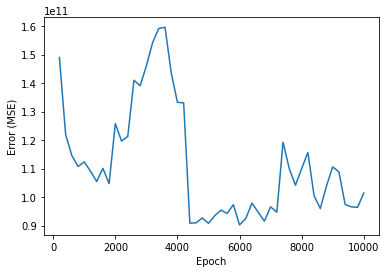

6  	3     	1.07718e+11	1.48586e+10	9.72048e+10	1.36707e+11
[242, 156, 179, 165]


/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Epoch: 200 MSE normalized: 0.0031134423 MSE: 421564147802.4229
Epoch: 400 MSE normalized: 0.0021386007 MSE: 420346066172.93835
Epoch: 600 MSE normalized: 0.002239692 MSE: 407896559500.4586
Epoch: 800 MSE normalized: 0.0013876726 MSE: 286168559171.49725
Epoch: 1000 MSE normalized: 0.0008339241 MSE: 205362573322.3552
Epoch: 1200 MSE normalized: 0.0006736886 MSE: 198116324438.71036
Epoch: 1400 MSE normalized: 0.00082187424 MSE: 186095545784.40012
Epoch: 1600 MSE normalized: 0.0005516446 MSE: 186240285201.2402
Epoch: 1800 MSE normalized: 0.00047072567 MSE: 150371668823.64435
Epoch: 2000 MSE normalized: 0.00028683883 MSE: 156264303610.6965
Epoch: 2200 MSE normalized: 0.000430748 MSE: 163520664172.4862
Epoch: 2400 MSE normalized: 0.0065113986 MSE: 137443841863.6695
Epoch: 2600 MSE normalized: 0.00089485757 MSE: 150791912847.09836
Epoch: 2800 MSE normalized: 0.00035779495 MSE: 124086839090.93857
Epoch: 3000 MSE normalized: 0.00027832837 MSE: 154021267380.2869
Epoch: 3200 MSE normalized: 0.000

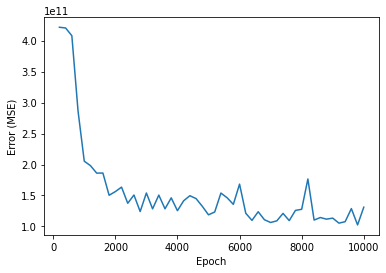

[26, 239, 418, 439]
Epoch: 200 MSE normalized: 0.0031238515 MSE: 423562084212.06415
Epoch: 400 MSE normalized: 0.0021687602 MSE: 423562084297.6744
Epoch: 600 MSE normalized: 0.0024239586 MSE: 423562084297.6744
Epoch: 800 MSE normalized: 0.0025016048 MSE: 423562084468.7866
Epoch: 1000 MSE normalized: 0.00197318 MSE: 423562084297.6744
Epoch: 1200 MSE normalized: 0.0023565071 MSE: 423562084468.7866
Epoch: 1400 MSE normalized: 0.0026991875 MSE: 423562084468.7866
Epoch: 1600 MSE normalized: 0.002774031 MSE: 423562084297.6744
Epoch: 1800 MSE normalized: 0.002419937 MSE: 423562084040.8441
Epoch: 2000 MSE normalized: 0.0018152524 MSE: 423562084212.06415
Epoch: 2200 MSE normalized: 0.0022614177 MSE: 423562084297.6744
Epoch: 2400 MSE normalized: 0.012730125 MSE: 423562084640.00867
Epoch: 2600 MSE normalized: 0.00236321 MSE: 423562084640.00867
Epoch: 2800 MSE normalized: 0.0027163017 MSE: 423562084640.00867
Epoch: 3000 MSE normalized: 0.0025299988 MSE: 423562084640.00867
Epoch: 3200 MSE normalize

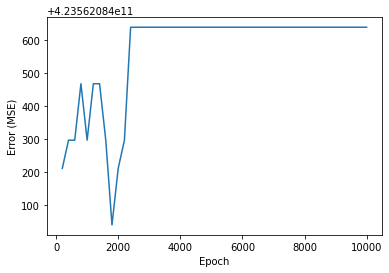

[387, 163, 152, 295]
Epoch: 200 MSE normalized: 0.0031238503 MSE: 423561877146.465
Epoch: 400 MSE normalized: 0.0021687574 MSE: 423561875792.72504
Epoch: 600 MSE normalized: 0.002423956 MSE: 423561865717.6003
Epoch: 800 MSE normalized: 0.0025016041 MSE: 423561869954.41705
Epoch: 1000 MSE normalized: 0.0019731785 MSE: 423561853835.3341
Epoch: 1200 MSE normalized: 0.0023565055 MSE: 423561866990.52655
Epoch: 1400 MSE normalized: 0.0026991866 MSE: 423561861527.82245
Epoch: 1600 MSE normalized: 0.0027740276 MSE: 423561866634.7669
Epoch: 1800 MSE normalized: 0.0024199367 MSE: 423561867566.21954
Epoch: 2000 MSE normalized: 0.0018152514 MSE: 423561863748.2918
Epoch: 2200 MSE normalized: 0.002261417 MSE: 423561866467.57196
Epoch: 2400 MSE normalized: 0.012730123 MSE: 423561862212.316
Epoch: 2600 MSE normalized: 0.0023632091 MSE: 423561860352.79144
Epoch: 2800 MSE normalized: 0.0027162984 MSE: 423561870834.9534
Epoch: 3000 MSE normalized: 0.002529998 MSE: 423561861092.74524
Epoch: 3200 MSE norma

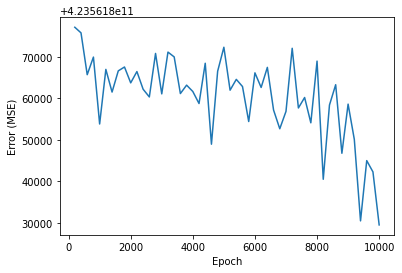

[289, 303, 182, 195]
Epoch: 200 MSE normalized: 0.0031238508 MSE: 423562003832.2883
Epoch: 400 MSE normalized: 0.0021687595 MSE: 423561991812.0153
Epoch: 600 MSE normalized: 0.0024239584 MSE: 423562002557.8396
Epoch: 800 MSE normalized: 0.0025016046 MSE: 423562000976.28864
Epoch: 1000 MSE normalized: 0.0019731782 MSE: 423562001012.52484
Epoch: 1200 MSE normalized: 0.0023565067 MSE: 423562002243.0078
Epoch: 1400 MSE normalized: 0.0026991868 MSE: 423562000217.0432
Epoch: 1600 MSE normalized: 0.00277403 MSE: 423561996395.04865
Epoch: 1800 MSE normalized: 0.002419937 MSE: 423562001152.4557
Epoch: 2000 MSE normalized: 0.0018152524 MSE: 423562002420.7132
Epoch: 2200 MSE normalized: 0.0022614175 MSE: 423562001840.21875
Epoch: 2400 MSE normalized: 0.012730125 MSE: 423562003926.2648
Epoch: 2600 MSE normalized: 0.0023632094 MSE: 423561990196.1718
Epoch: 2800 MSE normalized: 0.0027163017 MSE: 423562000283.8322
Epoch: 3000 MSE normalized: 0.0025299957 MSE: 423561998665.75385
Epoch: 3200 MSE normal

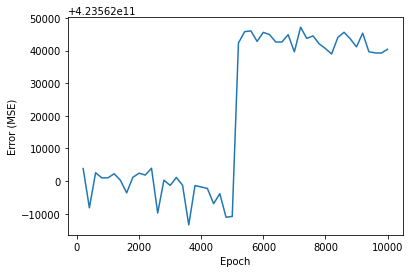

[117, 381, 420, 241]
Epoch: 200 MSE normalized: 0.0031238515 MSE: 423562059532.9367
Epoch: 400 MSE normalized: 0.0021687602 MSE: 423562058489.0766
Epoch: 600 MSE normalized: 0.0024239586 MSE: 423562059970.75415
Epoch: 800 MSE normalized: 0.0025016048 MSE: 423562056830.5157
Epoch: 1000 MSE normalized: 0.00197318 MSE: 423562059848.46735
Epoch: 1200 MSE normalized: 0.0023565071 MSE: 423562057705.9079
Epoch: 1400 MSE normalized: 0.0026991875 MSE: 423562057458.83875
Epoch: 1600 MSE normalized: 0.002774031 MSE: 423562057780.73517
Epoch: 1800 MSE normalized: 0.002419937 MSE: 423562058886.0783
Epoch: 2000 MSE normalized: 0.0018152524 MSE: 423562058836.7515
Epoch: 2200 MSE normalized: 0.0022614177 MSE: 423562059810.2527
Epoch: 2400 MSE normalized: 0.012730125 MSE: 423562057688.3664
Epoch: 2600 MSE normalized: 0.00236321 MSE: 423562058430.87683
Epoch: 2800 MSE normalized: 0.0027163017 MSE: 423562059038.5448
Epoch: 3000 MSE normalized: 0.0025299988 MSE: 423562058380.32996
Epoch: 3200 MSE normaliz

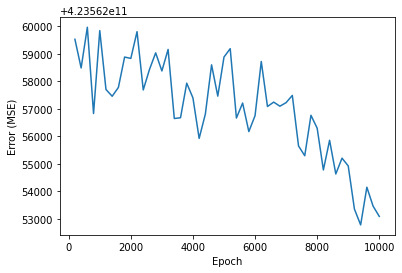

gen	nevals	avg        	std        	min        	max        
0  	5     	3.65068e+11	1.16988e+11	1.31093e+11	4.23562e+11
1  	0     	2.4808e+11 	1.4328e+11 	1.31093e+11	4.23562e+11
[242, 156, 179, 165]
Epoch: 200 MSE normalized: 0.0031177285 MSE: 422289338844.53534
Epoch: 400 MSE normalized: 0.0012812171 MSE: 279508044914.5812
Epoch: 600 MSE normalized: 0.0008021663 MSE: 162072828203.9082
Epoch: 800 MSE normalized: 0.00055933365 MSE: 152291289955.36096
Epoch: 1000 MSE normalized: 0.00029161142 MSE: 132630095955.00496
Epoch: 1200 MSE normalized: 0.000311325 MSE: 130083548267.69391
Epoch: 1400 MSE normalized: 0.0005254681 MSE: 135364911639.70494
Epoch: 1600 MSE normalized: 0.00037829392 MSE: 114151651939.09564
Epoch: 1800 MSE normalized: 0.00024925722 MSE: 115321494610.41609
Epoch: 2000 MSE normalized: 0.00024070838 MSE: 146783987438.58664
Epoch: 2200 MSE normalized: 0.0003586952 MSE: 113862362558.63998
Epoch: 2400 MSE normalized: 0.0062124073 MSE: 130849804508.33228
Epoch: 2600 MSE normaliz

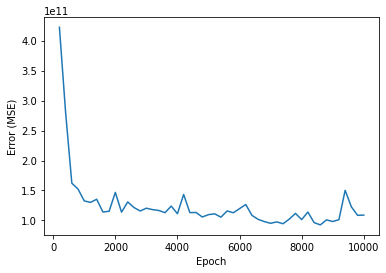

[242, 156, 179, 165]
Epoch: 200 MSE normalized: 0.0031232832 MSE: 423441078175.36395
Epoch: 400 MSE normalized: 0.002168169 MSE: 423434073106.26996
Epoch: 600 MSE normalized: 0.0024230606 MSE: 423429928563.8028
Epoch: 800 MSE normalized: 0.0025009979 MSE: 423420859748.2845
Epoch: 1000 MSE normalized: 0.001971806 MSE: 423415341219.1127
Epoch: 1200 MSE normalized: 0.0023555153 MSE: 423402403078.9294
Epoch: 1400 MSE normalized: 0.0026985195 MSE: 423388089556.3725
Epoch: 1600 MSE normalized: 0.0027729538 MSE: 423356579316.73236
Epoch: 1800 MSE normalized: 0.0024191171 MSE: 423319326349.01465
Epoch: 2000 MSE normalized: 0.0018101935 MSE: 422886495151.1269
Epoch: 2200 MSE normalized: 0.001756656 MSE: 293515394962.6311
Epoch: 2400 MSE normalized: 0.009508864 MSE: 121592450987.72435
Epoch: 2600 MSE normalized: 0.0005433385 MSE: 110982981937.0374
Epoch: 2800 MSE normalized: 0.0007953995 MSE: 110328338935.61519
Epoch: 3000 MSE normalized: 0.00046930835 MSE: 109265070662.7775
Epoch: 3200 MSE norm

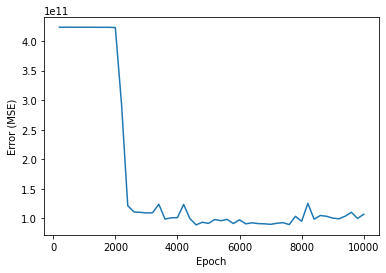

2  	2     	1.2187e+11 	1.1309e+10 	1.07148e+11	1.31093e+11
[242, 156, 179, 165]
Epoch: 200 MSE normalized: 0.0018510777 MSE: 270825418779.44263
Epoch: 400 MSE normalized: 0.00072256883 MSE: 151828632987.6958
Epoch: 600 MSE normalized: 0.00047110484 MSE: 137168341874.30492
Epoch: 800 MSE normalized: 0.00044795088 MSE: 126233900844.60797
Epoch: 1000 MSE normalized: 0.00025620588 MSE: 130547288047.0705
Epoch: 1200 MSE normalized: 0.00024476505 MSE: 102325623181.05055
Epoch: 1400 MSE normalized: 0.00024857957 MSE: 98263289816.9236
Epoch: 1600 MSE normalized: 0.00022899112 MSE: 103324171956.9503
Epoch: 1800 MSE normalized: 0.00024864048 MSE: 92116652483.8184
Epoch: 2000 MSE normalized: 0.00022905464 MSE: 87114833630.10591
Epoch: 2200 MSE normalized: 0.00040137 MSE: 88983863400.76465
Epoch: 2400 MSE normalized: 0.009033133 MSE: 95237858014.6409
Epoch: 2600 MSE normalized: 0.0003127354 MSE: 107708505411.86963
Epoch: 2800 MSE normalized: 0.0003251763 MSE: 92619169998.75276
Epoch: 3000 MSE norm

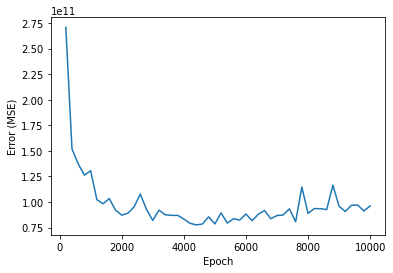

[242, 156, 179, 165]
Epoch: 200 MSE normalized: 0.0014995035 MSE: 239487904700.63498
Epoch: 400 MSE normalized: 0.00060849864 MSE: 159071257316.34003
Epoch: 600 MSE normalized: 0.00047746158 MSE: 138756272450.6143
Epoch: 800 MSE normalized: 0.0005210002 MSE: 158003483166.831
Epoch: 1000 MSE normalized: 0.00026077675 MSE: 143768469236.72757
Epoch: 1200 MSE normalized: 0.00035852057 MSE: 128678079477.16495
Epoch: 1400 MSE normalized: 0.000479966 MSE: 143009759469.1322
Epoch: 1600 MSE normalized: 0.00026678352 MSE: 153135918354.68747
Epoch: 1800 MSE normalized: 0.00034395943 MSE: 160570957795.58566
Epoch: 2000 MSE normalized: 0.0003374096 MSE: 207130394020.78098
Epoch: 2200 MSE normalized: 0.00037026565 MSE: 123486364296.74864
Epoch: 2400 MSE normalized: 0.00061090494 MSE: 106641054410.53926
Epoch: 2600 MSE normalized: 0.0002346747 MSE: 110118934839.49777
Epoch: 2800 MSE normalized: 0.00023644889 MSE: 108434904418.78674
Epoch: 3000 MSE normalized: 0.00040183353 MSE: 112120350513.98509
Epo

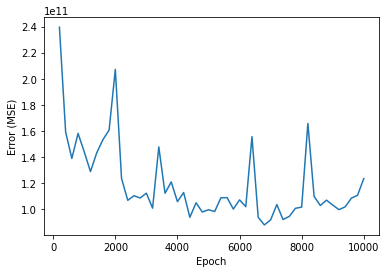

[242, 156, 179, 165]
Epoch: 200 MSE normalized: 0.0031224769 MSE: 423406926384.65753
Epoch: 400 MSE normalized: 0.002167611 MSE: 423401553387.2532
Epoch: 600 MSE normalized: 0.0024224324 MSE: 423396941954.4628
Epoch: 800 MSE normalized: 0.002500795 MSE: 423386213768.0471
Epoch: 1000 MSE normalized: 0.0019719417 MSE: 423377992008.22174
Epoch: 1200 MSE normalized: 0.0023553548 MSE: 423367027952.289
Epoch: 1400 MSE normalized: 0.002698279 MSE: 423352559579.3684
Epoch: 1600 MSE normalized: 0.0027721112 MSE: 423331122573.87885
Epoch: 1800 MSE normalized: 0.002417457 MSE: 423301604386.8186
Epoch: 2000 MSE normalized: 0.0018134988 MSE: 423257330012.40106
Epoch: 2200 MSE normalized: 0.0022582952 MSE: 423176132333.024
Epoch: 2400 MSE normalized: 0.012725472 MSE: 422963498011.5215
Epoch: 2600 MSE normalized: 0.0021991124 MSE: 376754105744.8371
Epoch: 2800 MSE normalized: 0.0012409517 MSE: 158622554289.63028
Epoch: 3000 MSE normalized: 0.0005144486 MSE: 124877911199.47417
Epoch: 3200 MSE normaliz

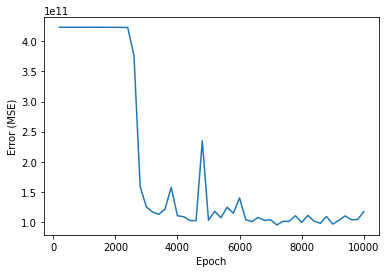

[242, 156, 179, 165]
Epoch: 200 MSE normalized: 0.0011080396 MSE: 161957144615.9937
Epoch: 400 MSE normalized: 0.00037039552 MSE: 143137100849.8807
Epoch: 600 MSE normalized: 0.00049728743 MSE: 152350763160.87372
Epoch: 800 MSE normalized: 0.0005731769 MSE: 146576364176.14954
Epoch: 1000 MSE normalized: 0.00020912456 MSE: 131445492450.35518
Epoch: 1200 MSE normalized: 0.00072986976 MSE: 135894100009.76407
Epoch: 1400 MSE normalized: 0.00038038314 MSE: 128341835524.86842
Epoch: 1600 MSE normalized: 0.0002781857 MSE: 138710764374.78543
Epoch: 1800 MSE normalized: 0.00032001437 MSE: 130531060356.67087
Epoch: 2000 MSE normalized: 0.00040088384 MSE: 150472509722.4896
Epoch: 2200 MSE normalized: 0.00041618393 MSE: 135298786415.62633
Epoch: 2400 MSE normalized: 0.002043485 MSE: 146372280367.9324
Epoch: 2600 MSE normalized: 0.00023838268 MSE: 174255750334.02347
Epoch: 2800 MSE normalized: 0.00032615237 MSE: 112712099481.22777
Epoch: 3000 MSE normalized: 0.0003493326 MSE: 143696826856.03534
Epo

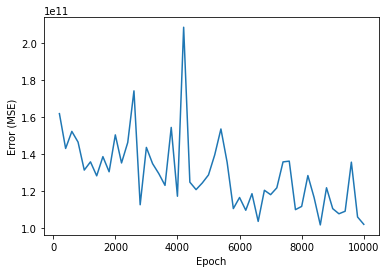

[54, 156, 24, 165]
Epoch: 200 MSE normalized: 0.0030553844 MSE: 411858622460.2464
Epoch: 400 MSE normalized: 0.0020684546 MSE: 407444977520.426
Epoch: 600 MSE normalized: 0.0022443242 MSE: 393755427876.12976
Epoch: 800 MSE normalized: 0.0008501442 MSE: 164088155386.90842
Epoch: 1000 MSE normalized: 0.00035839636 MSE: 136430528851.98167
Epoch: 1200 MSE normalized: 0.00055949116 MSE: 124041448494.55
Epoch: 1400 MSE normalized: 0.0006638095 MSE: 116948193078.40404
Epoch: 1600 MSE normalized: 0.0007189017 MSE: 111553755755.41664
Epoch: 1800 MSE normalized: 0.00060544943 MSE: 106985335806.05392
Epoch: 2000 MSE normalized: 0.00031452856 MSE: 101655764887.13408
Epoch: 2200 MSE normalized: 0.00053219707 MSE: 97435598872.14505
Epoch: 2400 MSE normalized: 0.009524364 MSE: 94566393415.81694
Epoch: 2600 MSE normalized: 0.000640331 MSE: 93387220685.0973
Epoch: 2800 MSE normalized: 0.0008129762 MSE: 92021754773.57274
Epoch: 3000 MSE normalized: 0.0005387623 MSE: 94215399170.03896
Epoch: 3200 MSE nor

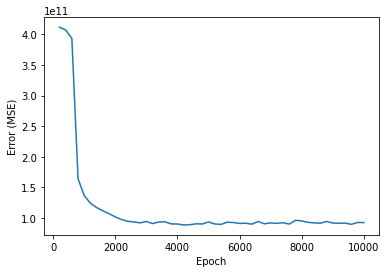

3  	5     	1.06209e+11	1.19778e+10	9.24062e+10	1.23324e+11
[242, 156, 179, 165]
Epoch: 200 MSE normalized: 0.0031227951 MSE: 423317823865.72003
Epoch: 400 MSE normalized: 0.0021673923 MSE: 423305668591.5116
Epoch: 600 MSE normalized: 0.0024219116 MSE: 423277250739.035
Epoch: 800 MSE normalized: 0.0024995897 MSE: 423251340352.047
Epoch: 1000 MSE normalized: 0.0019705056 MSE: 423220877893.516
Epoch: 1200 MSE normalized: 0.0023539409 MSE: 423177187548.4445
Epoch: 1400 MSE normalized: 0.0026963318 MSE: 423129379538.3606
Epoch: 1600 MSE normalized: 0.0027696684 MSE: 423044142225.63416
Epoch: 1800 MSE normalized: 0.002415235 MSE: 422914396139.14075
Epoch: 2000 MSE normalized: 0.0018100312 MSE: 422701460282.1424
Epoch: 2200 MSE normalized: 0.0022553497 MSE: 422204333508.7401
Epoch: 2400 MSE normalized: 0.012675263 MSE: 418038437924.42487
Epoch: 2600 MSE normalized: 0.0007538497 MSE: 145913443198.67108
Epoch: 2800 MSE normalized: 0.00056483544 MSE: 119100775410.89336
Epoch: 3000 MSE normalized

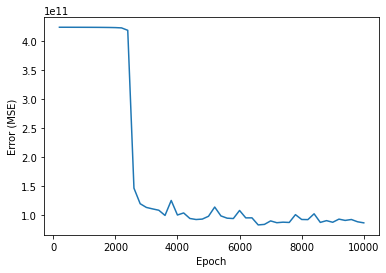

[242, 156, 179, 165]
Epoch: 200 MSE normalized: 0.0031197267 MSE: 423157119026.6782
Epoch: 400 MSE normalized: 0.0021647336 MSE: 423059255170.4892
Epoch: 600 MSE normalized: 0.0024210725 MSE: 422982728002.84186
Epoch: 800 MSE normalized: 0.0024979187 MSE: 422807123662.3541
Epoch: 1000 MSE normalized: 0.0019608384 MSE: 422508946307.2758
Epoch: 1200 MSE normalized: 0.00232238 MSE: 416690520745.2101
Epoch: 1400 MSE normalized: 0.0018633748 MSE: 340077062201.27826
Epoch: 1600 MSE normalized: 0.0016683035 MSE: 267931814963.8325
Epoch: 1800 MSE normalized: 0.00092154404 MSE: 222053744152.49954
Epoch: 2000 MSE normalized: 0.0008280778 MSE: 220776235047.6682
Epoch: 2200 MSE normalized: 0.0005064452 MSE: 194718729457.95496
Epoch: 2400 MSE normalized: 0.0010226351 MSE: 165838046720.2594
Epoch: 2600 MSE normalized: 0.0003444139 MSE: 165512264094.52283
Epoch: 2800 MSE normalized: 0.0003634321 MSE: 181591427872.33954
Epoch: 3000 MSE normalized: 0.0003603071 MSE: 193590670427.41806
Epoch: 3200 MSE n

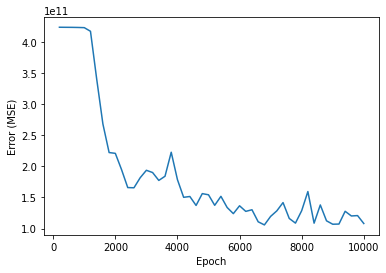

4  	2     	9.62444e+10	7.86134e+09	8.61135e+10	1.08178e+11
[242, 156, 24, 165]
Epoch: 200 MSE normalized: 0.0030071668 MSE: 399757012500.8824
Epoch: 400 MSE normalized: 0.0020278643 MSE: 389440333264.287
Epoch: 600 MSE normalized: 0.0019592086 MSE: 338812326516.54926
Epoch: 800 MSE normalized: 0.0006881068 MSE: 136484504830.66934
Epoch: 1000 MSE normalized: 0.00035925666 MSE: 122952835771.8823
Epoch: 1200 MSE normalized: 0.00048504077 MSE: 118486186259.49379
Epoch: 1400 MSE normalized: 0.00067982724 MSE: 108946595164.25362
Epoch: 1600 MSE normalized: 0.0005635706 MSE: 102620033604.29434
Epoch: 1800 MSE normalized: 0.0004456607 MSE: 108912368181.5692
Epoch: 2000 MSE normalized: 0.0003721169 MSE: 114321696711.13249
Epoch: 2200 MSE normalized: 0.00047766147 MSE: 112478078329.98132
Epoch: 2400 MSE normalized: 0.009589588 MSE: 106654526752.22063
Epoch: 2600 MSE normalized: 0.00036899812 MSE: 111684794721.4803
Epoch: 2800 MSE normalized: 0.00025846413 MSE: 100146228888.64838
Epoch: 3000 MSE 

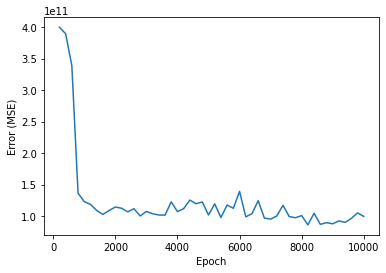

[54, 156, 179, 165]
Epoch: 200 MSE normalized: 0.003120038 MSE: 423264096686.5775
Epoch: 400 MSE normalized: 0.0021655355 MSE: 423171316660.9047
Epoch: 600 MSE normalized: 0.0024207088 MSE: 422800012511.5299
Epoch: 800 MSE normalized: 0.0024963552 MSE: 422485898325.0788
Epoch: 1000 MSE normalized: 0.0019638957 MSE: 421461115876.4892
Epoch: 1200 MSE normalized: 0.002277834 MSE: 407556228210.66724
Epoch: 1400 MSE normalized: 0.0022354163 MSE: 368277926744.36316
Epoch: 1600 MSE normalized: 0.0012574361 MSE: 220323884075.22534
Epoch: 1800 MSE normalized: 0.00094569044 MSE: 156081700467.28378
Epoch: 2000 MSE normalized: 0.00041143355 MSE: 164019424497.73697
Epoch: 2200 MSE normalized: 0.00050963036 MSE: 148175725869.12314
Epoch: 2400 MSE normalized: 0.009609939 MSE: 172076532742.43182
Epoch: 2600 MSE normalized: 0.0007028668 MSE: 159692841832.0166
Epoch: 2800 MSE normalized: 0.0008577432 MSE: 149406296896.27713
Epoch: 3000 MSE normalized: 0.0005910305 MSE: 145835343319.59732
Epoch: 3200 MSE

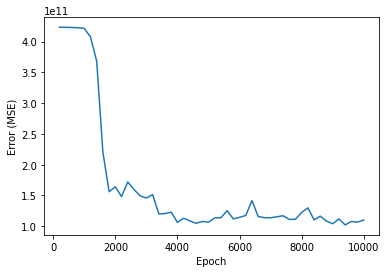

5  	2     	9.80446e+10	8.23313e+09	8.61135e+10	1.10137e+11
[242, 20, 179, 165]
Epoch: 200 MSE normalized: 0.00096244534 MSE: 130690679600.05777
Epoch: 400 MSE normalized: 0.00048315368 MSE: 128463243055.41791
Epoch: 600 MSE normalized: 0.0004980703 MSE: 117121200589.54292
Epoch: 800 MSE normalized: 0.00046710315 MSE: 104409166520.9028
Epoch: 1000 MSE normalized: 0.00035801233 MSE: 96476100166.53874
Epoch: 1200 MSE normalized: 0.0004774327 MSE: 110306005517.20818
Epoch: 1400 MSE normalized: 0.00044803187 MSE: 106499930759.27832
Epoch: 1600 MSE normalized: 0.00073191716 MSE: 113451529323.62393
Epoch: 1800 MSE normalized: 0.00034872198 MSE: 106723993875.30583
Epoch: 2000 MSE normalized: 0.0005742103 MSE: 113357686898.28221
Epoch: 2200 MSE normalized: 0.00035803113 MSE: 106150283571.93788
Epoch: 2400 MSE normalized: 0.009307456 MSE: 100648400657.33174
Epoch: 2600 MSE normalized: 0.0003765144 MSE: 99947618110.94748
Epoch: 2800 MSE normalized: 0.00029917277 MSE: 119019344085.18767
Epoch: 300

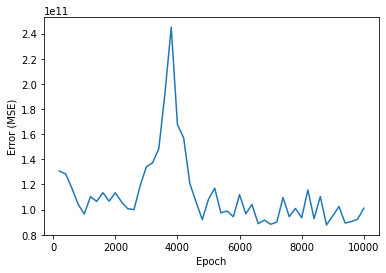

[242, 156, 179, 165]
Epoch: 200 MSE normalized: 0.0013230651 MSE: 187464859009.20142
Epoch: 400 MSE normalized: 0.00068357185 MSE: 170582920304.52756
Epoch: 600 MSE normalized: 0.00038159464 MSE: 138583659709.54468
Epoch: 800 MSE normalized: 0.00033723674 MSE: 128664638435.48242
Epoch: 1000 MSE normalized: 0.00031137498 MSE: 127286724597.13649
Epoch: 1200 MSE normalized: 0.00020336415 MSE: 122814361322.9134
Epoch: 1400 MSE normalized: 0.00036411546 MSE: 115744684540.52736
Epoch: 1600 MSE normalized: 0.00019643197 MSE: 113094781729.3237
Epoch: 1800 MSE normalized: 0.0005294461 MSE: 126426843398.09593
Epoch: 2000 MSE normalized: 0.00022947793 MSE: 113026262397.35825
Epoch: 2200 MSE normalized: 0.00034783193 MSE: 112634818585.07202
Epoch: 2400 MSE normalized: 0.0033767838 MSE: 128698010812.42241
Epoch: 2600 MSE normalized: 0.0013002723 MSE: 121728533346.54205
Epoch: 2800 MSE normalized: 0.00023680927 MSE: 114702580347.90195
Epoch: 3000 MSE normalized: 0.00025572182 MSE: 117707547550.84511

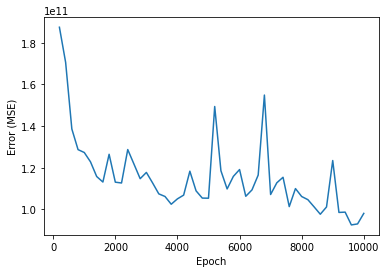

6  	2     	9.40018e+10	5.16245e+09	8.61135e+10	1.01052e+11
[461, 345, 80, 89, 182]


/home/erlantz/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/erlantz/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Epoch: 200 MSE normalized: 0.91669255 MSE: 152624344913046.28
Epoch: 400 MSE normalized: 0.91974294 MSE: 152624344865674.3
Epoch: 600 MSE normalized: 0.0024239565 MSE: 423561761086.53284
Epoch: 800 MSE normalized: 0.002501603 MSE: 423561766961.86743
Epoch: 1000 MSE normalized: 0.0019731782 MSE: 423561768518.21313
Epoch: 1200 MSE normalized: 0.002356505 MSE: 423561755252.73517
Epoch: 1400 MSE normalized: 0.002699186 MSE: 423561762153.49664
Epoch: 1600 MSE normalized: 0.0027740293 MSE: 423561761088.987
Epoch: 1800 MSE normalized: 0.002419935 MSE: 423561752087.4843
Epoch: 2000 MSE normalized: 0.0018152505 MSE: 423561760722.79987
Epoch: 2200 MSE normalized: 0.0022614156 MSE: 423561752432.32544
Epoch: 2400 MSE normalized: 0.012730122 MSE: 423561773101.60895
Epoch: 2600 MSE normalized: 0.0023632084 MSE: 423561764054.876
Epoch: 2800 MSE normalized: 0.0027163005 MSE: 423561761103.3492
Epoch: 3000 MSE normalized: 0.002529996 MSE: 423561753539.6797
Epoch: 3200 MSE normalized: 0.001856043 MSE: 42

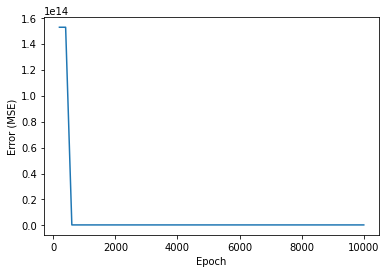

[493, 31, 113, 395, 84]
Epoch: 200 MSE normalized: 0.0020339792 MSE: 213038703199.34277
Epoch: 400 MSE normalized: 0.00067827315 MSE: 148781222755.92535
Epoch: 600 MSE normalized: 0.00057871366 MSE: 126618847109.5966
Epoch: 800 MSE normalized: 0.00039072265 MSE: 118971931251.86798
Epoch: 1000 MSE normalized: 0.00034880175 MSE: 120138693898.90273
Epoch: 1200 MSE normalized: 0.00052949996 MSE: 126919360113.76576
Epoch: 1400 MSE normalized: 0.00045518906 MSE: 124964723479.00005
Epoch: 1600 MSE normalized: 0.00053696113 MSE: 136186564601.61424
Epoch: 1800 MSE normalized: 0.00038454216 MSE: 132437142349.21165
Epoch: 2000 MSE normalized: 0.00035411346 MSE: 124801692019.9475
Epoch: 2200 MSE normalized: 0.00043829216 MSE: 104570021104.78032
Epoch: 2400 MSE normalized: 0.008758951 MSE: 106230140866.16058
Epoch: 2600 MSE normalized: 0.0002921659 MSE: 112923945643.43883
Epoch: 2800 MSE normalized: 0.00030922965 MSE: 118982880531.00056
Epoch: 3000 MSE normalized: 0.00033989127 MSE: 109288075533.80

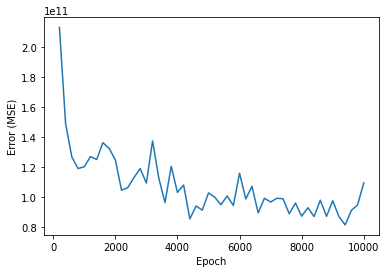

[29, 192, 473, 331, 118]
Epoch: 200 MSE normalized: 0.001212261 MSE: 126635187376.55406
Epoch: 400 MSE normalized: 0.000398927 MSE: 112483556099.67598
Epoch: 600 MSE normalized: 0.0005379591 MSE: 115033693437.46848
Epoch: 800 MSE normalized: 0.00067763776 MSE: 112291621476.74425
Epoch: 1000 MSE normalized: 0.00033362154 MSE: 108244727285.51399
Epoch: 1200 MSE normalized: 0.0005095591 MSE: 108071756298.11163
Epoch: 1400 MSE normalized: 0.0004322905 MSE: 107970639553.04518
Epoch: 1600 MSE normalized: 0.0006223786 MSE: 110729923091.98875
Epoch: 1800 MSE normalized: 0.00051891815 MSE: 110769431949.95828
Epoch: 2000 MSE normalized: 0.00035303857 MSE: 112351437119.55684
Epoch: 2200 MSE normalized: 0.00052435836 MSE: 111116320784.26578
Epoch: 2400 MSE normalized: 0.009996364 MSE: 115117168767.97891
Epoch: 2600 MSE normalized: 0.0007467933 MSE: 112520740747.05482
Epoch: 2800 MSE normalized: 0.0009677048 MSE: 111523905636.39507
Epoch: 3000 MSE normalized: 0.0006105457 MSE: 109571967529.88744
Ep

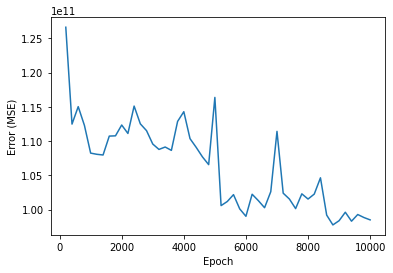

[42, 231, 350, 51, 377]
Epoch: 200 MSE normalized: 0.0031238403 MSE: 423556244575.0018
Epoch: 400 MSE normalized: 0.0021687492 MSE: 423554240528.43506
Epoch: 600 MSE normalized: 0.0024239216 MSE: 423548248884.982
Epoch: 800 MSE normalized: 0.0025015238 MSE: 423526094674.1824
Epoch: 1000 MSE normalized: 0.0019730087 MSE: 422595527387.34576
Epoch: 1200 MSE normalized: 0.0005086973 MSE: 122628210293.38452
Epoch: 1400 MSE normalized: 0.00053396734 MSE: 106935532982.14693
Epoch: 1600 MSE normalized: 0.0005969274 MSE: 108817053343.45697
Epoch: 1800 MSE normalized: 0.000642474 MSE: 124224822378.71368
Epoch: 2000 MSE normalized: 0.0002885158 MSE: 103131984503.42491
Epoch: 2200 MSE normalized: 0.00054493034 MSE: 127556791203.63042
Epoch: 2400 MSE normalized: 0.009666514 MSE: 102628010424.96883
Epoch: 2600 MSE normalized: 0.00041883616 MSE: 102511288120.11484
Epoch: 2800 MSE normalized: 0.000883071 MSE: 109551237704.70714
Epoch: 3000 MSE normalized: 0.00044158296 MSE: 94604891510.919
Epoch: 3200

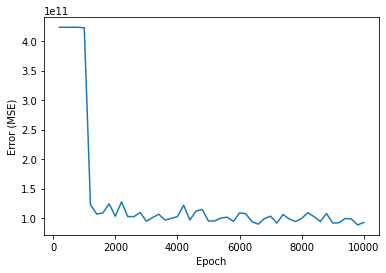

[179, 427, 219, 486, 46]
Epoch: 200 MSE normalized: 0.0009179945 MSE: 166891928652.64307
Epoch: 400 MSE normalized: 0.0004096409 MSE: 123427064461.08296
Epoch: 600 MSE normalized: 0.00046455505 MSE: 112375386496.95732
Epoch: 800 MSE normalized: 0.00040840582 MSE: 119919738089.22054
Epoch: 1000 MSE normalized: 0.00022517942 MSE: 118862863152.05911
Epoch: 1200 MSE normalized: 0.00043713616 MSE: 139996042324.2957
Epoch: 1400 MSE normalized: 0.00029795375 MSE: 106137713711.41675
Epoch: 1600 MSE normalized: 0.0001991456 MSE: 158167238719.87595
Epoch: 1800 MSE normalized: 0.0005349131 MSE: 107572402584.41505
Epoch: 2000 MSE normalized: 0.00020117292 MSE: 115655369667.72627
Epoch: 2200 MSE normalized: 0.00038722373 MSE: 104069798999.21498
Epoch: 2400 MSE normalized: 0.007098492 MSE: 119583450655.05827
Epoch: 2600 MSE normalized: 0.00043498102 MSE: 93604660568.64122
Epoch: 2800 MSE normalized: 0.00022960629 MSE: 109135696478.83786
Epoch: 3000 MSE normalized: 0.00029780116 MSE: 100932088070.962

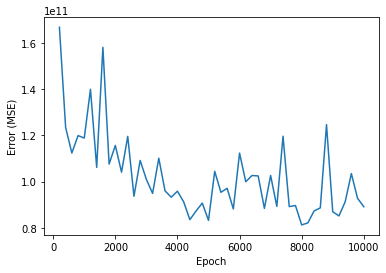

gen	nevals	avg        	std        	min        	max        
0  	5     	1.62631e+11	1.30647e+11	8.90933e+10	4.23562e+11
[179, 427, 219, 486, 377]
Epoch: 200 MSE normalized: 0.0031238508 MSE: 423562062671.1163
Epoch: 400 MSE normalized: 0.0021687602 MSE: 423562084640.00867
Epoch: 600 MSE normalized: 0.0024239586 MSE: 423562084640.00867
Epoch: 800 MSE normalized: 0.0025016048 MSE: 423562084640.00867
Epoch: 1000 MSE normalized: 0.00197318 MSE: 423562084640.00867
Epoch: 1200 MSE normalized: 0.0023565071 MSE: 423562084640.00867
Epoch: 1400 MSE normalized: 0.0026991875 MSE: 423562084640.00867
Epoch: 1600 MSE normalized: 0.002774031 MSE: 423562084640.00867
Epoch: 1800 MSE normalized: 0.002419937 MSE: 423562084640.00867
Epoch: 2000 MSE normalized: 0.0018152524 MSE: 423562084640.00867
Epoch: 2200 MSE normalized: 0.0022614177 MSE: 423562084640.00867
Epoch: 2400 MSE normalized: 0.012730125 MSE: 423562084640.00867
Epoch: 2600 MSE normalized: 0.00236321 MSE: 423562084640.00867
Epoch: 2800 MSE normali

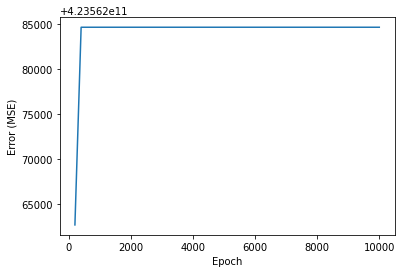

[42, 231, 350, 51, 46]
Epoch: 200 MSE normalized: 0.001584746 MSE: 181063365035.33707
Epoch: 400 MSE normalized: 0.00041249473 MSE: 122092382858.37521
Epoch: 600 MSE normalized: 0.00042120382 MSE: 128484194343.01057
Epoch: 800 MSE normalized: 0.00046872016 MSE: 130995142484.98235
Epoch: 1000 MSE normalized: 0.000292059 MSE: 119217850425.0633
Epoch: 1200 MSE normalized: 0.0003836468 MSE: 111721394346.00406
Epoch: 1400 MSE normalized: 0.0006142641 MSE: 108509942153.0071
Epoch: 1600 MSE normalized: 0.0005038481 MSE: 107985976738.25978
Epoch: 1800 MSE normalized: 0.00040381646 MSE: 104047751641.76636
Epoch: 2000 MSE normalized: 0.00030998362 MSE: 96522284484.02284
Epoch: 2200 MSE normalized: 0.00031293716 MSE: 94085493111.82002
Epoch: 2400 MSE normalized: 0.009470913 MSE: 109994673066.56343
Epoch: 2600 MSE normalized: 0.00030338275 MSE: 122139086676.14236
Epoch: 2800 MSE normalized: 0.00034295663 MSE: 126705347075.04143
Epoch: 3000 MSE normalized: 0.0005048928 MSE: 123360623659.74474
Epoch

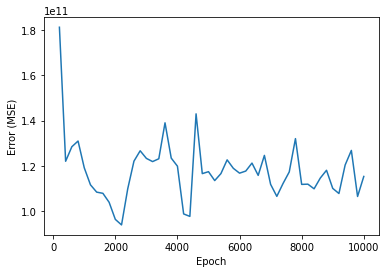

[179, 427, 219, 486, 16]
Epoch: 200 MSE normalized: 0.0012333408 MSE: 136150172088.1283
Epoch: 400 MSE normalized: 0.0004593553 MSE: 111779067606.8322
Epoch: 600 MSE normalized: 0.0003992676 MSE: 99186434594.47057
Epoch: 800 MSE normalized: 0.00041479376 MSE: 93184888751.07626
Epoch: 1000 MSE normalized: 0.00024094853 MSE: 94617010330.1941
Epoch: 1200 MSE normalized: 0.00022840957 MSE: 90818285512.39912
Epoch: 1400 MSE normalized: 0.00029428187 MSE: 89119452440.79242
Epoch: 1600 MSE normalized: 0.00036009878 MSE: 87703441045.61256
Epoch: 1800 MSE normalized: 0.00022373316 MSE: 88374072533.71205
Epoch: 2000 MSE normalized: 0.00024413776 MSE: 87666973952.84172
Epoch: 2200 MSE normalized: 0.00030968286 MSE: 91125125946.20049
Epoch: 2400 MSE normalized: 0.008082438 MSE: 97758699319.64624
Epoch: 2600 MSE normalized: 0.00025860377 MSE: 111131156988.74428
Epoch: 2800 MSE normalized: 0.00030229776 MSE: 93370719759.96968
Epoch: 3000 MSE normalized: 0.00021637265 MSE: 90013424876.41855
Epoch: 32

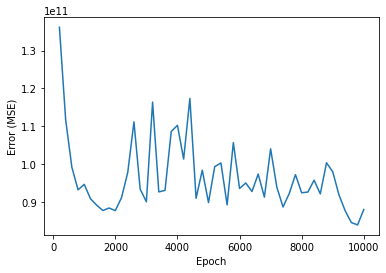

1  	3     	1.61025e+11	1.31675e+11	8.79693e+10	4.23562e+11
[179, 427, 219, 486, 46]
Epoch: 200 MSE normalized: 0.0010115944 MSE: 102641349989.92638
Epoch: 400 MSE normalized: 0.0003602879 MSE: 92935663779.85236
Epoch: 600 MSE normalized: 0.00029724825 MSE: 86511521318.28706
Epoch: 800 MSE normalized: 0.00029931407 MSE: 95294287699.7755
Epoch: 1000 MSE normalized: 0.00023392508 MSE: 91798795288.05981
Epoch: 1200 MSE normalized: 0.00023865241 MSE: 95820775421.54541
Epoch: 1400 MSE normalized: 0.00038099883 MSE: 95143124080.55576
Epoch: 1600 MSE normalized: 0.00033456777 MSE: 107462934426.95245
Epoch: 1800 MSE normalized: 0.00024170414 MSE: 101231623775.73474
Epoch: 2000 MSE normalized: 0.00017997745 MSE: 93854800400.5613
Epoch: 2200 MSE normalized: 0.0003030723 MSE: 89894587979.26547
Epoch: 2400 MSE normalized: 0.0051592696 MSE: 85045706306.8389
Epoch: 2600 MSE normalized: 0.0002427217 MSE: 109872834724.56741
Epoch: 2800 MSE normalized: 0.00021923248 MSE: 95220189693.94566
Epoch: 3000 MS

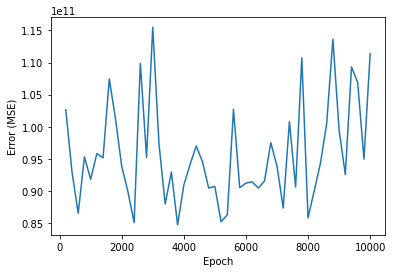

[179, 427, 219, 486, 16]
Epoch: 200 MSE normalized: 0.00087587244 MSE: 115043963547.73041
Epoch: 400 MSE normalized: 0.00029945615 MSE: 103822797749.52309
Epoch: 600 MSE normalized: 0.00037604326 MSE: 102270356623.3613
Epoch: 800 MSE normalized: 0.0002989536 MSE: 96076475642.21202
Epoch: 1000 MSE normalized: 0.0001771863 MSE: 89806991713.72234
Epoch: 1200 MSE normalized: 0.00042552323 MSE: 101584465716.91129
Epoch: 1400 MSE normalized: 0.00024048917 MSE: 110239589397.90335
Epoch: 1600 MSE normalized: 0.00021518784 MSE: 91043676429.14847
Epoch: 1800 MSE normalized: 0.00023796788 MSE: 95829807728.22464
Epoch: 2000 MSE normalized: 0.00016880313 MSE: 92769376736.29755
Epoch: 2200 MSE normalized: 0.00019159056 MSE: 94339439842.7604
Epoch: 2400 MSE normalized: 0.0063934787 MSE: 91350038555.57146
Epoch: 2600 MSE normalized: 0.00016913521 MSE: 93461769893.45903
Epoch: 2800 MSE normalized: 0.00024773667 MSE: 109760621922.74773
Epoch: 3000 MSE normalized: 0.0001616369 MSE: 105214217654.91368
Epo

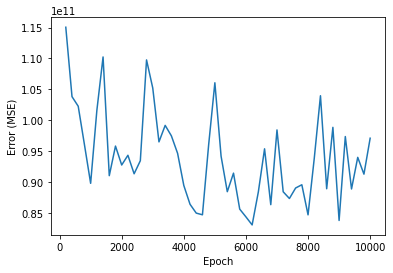

[179, 427, 219, 486, 16]
Epoch: 200 MSE normalized: 0.0013357557 MSE: 146518598083.37476
Epoch: 400 MSE normalized: 0.0004820998 MSE: 131348865637.8929
Epoch: 600 MSE normalized: 0.0006016832 MSE: 127735629187.26329
Epoch: 800 MSE normalized: 0.0006725903 MSE: 123885550707.72774
Epoch: 1000 MSE normalized: 0.0003191556 MSE: 114426941305.35089
Epoch: 1200 MSE normalized: 0.00042813554 MSE: 108864100840.00693
Epoch: 1400 MSE normalized: 0.00055828167 MSE: 105418371371.01201
Epoch: 1600 MSE normalized: 0.00057043636 MSE: 100034290721.65344
Epoch: 1800 MSE normalized: 0.00043053165 MSE: 99149076914.70654
Epoch: 2000 MSE normalized: 0.0003613758 MSE: 99107211402.48183
Epoch: 2200 MSE normalized: 0.0003540068 MSE: 98536409437.3399
Epoch: 2400 MSE normalized: 0.009222618 MSE: 96973975026.70294
Epoch: 2600 MSE normalized: 0.00042551386 MSE: 96197629797.76312
Epoch: 2800 MSE normalized: 0.0007084319 MSE: 94965856223.9228
Epoch: 3000 MSE normalized: 0.00028635518 MSE: 93492770452.98444
Epoch: 32

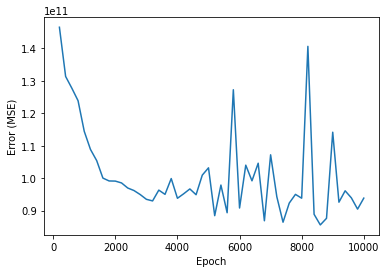

[179, 427, 219, 486, 46]
Epoch: 200 MSE normalized: 0.0010345093 MSE: 133355490582.65036
Epoch: 400 MSE normalized: 0.00031043566 MSE: 131660080295.1027
Epoch: 600 MSE normalized: 0.00026806112 MSE: 104605125454.32964
Epoch: 800 MSE normalized: 0.00040289707 MSE: 110235918468.84302
Epoch: 1000 MSE normalized: 0.00015274956 MSE: 117478654000.57257
Epoch: 1200 MSE normalized: 0.00018837625 MSE: 120285050479.43105
Epoch: 1400 MSE normalized: 0.0004428665 MSE: 98933519399.26183
Epoch: 1600 MSE normalized: 0.00016725577 MSE: 118512612859.35117
Epoch: 1800 MSE normalized: 0.00029583645 MSE: 100575306664.84325
Epoch: 2000 MSE normalized: 0.00023336241 MSE: 101544343640.39253
Epoch: 2200 MSE normalized: 0.00031236195 MSE: 98986665643.75108
Epoch: 2400 MSE normalized: 0.006998746 MSE: 101966074355.03735
Epoch: 2600 MSE normalized: 0.0005923314 MSE: 109586732732.42232
Epoch: 2800 MSE normalized: 0.00015049365 MSE: 107111838368.1383
Epoch: 3000 MSE normalized: 0.00017228012 MSE: 113759795717.5046

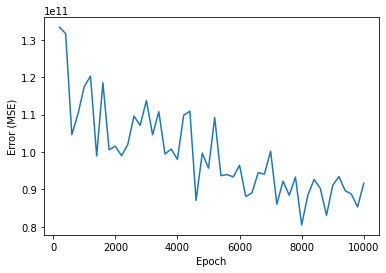

2  	4     	9.66037e+10	7.83564e+09	8.90933e+10	1.11363e+11
[179, 427, 24, 486, 16]
Epoch: 200 MSE normalized: 0.00096318946 MSE: 112283358397.02019
Epoch: 400 MSE normalized: 0.00030780048 MSE: 95288448591.11894
Epoch: 600 MSE normalized: 0.00036521326 MSE: 92353910027.82396
Epoch: 800 MSE normalized: 0.00040034764 MSE: 91364580770.80269
Epoch: 1000 MSE normalized: 0.00015631206 MSE: 84555999026.7261
Epoch: 1200 MSE normalized: 0.0002884238 MSE: 80663358028.68578
Epoch: 1400 MSE normalized: 0.00044840726 MSE: 82849774652.18666
Epoch: 1600 MSE normalized: 0.00024179797 MSE: 86522090692.8842
Epoch: 1800 MSE normalized: 0.00030201723 MSE: 79562128449.08884
Epoch: 2000 MSE normalized: 0.00043516257 MSE: 120720730638.54793
Epoch: 2200 MSE normalized: 0.00038360208 MSE: 92232452569.9251
Epoch: 2400 MSE normalized: 0.005597345 MSE: 82144052383.29611
Epoch: 2600 MSE normalized: 0.00022710487 MSE: 77508074087.23384
Epoch: 2800 MSE normalized: 0.0002241092 MSE: 83779946239.5234
Epoch: 3000 MSE n

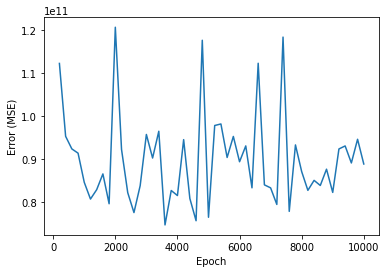

[179, 427, 219, 486, 46]
Epoch: 200 MSE normalized: 0.0011264165 MSE: 134594987775.02032
Epoch: 400 MSE normalized: 0.00040075413 MSE: 102001126637.33109
Epoch: 600 MSE normalized: 0.00027642076 MSE: 94106154190.06117
Epoch: 800 MSE normalized: 0.00049470115 MSE: 97588929284.80734
Epoch: 1000 MSE normalized: 0.00020792223 MSE: 95368993522.29176
Epoch: 1200 MSE normalized: 0.00021607953 MSE: 99403203015.76653
Epoch: 1400 MSE normalized: 0.00034033033 MSE: 96452187171.74796
Epoch: 1600 MSE normalized: 0.00016735654 MSE: 96588212640.75146
Epoch: 1800 MSE normalized: 0.0002653818 MSE: 96134494395.7874
Epoch: 2000 MSE normalized: 0.00019483845 MSE: 100658747570.0981
Epoch: 2200 MSE normalized: 0.0002597455 MSE: 97559008252.192
Epoch: 2400 MSE normalized: 0.0073127667 MSE: 95546163040.19254
Epoch: 2600 MSE normalized: 0.00027466836 MSE: 99740979046.66972
Epoch: 2800 MSE normalized: 0.0001786109 MSE: 96267141448.02028
Epoch: 3000 MSE normalized: 0.00025432414 MSE: 104349141086.80406
Epoch: 32

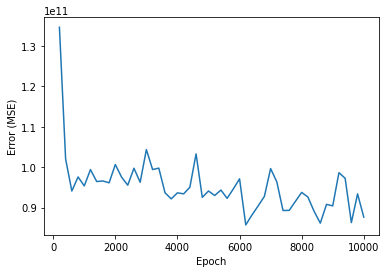

[179, 427, 219, 486, 46]
Epoch: 200 MSE normalized: 0.0007357501 MSE: 115525711388.93796
Epoch: 400 MSE normalized: 0.0003532946 MSE: 110196985640.26247
Epoch: 600 MSE normalized: 0.00026066785 MSE: 110303133249.76604
Epoch: 800 MSE normalized: 0.0003629202 MSE: 116317242466.41002
Epoch: 1000 MSE normalized: 0.00019976936 MSE: 103691876968.79639
Epoch: 1200 MSE normalized: 0.00018171569 MSE: 109992721509.2784
Epoch: 1400 MSE normalized: 0.0002467779 MSE: 117948384543.04846
Epoch: 1600 MSE normalized: 0.00025825188 MSE: 113158536439.1952
Epoch: 1800 MSE normalized: 0.00029762997 MSE: 109639131673.27567
Epoch: 2000 MSE normalized: 0.00016933978 MSE: 114916004835.193
Epoch: 2200 MSE normalized: 0.0001968727 MSE: 121855632332.70503
Epoch: 2400 MSE normalized: 0.004703335 MSE: 112644444992.82404
Epoch: 2600 MSE normalized: 0.00031384378 MSE: 110531404699.10388
Epoch: 2800 MSE normalized: 0.00017150756 MSE: 101154857074.46323
Epoch: 3000 MSE normalized: 0.0002527909 MSE: 119281991535.46634
E

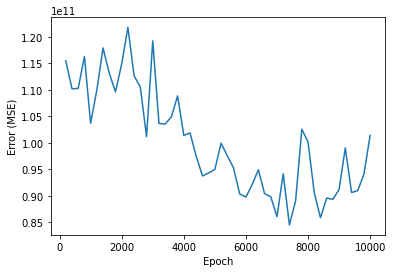

[179, 427, 219, 486, 46]
Epoch: 200 MSE normalized: 0.0006061117 MSE: 115279530411.46648
Epoch: 400 MSE normalized: 0.00032888362 MSE: 116715442205.36896
Epoch: 600 MSE normalized: 0.00035803596 MSE: 102522954714.13962
Epoch: 800 MSE normalized: 0.00047712133 MSE: 104435696960.10973
Epoch: 1000 MSE normalized: 0.00020910491 MSE: 96638750501.79398
Epoch: 1200 MSE normalized: 0.00026516887 MSE: 106509441169.68086
Epoch: 1400 MSE normalized: 0.0003501616 MSE: 94139536242.34499
Epoch: 1600 MSE normalized: 0.00016056535 MSE: 94654224803.21783
Epoch: 1800 MSE normalized: 0.0002025743 MSE: 93252216162.5691
Epoch: 2000 MSE normalized: 0.00023129278 MSE: 113297152806.2331
Epoch: 2200 MSE normalized: 0.00028889903 MSE: 94868175032.67458
Epoch: 2400 MSE normalized: 0.006232872 MSE: 91846699043.7071
Epoch: 2600 MSE normalized: 0.0003631313 MSE: 96316546944.93921
Epoch: 2800 MSE normalized: 0.00025761215 MSE: 90056470772.35481
Epoch: 3000 MSE normalized: 0.00029521043 MSE: 95156046424.64848
Epoch: 

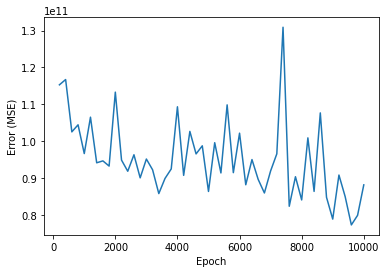

3  	4     	9.10286e+10	5.21245e+09	8.76627e+10	1.01405e+11
[179, 427, 24, 486, 46]
Epoch: 200 MSE normalized: 0.0012512602 MSE: 137502891537.22284
Epoch: 400 MSE normalized: 0.00045195976 MSE: 119902117694.70985
Epoch: 600 MSE normalized: 0.0005631079 MSE: 113224951059.29182
Epoch: 800 MSE normalized: 0.0004960375 MSE: 102762459682.87117
Epoch: 1000 MSE normalized: 0.00032027133 MSE: 94546210416.42009
Epoch: 1200 MSE normalized: 0.0003466851 MSE: 90307355903.13899
Epoch: 1400 MSE normalized: 0.0005279707 MSE: 89279879016.48883
Epoch: 1600 MSE normalized: 0.00046742722 MSE: 89613022490.83215
Epoch: 1800 MSE normalized: 0.00044092585 MSE: 85132909131.73003
Epoch: 2000 MSE normalized: 0.00025855727 MSE: 87141837097.26207
Epoch: 2200 MSE normalized: 0.00025012516 MSE: 92307666375.93463
Epoch: 2400 MSE normalized: 0.008980281 MSE: 90642304571.13832
Epoch: 2600 MSE normalized: 0.00024852567 MSE: 105671947124.78943
Epoch: 2800 MSE normalized: 0.0002589112 MSE: 97579483637.15842
Epoch: 3000 MS

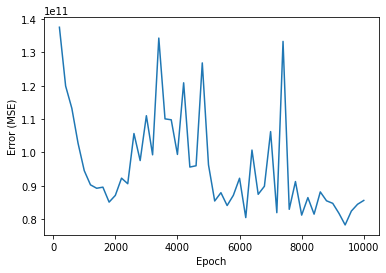

[179, 427, 219, 486, 16]
Epoch: 200 MSE normalized: 0.0009600161 MSE: 98444869322.43036
Epoch: 400 MSE normalized: 0.00024901456 MSE: 87689035369.7437
Epoch: 600 MSE normalized: 0.0003080025 MSE: 99636717476.56084
Epoch: 800 MSE normalized: 0.00033125601 MSE: 96498425301.82816
Epoch: 1000 MSE normalized: 0.00016022645 MSE: 87866561871.228
Epoch: 1200 MSE normalized: 0.00024732534 MSE: 93006443029.13284
Epoch: 1400 MSE normalized: 0.0003634875 MSE: 86945339426.88385
Epoch: 1600 MSE normalized: 0.00031973838 MSE: 100665634670.2729
Epoch: 1800 MSE normalized: 0.00020826526 MSE: 96886267079.6054
Epoch: 2000 MSE normalized: 0.00014608171 MSE: 90024330497.12941
Epoch: 2200 MSE normalized: 0.0002831692 MSE: 90180980013.61893
Epoch: 2400 MSE normalized: 0.0050951536 MSE: 87901093525.80554
Epoch: 2600 MSE normalized: 0.00027497302 MSE: 96578375170.97076
Epoch: 2800 MSE normalized: 0.0003129463 MSE: 93449227298.57002
Epoch: 3000 MSE normalized: 0.00045701853 MSE: 100054968743.1736
Epoch: 3200 MS

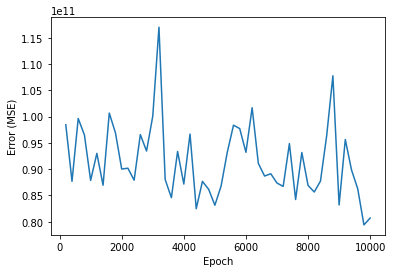

4  	2     	8.58675e+10	2.69466e+09	8.07114e+10	8.76627e+10
[179, 427, 24, 486, 16]
Epoch: 200 MSE normalized: 0.00083811104 MSE: 90609013049.36696
Epoch: 400 MSE normalized: 0.0003004453 MSE: 81125533337.6733
Epoch: 600 MSE normalized: 0.0003179094 MSE: 75887141543.6302
Epoch: 800 MSE normalized: 0.00042223666 MSE: 74542785493.61559
Epoch: 1000 MSE normalized: 0.00023526384 MSE: 85491163981.91792
Epoch: 1200 MSE normalized: 0.00034188363 MSE: 101094548185.7265
Epoch: 1400 MSE normalized: 0.00032956828 MSE: 86432917109.0156
Epoch: 1600 MSE normalized: 0.00031237912 MSE: 118014146226.50806
Epoch: 1800 MSE normalized: 0.00029608843 MSE: 83355478942.0424
Epoch: 2000 MSE normalized: 0.00035582145 MSE: 95446941694.58363
Epoch: 2200 MSE normalized: 0.0003066873 MSE: 86356303957.94554
Epoch: 2400 MSE normalized: 0.006844221 MSE: 92701057804.00557
Epoch: 2600 MSE normalized: 0.00066089735 MSE: 87330594892.07161
Epoch: 2800 MSE normalized: 0.00051498774 MSE: 84621018626.99579
Epoch: 3000 MSE nor

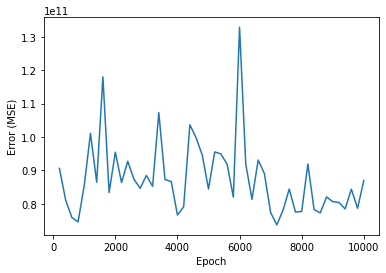

[179, 427, 219, 486, 46]
Epoch: 200 MSE normalized: 0.0008734523 MSE: 123096836046.02914
Epoch: 400 MSE normalized: 0.0003441 MSE: 111985967308.6342
Epoch: 600 MSE normalized: 0.00028729028 MSE: 109103400499.66322
Epoch: 800 MSE normalized: 0.00036713685 MSE: 112642187879.01433
Epoch: 1000 MSE normalized: 0.00014288443 MSE: 120956404469.82191
Epoch: 1200 MSE normalized: 0.00033336363 MSE: 104989375928.79378
Epoch: 1400 MSE normalized: 0.00033031803 MSE: 103321679766.66322
Epoch: 1600 MSE normalized: 0.00017948642 MSE: 108530852181.6366
Epoch: 1800 MSE normalized: 0.00049193867 MSE: 124061669363.09877
Epoch: 2000 MSE normalized: 0.00022209325 MSE: 122016030039.49063
Epoch: 2200 MSE normalized: 0.00023284322 MSE: 105180762401.18883
Epoch: 2400 MSE normalized: 0.006573392 MSE: 108170079231.1952
Epoch: 2600 MSE normalized: 0.00028684066 MSE: 106555506663.26187
Epoch: 2800 MSE normalized: 0.00013666482 MSE: 100591808116.20853
Epoch: 3000 MSE normalized: 0.00032841932 MSE: 106366484440.77841

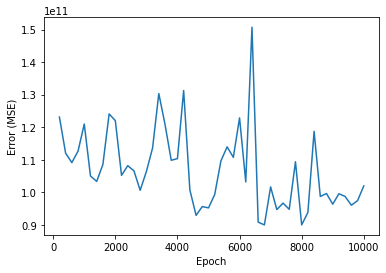

[179, 427, 24, 486, 16]
Epoch: 200 MSE normalized: 0.0011559922 MSE: 131246942127.48885
Epoch: 400 MSE normalized: 0.00045674923 MSE: 122842980422.94502
Epoch: 600 MSE normalized: 0.0005832168 MSE: 114047653580.22481
Epoch: 800 MSE normalized: 0.0005522312 MSE: 105053680758.93967
Epoch: 1000 MSE normalized: 0.00021695081 MSE: 97510952708.9743
Epoch: 1200 MSE normalized: 0.00032975874 MSE: 90574855464.6858
Epoch: 1400 MSE normalized: 0.00047927484 MSE: 87601512397.9404
Epoch: 1600 MSE normalized: 0.0003955299 MSE: 90895671778.28902
Epoch: 1800 MSE normalized: 0.00029946503 MSE: 90348266322.59631
Epoch: 2000 MSE normalized: 0.0002989156 MSE: 87602063422.44463
Epoch: 2200 MSE normalized: 0.00038224048 MSE: 87424711470.9864
Epoch: 2400 MSE normalized: 0.0083358 MSE: 90504508501.37637
Epoch: 2600 MSE normalized: 0.00028449754 MSE: 91645655857.74594
Epoch: 2800 MSE normalized: 0.0006026367 MSE: 87420950663.74251
Epoch: 3000 MSE normalized: 0.0003783272 MSE: 95182277099.62134
Epoch: 3200 MSE 

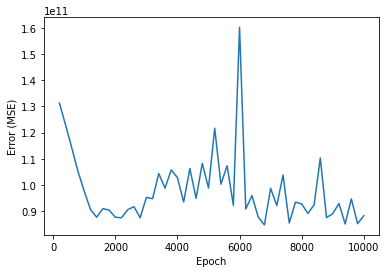

[179, 427, 219, 486, 46]
Epoch: 200 MSE normalized: 0.0009925269 MSE: 123577498444.57248
Epoch: 400 MSE normalized: 0.0003769683 MSE: 106585278334.90636
Epoch: 600 MSE normalized: 0.00046864446 MSE: 98900851277.10739
Epoch: 800 MSE normalized: 0.00029260057 MSE: 100722776705.9722
Epoch: 1000 MSE normalized: 0.00018535196 MSE: 100484400163.39703
Epoch: 1200 MSE normalized: 0.00015360095 MSE: 96429718202.63042
Epoch: 1400 MSE normalized: 0.00027192966 MSE: 97923364940.9442
Epoch: 1600 MSE normalized: 0.00011379676 MSE: 95637851773.25217
Epoch: 1800 MSE normalized: 0.00016511515 MSE: 101364445172.71634
Epoch: 2000 MSE normalized: 0.00018288991 MSE: 105985075220.03735
Epoch: 2200 MSE normalized: 0.00031714092 MSE: 110361632427.37192
Epoch: 2400 MSE normalized: 0.006048603 MSE: 109716968391.50847
Epoch: 2600 MSE normalized: 0.0002355044 MSE: 106153258073.47293
Epoch: 2800 MSE normalized: 0.00046882694 MSE: 99691211491.34157
Epoch: 3000 MSE normalized: 0.00024535408 MSE: 105193109819.69974
E

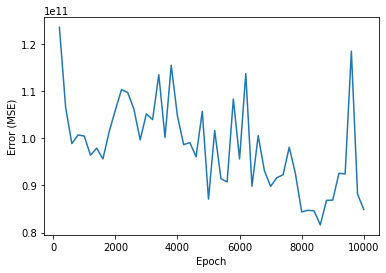

5  	4     	8.99315e+10	6.10245e+09	8.49123e+10	1.01931e+11
[179, 427, 24, 486, 16]
Epoch: 200 MSE normalized: 0.0016002884 MSE: 168043602833.32333
Epoch: 400 MSE normalized: 0.00060871715 MSE: 150554666633.002
Epoch: 600 MSE normalized: 0.00061548495 MSE: 135854837738.61472
Epoch: 800 MSE normalized: 0.0006169772 MSE: 122492556584.90169
Epoch: 1000 MSE normalized: 0.0002769686 MSE: 106012853406.25993
Epoch: 1200 MSE normalized: 0.0004862531 MSE: 95747277683.5959
Epoch: 1400 MSE normalized: 0.0004073312 MSE: 92857659397.2976
Epoch: 1600 MSE normalized: 0.0005145145 MSE: 92505393627.4636
Epoch: 1800 MSE normalized: 0.00043151045 MSE: 94171157894.98189
Epoch: 2000 MSE normalized: 0.0002960136 MSE: 97167566769.77367
Epoch: 2200 MSE normalized: 0.00038430066 MSE: 100634789921.30862
Epoch: 2400 MSE normalized: 0.008628242 MSE: 105170892039.0178
Epoch: 2600 MSE normalized: 0.0003669049 MSE: 91381940419.9187
Epoch: 2800 MSE normalized: 0.0008319266 MSE: 98191626668.0668
Epoch: 3000 MSE normali

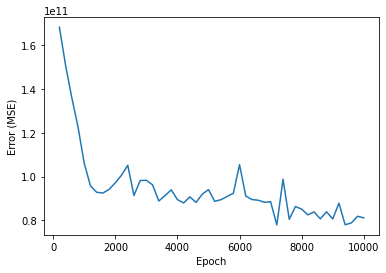

[179, 427, 24, 486, 16]
Epoch: 200 MSE normalized: 0.00059491454 MSE: 118877836730.22452
Epoch: 400 MSE normalized: 0.0003760972 MSE: 111448380086.36201
Epoch: 600 MSE normalized: 0.00037424138 MSE: 90219527904.99965
Epoch: 800 MSE normalized: 0.00037583537 MSE: 103763518651.8404
Epoch: 1000 MSE normalized: 0.00020678515 MSE: 109619171799.7315
Epoch: 1200 MSE normalized: 0.00027387636 MSE: 100943943662.39403
Epoch: 1400 MSE normalized: 0.00038776387 MSE: 104699762202.09299
Epoch: 1600 MSE normalized: 0.0003593343 MSE: 100554371052.3039
Epoch: 1800 MSE normalized: 0.00027350965 MSE: 107728809669.56166
Epoch: 2000 MSE normalized: 0.00025002068 MSE: 133054183160.3945
Epoch: 2200 MSE normalized: 0.00033997727 MSE: 83822584327.7258
Epoch: 2400 MSE normalized: 0.0075487946 MSE: 90116594288.87341
Epoch: 2600 MSE normalized: 0.0005108212 MSE: 84067899503.54652
Epoch: 2800 MSE normalized: 0.0005297542 MSE: 85870340450.3555
Epoch: 3000 MSE normalized: 0.00032123004 MSE: 92037208896.37422
Epoch: 

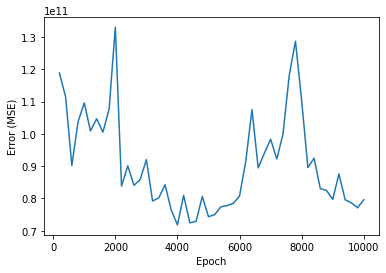

[179, 427, 219, 486, 64]
Epoch: 200 MSE normalized: 0.0009542794 MSE: 98322347758.38333
Epoch: 400 MSE normalized: 0.0002992707 MSE: 95369778887.31212
Epoch: 600 MSE normalized: 0.0002612802 MSE: 100692758054.51295
Epoch: 800 MSE normalized: 0.0002906218 MSE: 102916216755.45674
Epoch: 1000 MSE normalized: 0.00015316122 MSE: 97777808104.09923
Epoch: 1200 MSE normalized: 0.0003554893 MSE: 93988746442.41338
Epoch: 1400 MSE normalized: 0.00026438833 MSE: 98519276255.42801
Epoch: 1600 MSE normalized: 0.00046381765 MSE: 96142977622.688
Epoch: 1800 MSE normalized: 0.00042219122 MSE: 86382603416.9979
Epoch: 2000 MSE normalized: 0.00018337429 MSE: 91007176810.98412
Epoch: 2200 MSE normalized: 0.00029204378 MSE: 88714224880.54643
Epoch: 2400 MSE normalized: 0.0003630929 MSE: 94576833339.4427
Epoch: 2600 MSE normalized: 0.00023285238 MSE: 93891782900.87048
Epoch: 2800 MSE normalized: 0.00017380998 MSE: 88967285691.02567
Epoch: 3000 MSE normalized: 0.00026549812 MSE: 105266575548.19308
Epoch: 3200

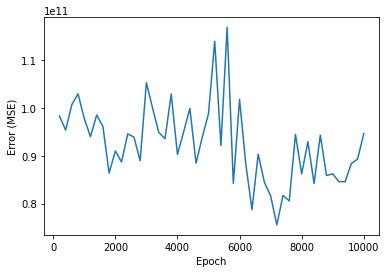

[179, 427, 24, 486, 46]
Epoch: 200 MSE normalized: 0.00109692 MSE: 127753428517.83522
Epoch: 400 MSE normalized: 0.00038709643 MSE: 113545531944.6113
Epoch: 600 MSE normalized: 0.00051710405 MSE: 110669533101.3184
Epoch: 800 MSE normalized: 0.00043932788 MSE: 124309933120.13162
Epoch: 1000 MSE normalized: 0.00022573062 MSE: 110247370780.10925
Epoch: 1200 MSE normalized: 0.00029840448 MSE: 104685583258.70757
Epoch: 1400 MSE normalized: 0.00043059565 MSE: 123794414076.72919
Epoch: 1600 MSE normalized: 0.00021160362 MSE: 114426252810.88152
Epoch: 1800 MSE normalized: 0.0004719135 MSE: 107611275392.87598
Epoch: 2000 MSE normalized: 0.0007239131 MSE: 394080671320.5413
Epoch: 2200 MSE normalized: 0.0003126596 MSE: 117087395606.63608
Epoch: 2400 MSE normalized: 0.002593232 MSE: 111458466034.88824
Epoch: 2600 MSE normalized: 0.00024609207 MSE: 148065687282.2881
Epoch: 2800 MSE normalized: 0.0002167884 MSE: 146082621044.22623
Epoch: 3000 MSE normalized: 0.00038116315 MSE: 90927786693.58957
Epoc

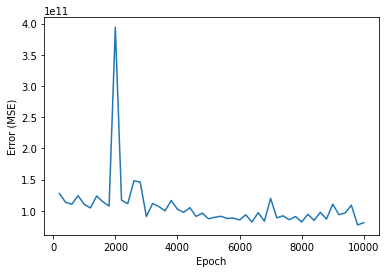

6  	4     	8.48387e+10	5.62513e+09	7.9613e+10 	9.46205e+10


In [117]:
best_results_regression = {} #dictionary where best combinations will be added
collection_log_regression = {}
layer_number = 6        # The number of layers of de NN will be 
                        # from 2 to layer_number - 1

for i in range(2,layer_number):
    pop, log, hof = run_deap(X_train_house.as_matrix(), y_train_normalized, X_test_house.as_matrix(), y_test_normalized,min_val_reg= min_price,max_val_reg= max_price,n_neurons=500, n_layers=i, n_population=5, classifier= False, maximize=False)
    best_results_regression[i] = hof
    collection_log_regression[i] = log

As the objetive of the genetic algorithm in this case is to minimize the fitness, the following plot represents that the values closer to 0 are better, due to the minimization objective. 

Layer nº:  2 	 Best structure:  [83, 150] 	 Fitness:  79613033620.39598
Layer nº:  3 	 Best structure:  [97, 200, 51] 	 Fitness:  79613033620.39598
Layer nº:  4 	 Best structure:  [242, 156, 179, 165] 	 Fitness:  79613033620.39598
Layer nº:  5 	 Best structure:  [179, 427, 24, 486, 16] 	 Fitness:  79613033620.39598


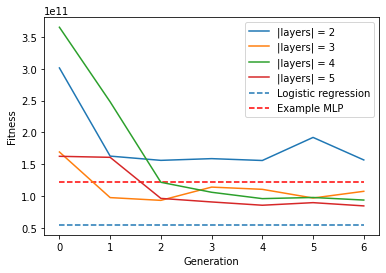

In [118]:
plt.hlines(mse_house,xmin=0,xmax=6,linestyles='dashed', label="Logistic regression")
plt.hlines(best_acc,xmin=0,xmax=6,color = "r",linestyles='dashed', label="Example MLP")

for i in range(2,layer_number):

    print("Layer nº: ",i,"\t Best structure: ",best_results_regression[i].items[0], "\t Fitness: ",hof.keys[0].values[0])

    gen = collection_log[i].select("gen")
    size_avgs = np.array(collection_log_regression[i].select('avg'))
    
    # plt.ylim(0.5, 1)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")

    plt.plot(gen, size_avgs, label="|layers| = "+str(i))

plt.legend()